# Progress of the Philippines' Sustainable Development Goals
In 2015, the United Nations General Assembly created 17 interlinked global goals that was intended to be achieved by 2030. It was said that it would pave the way to "a better and more sustainable future for all". The interlinked global goals was named the **Sustainable Development Goals** (SDG).

In this notebook, 27 different datasets from the Philippine Statistics Authority, the government agency assigned to update the Philippine's data on this goals, would be combined. Fifteen (15) of these datasets are directly about the SDG, while others are indirectly connected to the SDGs.

### Import
Import `os`, `math`, `numpy`, `pandas`, `matplotlib.pyplot`, `seaborn`, and `zscore`.
- `os` is a module that allows the usage of operating system dependent functionality
- `numpy` contains a large collection of mathematical functions
- `pandas` is a software library for Python that is designed for data manipulation and data analysis
- `matplotlib.pyplot` contains functions to create interactive plots
- `seaborn` is a library based on matplotlib that allows visualization
- `zscore` allows the computation of the zscore

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

## Data Collection
The following **csv** files used in this project are acquired through a request sent to the Knowledge Management and Communications Division of the Philippine Statistics Authority.

### Combining the Datasets 
In this stage, the separate datasets underwent pre-processing and cleaning before they are combined together. 

First, the irrelevant rows were dropped first. These were the rows that have all NaN values and the additional rows (i.e., note rows, “Data available” rows) found in the CSV files. 

Second, since the first row of the CSV files was the name of the indicator and unnamed rows, the resulting DataFrame had “Unnamed” as its column header. Due to this, we had to set the column headers to the second row of the DataFrame, and then drop this afterward.

Third, since the `Geolocation` column would be used later to merge the datasets, the values in this column were standardized into the format `Region n: region_name`, where *n* is the corresponding region number and *region_name* is the name of the region. If it does not have a region number, then it was formatted as `region_abbreviation: region_name`, where *region_abbreviation* is its official abbreviation. 

Fourth, there are datasets that had divisions for a region and year, but still include a cumulative value for that division (e.g., datasets that are also divided per `Sex`, while having a value of “Both Sexes”. For this situation, we have decided to only get the cumulative row (e.g., Both Sexes), drop the other rows that represent the division (e.g., Female and Male), and drop the column that is related to this division (Sex). 

Fifth, we convert the DataFrame into its long representation. Once we have the dataset into its long representation, then we can merge it to the combined dataset while using the Year and Geolocation columns as its primary key. This would be done for all of the twenty-five datasets.

This process would result in one DataFrame that is in its long representation, with three kinds of columns: (1) Geolocation, (2) Year, and (3) the value for each of the indicators. 

#### 1.2.1. Proportion of population living below the national poverty line 
To start with, let us load the data from the csv file using pandas' [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

The [`os.getenv`](https://docs.python.org/3/library/os.html) function was used to get the environment variable `DSDATA_PROJ`, which points to the data folder of this project.

In [2]:
data = pd.read_csv('data' + '/1.2.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/1.2.1.csv')
data

,1.2.1 Proportion of population living below the national poverty line by sex age 1/,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015.0,2016,2017,2018.0,2019,2020,2021,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,..,..,..,..,..,..,..,..,...,..,..,23.5,..,..,16.7,..,..,...,..
3,..National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,4.1,..,..,2.2,..,..,...,..
4,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,22.7,..,..,12.0,..,..,...,..
5,..Region I,..,..,..,..,..,..,..,..,..,...,..,..,18.8,..,..,9.9,..,..,...,..
6,..Region II,..,..,..,..,..,..,..,..,..,...,..,..,17.8,..,..,16.3,..,..,...,..
7,..Region III,..,..,..,..,..,..,..,..,..,...,..,..,10.5,..,..,7.0,..,..,...,..
8,..Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,12.5,..,..,7.1,..,..,...,..
9,..MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,25.2,..,..,15.1,..,..,...,..


Looking at the DataFrame, we could see that the columns are unnamed and that the column names are located at the 0th row. Using [`iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html), we could get the 0th row and then assign it as the column values. 

Then, using the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) function, we can drop the 0th row as we have no need for it anymore. Additionally, since the row at index 1 is a row full of NaN, we can also drop it using the same function. 

To be able to fix the indexing of the rows, the [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function was used to reset the index from 0.

In [3]:
# setting our column names
data.columns = data.iloc [0] 

# dropping the 'geolocation' row as that is actually used as a header
data = data.drop (data.index [1])

# dropping the column names 
data = data.drop (data.index [0])

data.reset_index (drop=True, inplace=True)

Irrelevant rows that are just footers for the file are also removed.

In [4]:
# dropping irrelevant rows 
data = data.drop (data.index [18:]) 

The `Year` column must also be renamed into `Geolocation` as this row refers to the different regions in the Philippines, and not the years. This can be done through the use of the of the [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) function.

In [5]:
# renames the column 'Year' as its actually the location column
data.rename(columns = {'Year':'Geolocation'}, inplace=True)

To easily determine which region the `Geolocation` values refer to, we can also change these values to include the names that they are commonly referred to, instead of just their region numbers. 

For consistency throughout the different datasets, the `region_names` variable was declared. The reason why a map was not used was that different datasets have different representations of the region (i.e., differences in naming a region), however, they are always arranged in the same way. This would be shown below in the pre-processing of each of the datasets.

In [6]:
# NOTE: Before applying, make sure that the arrangement of the regions are the same as the arrangement in your table
region_names = ['PHILIPPINES', 'NCR: National Capital Region', 
                 'CAR: Cordillera Administrative Region', 
                 'Region 1: Ilocos Region', 
                 'Region 2: Cagayan Valley', 
                 'Region 3: Central Luzon', 
                 'Region 4A: CALABARZON', 
                'MIMAROPA: Southwestern Tagalog Region', 
                'Region 5: Bicol Region', 
                'Region 6: Western Visayas', 
                'Region 7: Central Visayas', 
                'Region 8: Eastern Visayas', 
                'Region 9: Zamboanga Peninsula', 
                'Region 10: Northern Mindanao', 
                'Region 11: Davao Region', 
                'Region 12: SOCCSKSARGEN', 
                'CARAGA: Cordillera Administrative Region', 
                'BARMM: Bangsamoro Autonomous Region in Muslim Mindanao']

In [7]:
# renames the data in the Geolocation for consistency
data['Geolocation'] = region_names
data.set_index('Geolocation')
data = data.reset_index(drop=True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015.0,2016,2017,2018.0,2019,2020,2021,2022
0,PHILIPPINES,..,..,..,..,..,..,..,..,..,...,..,..,23.5,..,..,16.7,..,..,...,..
1,NCR: National Capital Region,..,..,..,..,..,..,..,..,..,...,..,..,4.1,..,..,2.2,..,..,...,..
2,CAR: Cordillera Administrative Region,..,..,..,..,..,..,..,..,..,...,..,..,22.7,..,..,12.0,..,..,...,..
3,Region 1: Ilocos Region,..,..,..,..,..,..,..,..,..,...,..,..,18.8,..,..,9.9,..,..,...,..
4,Region 2: Cagayan Valley,..,..,..,..,..,..,..,..,..,...,..,..,17.8,..,..,16.3,..,..,...,..
5,Region 3: Central Luzon,..,..,..,..,..,..,..,..,..,...,..,..,10.5,..,..,7.0,..,..,...,..
6,Region 4A: CALABARZON,..,..,..,..,..,..,..,..,..,...,..,..,12.5,..,..,7.1,..,..,...,..
7,MIMAROPA: Southwestern Tagalog Region,..,..,..,..,..,..,..,..,..,...,..,..,25.2,..,..,15.1,..,..,...,..
8,Region 5: Bicol Region,..,..,..,..,..,..,..,..,..,...,..,..,39.8,..,..,27.0,..,..,...,..
9,Region 6: Western Visayas,..,..,..,..,..,..,..,..,..,...,..,..,24.6,..,..,16.3,..,..,...,..


Next, we can convert the strings of '..' and '...', which were used to represent that there were no values for these cells, to **NaN**, through the use of the [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) function.

However, the columns that have all **NaN** values were not dropped because if this dataset would be combined with other datasets, all years would still be present as there are datasets with complete data for all the years. Additionally, dropping the years for some of the dataset would result in the combined dataset having a weird sorting (i.e., a sorting of the region that does not follow the usual sorting of the datasets in the Philippines), even if it was sorted based on the `Year` and `Geolocation` column.

In [8]:
for c in data.columns.difference(['Geolocation']):
    # cells without values are represented as either '..' or '...', so we should convert them to NaN so we could dropna()
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# drops columns if all of the values are NaN
# data = data.dropna(axis=1)

In [9]:
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015.0,2016,2017,2018.0,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.5,NaN,NaN,16.7,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.1,NaN,NaN,2.2,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22.7,NaN,NaN,12.0,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,18.8,NaN,NaN,9.9,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.8,NaN,NaN,16.3,NaN,NaN,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10.5,NaN,NaN,7.0,NaN,NaN,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.5,NaN,NaN,7.1,NaN,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.2,NaN,NaN,15.1,NaN,NaN,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39.8,NaN,NaN,27.0,NaN,NaN,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,24.6,NaN,NaN,16.3,NaN,NaN,NaN,NaN


As the final step, the wide representation of this dataset is converted to a long representation through the use of the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function. 

Then, the column that holds the value for a specific year and region is coverted, using [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html), to the ID of this Sustainable Development Goal (SDG), so that it can be distinguished when it is combined with other datasets.

In [10]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'1.2.1. Proportion of population living below the national poverty line', 0 : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


As this is the first dataset, we can just assign it to the `combined_data` DataFrame, which would hold the combined datasets.

In [11]:
combined_data = data

#### 1.4.1p5. Net Enrolment Rate in elementary

Using the same [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function, we load the next dataset. 

In [12]:
data = pd.read_csv('data' + '/1.4.1p5.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/1.4.1p5.csv')
data

,1.4.1p5 Net Enrolment Rate in elementary (Indicator is also found in SDG 4.3.s1) 1/,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,NaN,Year,2000,2001,2002.00,2003.00,2004.00,2005.00,2006.00,2007.00,...,2013.00,2014.00,2015.00,2016.00,2017.00,2018.00,2019.00,2020.0000,2021,2022
1,Geolocation,Sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,Both Sexes,96.77,90.1,90.29,88.74,87.11,84.44,83.22,84.93,...,97.20,97.19,96.90,96.15,94.19,94.05,93.96,89.1064,...,...
3,NaN,Boys,96.27,89.33,89.51,87.84,86.17,83.56,82.39,84.07,...,96.74,96.87,96.66,96.17,94.12,94.25,93.79,88.9318,...,...
4,NaN,Girls,97.28,90.91,91.10,89.68,88.08,85.35,84.08,85.83,...,97.68,97.53,97.15,96.12,94.27,93.85,94.15,89.2898,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Note:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,.. - Data not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,... - Data not yet available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,1/ - Updates were based on the submission of D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the DataFrame above, we can see that the footer of the .csv files was included in the DataFrame. As the rows from the 56th index are irrelevant, we can [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) them. 

In [13]:
data = data.drop (data.index [56:]) 

Additionally, we can see that the columns are unnamed, and upon inspection, the original column names can be found at `Index 0`. Thus, we can set the columns to this row, and then  [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the `Index 0` row as it would only be redundant and might affect the computations.

The [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function was used in order to make the index of the rows start from 0.

In [14]:
# setting the column names and removing the row that held the previous column names
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)
data

,NaN,Year,2000,2001,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021,2022
0,Geolocation,Sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PHILIPPINES,Both Sexes,96.77,90.1,90.29,88.74,87.11,84.44,83.22,84.93,...,97.20,97.19,96.90,96.15,94.19,94.05,93.96,89.1064,...,...
2,NaN,Boys,96.27,89.33,89.51,87.84,86.17,83.56,82.39,84.07,...,96.74,96.87,96.66,96.17,94.12,94.25,93.79,88.9318,...,...
3,NaN,Girls,97.28,90.91,91.10,89.68,88.08,85.35,84.08,85.83,...,97.68,97.53,97.15,96.12,94.27,93.85,94.15,89.2898,...,...
4,..National Capital Region (NCR),Both Sexes,101,97.82,97.38,96.81,94.82,92.61,92.89,94.42,...,99.64,99.01,99.85,95.92,92.83,92.11,89.91,81.1478,...,...
5,NaN,Boys,100.13,96.57,96.52,95.81,93.75,91.65,92.00,93.21,...,98.77,98.13,98.80,95.30,92.20,91.85,89.43,80.6316,...,...
6,NaN,Girls,101.92,99.13,98.28,97.87,95.95,93.63,93.83,95.69,...,100.57,99.95,100.95,96.58,93.50,92.38,90.42,81.6903,...,...
7,..Cordillera Administrative Region (CAR),Both Sexes,94.42,92.89,91.52,89.19,86.40,82.58,80.86,81.50,...,99.66,100.16,99.19,97.24,94.37,92.24,91.40,87.5276,...,...
8,NaN,Boys,94.26,91.96,90.53,88.36,85.52,81.75,80.19,81.01,...,99.85,100.27,99.42,97.94,95.13,93.45,92.25,88.5518,...,...
9,NaN,Girls,94.58,93.88,92.57,90.07,87.31,83.46,81.57,82.01,...,99.47,100.05,98.95,96.51,93.59,90.99,90.51,86.4657,...,...


However, these is still a row of NaN found at `Index 0`, and we can see that the column names for the first two columns are not correct for the values underneath it, as the ones under the first column are actually Geolocations and those under the second columns are the values for Sex. Thus, we can [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) it, and then [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)  the row at `Index 0`.

In [15]:
data = data.rename(columns = {np.nan:'Geolocation', 'Year': 'Sex'})
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

As we would only need the data that is grouped by region and not by sex, we would only be getting the rows that has **Both Sexes** as the value in the Sex column. After this, we can [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the Sex column as it would not be used onwards.

In [16]:
# Only getting the total data, then dropping Sex column as it's not needed anymore
data = data[data['Sex'] == 'Both Sexes']
data = data.drop("Sex", axis = 1)
data = data.reset_index (drop=True)
data

,Geolocation,2000,2001,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021,2022
0,PHILIPPINES,96.77,90.1,90.29,88.74,87.11,84.44,83.22,84.93,85.11,...,97.20,97.19,96.90,96.15,94.19,94.05,93.96,89.1064,...,...
1,..National Capital Region (NCR),101,97.82,97.38,96.81,94.82,92.61,92.89,94.42,93.69,...,99.64,99.01,99.85,95.92,92.83,92.11,89.91,81.1478,...,...
2,..Cordillera Administrative Region (CAR),94.42,92.89,91.52,89.19,86.40,82.58,80.86,81.50,81.93,...,99.66,100.16,99.19,97.24,94.37,92.24,91.40,87.5276,...,...
3,..Region I,97.73,91.33,89.64,88.52,86.98,84.87,82.74,83.14,82.85,...,97.39,97.84,96.78,94.84,92.50,90.48,89.99,86.2185,...,...
4,..Region II,95.65,89.45,86.71,85.65,82.90,79.92,77.70,77.53,76.23,...,100.08,101.15,102.42,100.26,98.45,96.86,97.17,93.6348,...,...
5,..Region III,98.32,86.35,93.58,93.61,92.03,90.77,89.14,91.37,90.93,...,99.03,99.56,98.84,98.53,97.91,98.77,100.03,95.4067,...,...
6,..Region IV-A 2/,98.5,93.44,95.97,95.33,95.10,92.87,92.36,94.02,94.10,...,96.09,97.09,96.36,97.20,96.31,97.36,98.23,91.9912,...,...
7,..MIMAROPA 2/,..,..,91.52,89.42,88.00,84.39,83.84,84.07,85.42,...,95.77,95.58,96.56,94.98,92.33,90.99,90.26,86.2074,...,...
8,..Region V,95.56,91.77,90.95,89.30,87.78,85.43,83.80,85.41,85.07,...,98.53,98.25,96.41,95.77,93.56,93.12,92.68,87.2573,...,...
9,..Region VI,96.16,89.6,85.95,83.25,80.49,77.14,74.96,75.44,74.93,...,97.71,98.47,98.89,99.09,97.16,97.38,97.25,93.9281,...,...


To be able to merge this to the combined DataFrame, the value of the Geolocation column has been set to the same values.

In [17]:
data['Geolocation'] = region_names

Since the dataset represents missing values as either '...' or '..', we can [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) the columns with these values with `np.nan`.

In [18]:
for c in data.columns.difference(['Geolocation']):
    # cells without values are represented as either '..' or '...', so we should convert them to NaN so we could dropna()
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')

Then, we can transform the wide representation of the DataFrame to its long representation version using the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function. 

In [19]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'1.4.1p5 Net Enrolment Rate in elementary', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

In [20]:
data

,Geolocation,Year,1.4.1p5 Net Enrolment Rate in elementary
0,PHILIPPINES,2000,96.77
1,NCR: National Capital Region,2000,101
2,CAR: Cordillera Administrative Region,2000,94.42
3,Region 1: Ilocos Region,2000,97.73
4,Region 2: Cagayan Valley,2000,95.65
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


Then we can [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) this long representation DataFrame into the combined DataFrame. It would be merged with respect to the values in the **Geolocation** and **Year** column. An outer join is used as we want to retain all the values of both of the DataFrames, even if there would be **NaN** values for some of cells.

In [21]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [22]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary
0,PHILIPPINES,2000,NaN,96.77
1,NCR: National Capital Region,2000,NaN,101
2,CAR: Cordillera Administrative Region,2000,NaN,94.42
3,Region 1: Ilocos Region,2000,NaN,97.73
4,Region 2: Cagayan Valley,2000,NaN,95.65
...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN


#### 1.4.1p6. Net Enrolment Rate in secondary education (Indicator is also found in SDG 4.3.s2)

Next, we can load the third dataset.

In [23]:
data = pd.read_csv('data' + '/1.4.1p6.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/1.4.1p6.csv')
data

,1.4.1p6 Net Enrolment Rate in secondary education (Indicator is also found in SDG 4.3.s2),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaN,NaN,Year,2000,2001,2002,2003,2004,2005,2006,...,2013,2014,2015,2016.00,2017.00,2018.00,2019.00,2020.0000,2021,2022
1,Level of Education,Geolocation,Sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Junior High School,PHILIPPINES,Both Sexes,66.06,57.55,59,60.15,59.97,58.54,58.59,...,67.89,67.19,73.57,74.19,75.99,81.41,82.89,81.4869,...,...
3,NaN,NaN,Boys,62.72,52.96,54.39,55.34,55.04,53.65,53.85,...,62.42,61.68,68.09,68.79,70.88,77.24,78.80,77.6557,...,...
4,NaN,NaN,Girls,69.49,62.24,63.72,65.07,65.01,63.53,63.44,...,73.69,73.05,79.42,79.94,81.42,85.82,87.20,85.5003,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,.. - Data not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,... - Data not yet available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,1/ - Updates were based on submission of DepEd...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,2/ - Estimation of this sub-indicator only sta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Just like in the processing of the previous datasets, we first [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the unnecessary rows at the bottom part of the DataFrame. 

In [24]:
data = data.drop (data.index [110:]) 

From the DataFrame above, we can see that the correct column headers are found at `Index 0`. However, upon inspection, we would see that there are two NaN values and the 'Year' value at the third column should actually be 'Sex' based on the values below it. Thus, before setting this row as the column header, we first correct the values of these first three columns using the [`at`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html) function.

In [25]:
data.at[0, '1.4.1p6 Net Enrolment Rate in secondary education (Indicator is also found in SDG 4.3.s2)'] = 'Level of Education'
data.at[0, 'Unnamed: 1'] = 'Geolocation'
data.at[0, 'Unnamed: 2'] = 'Sex'

Now that first row can correctly act as the column header, we can set is as the column header, before dropping the row at `Index 0`. Then we must also [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the row of **NaN**s at `Index 1` as it is unnecessary, before using the [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function.

In [26]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

Using the [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.unique.html) function, we can see that there are two values for 'Level of Education' columns. To be able to combine this to the combined dataset, we must separate them as we cannot add another column that would hold the education level, thus, we can just add it as two different columns.

In [27]:
data ['Level of Education'].unique ()

array(['Junior High School', nan, 'Senior High School'], dtype=object)

In [28]:
senior_high_data = data [54:]
junior_high_data = data [:54]

Now, we must process these two separately, but the processes done to them would be the same.

First, as we only need the general data, without taking *Sex* into consideration. This can be done by only getting the rows that has **Both Sexes** as the value of the `Sex` column.

In [29]:
junior_high_data = junior_high_data [junior_high_data['Sex'] == 'Both Sexes']
junior_high_data = junior_high_data.reset_index (drop=True)

In [30]:
senior_high_data = senior_high_data [senior_high_data['Sex'] == 'Both Sexes']
senior_high_data = senior_high_data.reset_index (drop=True)

Next, as we have already separated the dataset into two based on the value of the `Level of Education` column, we have no need for this column anymore. This means that we can [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) this column.  

In [31]:
junior_high_data = junior_high_data.drop("Level of Education", axis = 1)
junior_high_data = junior_high_data.drop("Sex", axis = 1)
junior_high_data = junior_high_data.reset_index (drop=True)

In [32]:
senior_high_data = senior_high_data.drop("Level of Education", axis = 1)
senior_high_data = senior_high_data.drop("Sex", axis = 1)
senior_high_data = senior_high_data.reset_index (drop=True)

For consistency, we set the values of the `Geolocation` column to the format of the region names that we have decided before.

In [33]:
senior_high_data['Geolocation'] = region_names

In [34]:
junior_high_data['Geolocation'] = region_names

As the dataset represents missing values as '..' or '...', we must [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.Series.replace.html) these values with `np.nan`.

In [35]:
for c in junior_high_data.columns.difference(['Geolocation']):
    junior_high_data [c].replace(to_replace='..', value= np.nan, inplace= True)
    junior_high_data [c].replace(to_replace='...', value= np.nan, inplace= True)

In [36]:
for c in senior_high_data.columns.difference(['Geolocation']):
    senior_high_data [c].replace(to_replace='..', value= np.nan, inplace= True)
    senior_high_data [c].replace(to_replace='...', value= np.nan, inplace= True)

Looking at the senior high data, we can see that all of the values are `NaN` from 2000 to 2016, which is to be expected as Senior High School was only implemented from 2016.

In [37]:
senior_high_data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.0,2017.0,2018.0,2019.0,2020.0,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.38,46.12,51.24,47.76,49.4800,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.32,62.74,68.63,62.28,56.4435,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.16,49.55,53.64,50.53,52.8763,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,51.11,60.39,64.06,61.54,65.6379,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43.41,51.49,56.21,56.46,61.4433,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,47.96,55.99,60.19,58.03,60.0165,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,45.61,53.90,58.33,54.79,54.7999,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35.09,43.27,48.14,46.00,50.2024,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,28.35,39.63,45.80,42.31,43.5180,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,32.54,44.17,49.74,44.22,48.2144,NaN,NaN


Next, we can convert both of the datasets into its long representation using the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function.

In [38]:
junior_high_data = pd.melt(junior_high_data, id_vars='Geolocation', value_vars=junior_high_data.columns [1:]) 

junior_high_data.rename(columns = {'value':'1.4.1p6 Net Enrolment Rate in secondary education (Junior High School)', 0 : 'Year'}, inplace=True)
junior_high_data = junior_high_data.astype({'Year':'int'})

In [39]:
senior_high_data = pd.melt(senior_high_data, id_vars='Geolocation', value_vars=senior_high_data.columns [1:]) 

senior_high_data.rename(columns = {'value':'1.4.1p6 Net Enrolment Rate in secondary education (Senior High School)', 0 : 'Year'}, inplace=True)
senior_high_data = senior_high_data.astype({'Year':'int'})

Once that both datasets has been converted to their long representation, we can [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) the two datasets to the combined dataset based on the values of the `Geolocation` and the `Year` column with an outer join.

In [40]:
combined_data = combined_data.merge(junior_high_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.merge(senior_high_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [41]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School)
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN
...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN


#### 1.5.4. Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies
Then, the fourth dataset could be loaded using the same [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [42]:
data = pd.read_csv('data' + '/1.5.4.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/1.5.4.csv')
data

,1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies (Indicator can also found in SDG 13.1.3 and 11.b.2),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.0,2017,2018.0,2019,2020.0,2021.0,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,..,52.9,..,76.5,..,82.4,100.0,...
3,Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,..,94.0,..,97.5,..,79.5,61.5,...
4,Region I,..,..,..,..,..,..,..,..,..,...,..,..,..,44.8,..,100.0,..,74.4,76.7,...
5,Region II,..,..,..,..,..,..,..,..,..,...,..,..,..,100.0,..,100.0,..,49.0,55.1,...
6,Region III,..,..,..,..,..,..,..,..,..,...,..,..,..,59.0,..,99.3,..,100.0,100.0,...
7,Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,..,99.8,..,100.0,..,100.0,74.8,...
8,MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,..,82.0,..,100.0,..,100.0,100.0,...
9,Region V,..,..,..,..,..,..,..,..,..,...,..,..,..,91.0,..,93.3,..,57.5,56.7,...


Same as the previous datasets, we would need to [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the irrelevant rows at the bottom of the DataFrame. These are the rows that were a footer outside of the table in the csv files.

In [43]:
data = data.drop (data.index [19:])

Likewise, we know that the row at `Index 0` has the values that is the supposed column header for the table. However, checking each of the cells in this row would make us realize that the column header for the first column should not be `Year`, but rather `Geolocation` as the values in these columns refer to the different regions. 

Thus, we can change the value of the first column in this row to `Geolocation`, so that we would not need to rename the column if we directly made the 0th row into the column header. Then, we can [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the row at `Index 0` as it is now unnecessary. Additionally, we can see that there is a row of **NaN**s at `Index 1`, which would become the 0th row once we drop the row that became the column headers. This should be dropped also, before the index is resetted using the [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function.

In [44]:
data.at[0, '1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies (Indicator can also found in SDG 13.1.3 and 11.b.2)'] = 'Geolocation'

In [45]:
data.columns = data.loc[0]
data = data.drop (data.index[0])

data = data.drop (data.index[0])
data = data.reset_index (drop=True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.0,2017,2018.0,2019,2020.0,2021.0,2022
0,National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,..,52.9,..,76.5,..,82.4,100.0,...
1,Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,..,94.0,..,97.5,..,79.5,61.5,...
2,Region I,..,..,..,..,..,..,..,..,..,...,..,..,..,44.8,..,100.0,..,74.4,76.7,...
3,Region II,..,..,..,..,..,..,..,..,..,...,..,..,..,100.0,..,100.0,..,49.0,55.1,...
4,Region III,..,..,..,..,..,..,..,..,..,...,..,..,..,59.0,..,99.3,..,100.0,100.0,...
5,Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,..,99.8,..,100.0,..,100.0,74.8,...
6,MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,..,82.0,..,100.0,..,100.0,100.0,...
7,Region V,..,..,..,..,..,..,..,..,..,...,..,..,..,91.0,..,93.3,..,57.5,56.7,...
8,Region VI,..,..,..,..,..,..,..,..,..,...,..,..,..,25.1,..,20.2,..,99.3,100.0,...
9,Region VII,..,..,..,..,..,..,..,..,..,...,..,..,..,100.0,..,87.5,..,94.1,100.0,...


The next step would be renaming the values under the `Geolocation`, although, as seen in the resulting table, we would notice that there is no row for **PHILIPPINES**. This is reflected in the way that we set the values of this column.

In [46]:
data ['Geolocation'] = region_names [1:]
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.0,2017,2018.0,2019,2020.0,2021.0,2022
0,NCR: National Capital Region,..,..,..,..,..,..,..,..,..,...,..,..,..,52.9,..,76.5,..,82.4,100.0,...
1,CAR: Cordillera Administrative Region,..,..,..,..,..,..,..,..,..,...,..,..,..,94.0,..,97.5,..,79.5,61.5,...
2,Region 1: Ilocos Region,..,..,..,..,..,..,..,..,..,...,..,..,..,44.8,..,100.0,..,74.4,76.7,...
3,Region 2: Cagayan Valley,..,..,..,..,..,..,..,..,..,...,..,..,..,100.0,..,100.0,..,49.0,55.1,...
4,Region 3: Central Luzon,..,..,..,..,..,..,..,..,..,...,..,..,..,59.0,..,99.3,..,100.0,100.0,...
5,Region 4A: CALABARZON,..,..,..,..,..,..,..,..,..,...,..,..,..,99.8,..,100.0,..,100.0,74.8,...
6,MIMAROPA: Southwestern Tagalog Region,..,..,..,..,..,..,..,..,..,...,..,..,..,82.0,..,100.0,..,100.0,100.0,...
7,Region 5: Bicol Region,..,..,..,..,..,..,..,..,..,...,..,..,..,91.0,..,93.3,..,57.5,56.7,...
8,Region 6: Western Visayas,..,..,..,..,..,..,..,..,..,...,..,..,..,25.1,..,20.2,..,99.3,100.0,...
9,Region 7: Central Visayas,..,..,..,..,..,..,..,..,..,...,..,..,..,100.0,..,87.5,..,94.1,100.0,...


As with the previous datasets, we would have to [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) the '..' and '...' values, which represents **null**, in the DataFrame with **NaN**s. This is to avoid any errors that would happen in these rows, and so that it would be represented properly.

In [47]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')

After all of this, we can now transform this dataset that is in its wide represetation into its long representation using the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function.

In [48]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 
data

,Geolocation,0,value
0,NCR: National Capital Region,2000,NaN
1,CAR: Cordillera Administrative Region,2000,NaN
2,Region 1: Ilocos Region,2000,NaN
3,Region 2: Cagayan Valley,2000,NaN
4,Region 3: Central Luzon,2000,NaN
...,...,...,...
386,Region 10: Northern Mindanao,2022,NaN
387,Region 11: Davao Region,2022,NaN
388,Region 12: SOCCSKSARGEN,2022,NaN
389,CARAGA: Cordillera Administrative Region,2022,NaN


Once we were able to convert it to its long representation, we would see that the column names in this new DataFrame are not descriptive with respect to the values underneath the column. Directly merging this with the combined DataFrame would make it hard for its users to distinguish what these columns are for, which is why it was [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)d to its correct column names.

In [49]:
data.rename(columns = {'value':'1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

After this, we can now [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) it to the combined dataframe.

In [50]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [51]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN
...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN


#### 3.4.1. Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease
To start with the fifth dataset, let us load the data from the csv file using pandas' [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [52]:
data = pd.read_csv('data' + '/3.4.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/3.4.1.csv')
data

,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaN,Year,NaN,2000,2001,2002,2003,2004,2005,2006,...,2013,2014,2015,2016,2017,2018,2019,2020.0,2021,2022
1,Indicator,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.4.1 Mortality rate attributed to cardiovascu...,PHILIPPINES,Both Sexes,..,..,..,..,..,..,4.2,...,4.5,4.6,4.7,4.6,4.5,4.5,4.7,4.6,..,...
3,NaN,NaN,Male,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,5.6,..,...
4,NaN,NaN,Female,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,3.7,..,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,Note:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,.. - Data not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on the DataFrame that we got using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function, we can see that there are rows of **NaN**s at the lower part of the DataFrame. Upon further inspection, it started from `Index 266`, which is why the rows from this index was [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)ped.

In [53]:
data = data.drop (data.index [266:])

As the column headers are all **Unnamed**, we need to set the column headers to its correct value, which is found at `Index 0`. Although, the values for the first three columns in this row are not descriptive to be column headers, which is why we are changing their values to the correct descriptive name for the rows underneath them using the [`at`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html) function.

As we have no use for the row at `Index 0`, we can now [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) this row. With this, we would also be [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)ping the next row as it is just a row of **NaN**s.

In [54]:
data.at[0, '3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease'] = 'Indicator'
data.at[0, 'Unnamed: 1'] = 'Geolocation'
data.at[0, 'Unnamed: 2'] = 'Sex'

In [55]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

As the `Sex` column is not available for all datasets, it was decided that only the total—or those rows with **Both Sexes**—would be considered. Once we our data only includes rows with **Both Sexes** as the value of their `Sex` column, we can now [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) this column as this column would only have one unique value.

In [56]:
data = data [data ['Sex'] == 'Both Sexes']
data = data.drop('Sex', axis = 1)
data = data.reset_index(drop=True)

Then, we need to [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) all cells that has the value of either '..' or '...' with **NaN** for better computation in the future. 

In [57]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')

Upon studying the different indicators under this specific Sustainable Development Goal (SDG), we would realize that it is comprised of different subsets: (1) cardiovascular diseases, (2) cancer, (3) diabetes, and (4) chronic respiratory disease. However, as we only aim to get the total mortality rate with respect to all of these diseases, we would only get the rows under this indicator which is from `Index 0` to `Index 16`.

Then, after dividing the different subsets, we can now [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the `Indicator` column. 

In [58]:
data['Indicator'].unique()

array(['3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease',
       nan,
       '..3.4.1.1 Mortality rate attributed to cardiovascular disease',
       '..3.4.1.2 Mortality rate attributed to cancer',
       '..3.4.1.3 Mortality rate attributed to diabetes',
       '..3.4.1.4 Mortality rate attributed to chronic respiratory disease'],
      dtype=object)

In [59]:
all_data = data [0:16]
cardio_data = data [16:34]
cancer_data = data [34:52]
diabetes_data = data [52:70]
respi_data = data [70:]

In [60]:
all_data = all_data.drop('Indicator', axis = 1)
all_data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020.0,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,4.2,4.2,4.3,...,4.5,4.6,4.7,4.6,4.5,4.5,4.7,4.6,NaN,NaN
1,..National Capital Region (NCR),NaN,NaN,NaN,NaN,NaN,NaN,5.1,5.2,5.2,...,5.2,5.3,5.5,5.2,4.9,4.9,5,4.8,NaN,NaN
2,..Cordillera Administrative Region (CAR),NaN,NaN,NaN,NaN,NaN,NaN,3.3,3.1,3.3,...,3.4,3.5,3.7,3.6,3.6,3.8,4.1,3.8,NaN,NaN
3,..Region I,NaN,NaN,NaN,NaN,NaN,NaN,4.9,4.8,5,...,5,5.1,5.1,5,4.9,4.9,4.9,4.9,NaN,NaN
4,..Region II,NaN,NaN,NaN,NaN,NaN,NaN,4,3.9,4,...,4.4,4.4,4.5,4.4,4.3,4.5,4.7,4.3,NaN,NaN
5,..Region III,NaN,NaN,NaN,NaN,NaN,NaN,4.8,5,5,...,5.2,5.4,5.4,5.3,5.2,5.2,5.3,5.2,NaN,NaN
6,..Region IV-A,NaN,NaN,NaN,NaN,NaN,NaN,4.7,4.7,4.6,...,4.9,5.1,5,4.9,4.9,4.9,5.1,5.1,NaN,NaN
7,..MIMAROPA,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.5,3.5,...,3.8,3.9,3.9,4.2,3.9,4.1,4.3,4.2,NaN,NaN
8,..Region VII,NaN,NaN,NaN,NaN,NaN,NaN,4.3,4.2,4.4,...,4.7,4.8,5,4.9,4.7,4.7,4.8,4.9,NaN,NaN
9,..Region VIII,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.5,3.5,...,3.7,3.8,3.8,3.7,3.7,3.8,3.9,4.0,NaN,NaN


Upon inspection, we would realize that there are two regions that are missing from the table, which are **Region V** and **Region VI**, which is why we would only be using the region names that are included in the DataFrame. 

In [61]:
# no region five and six
all_data ['Geolocation'] = region_names [0:8] + region_names [10:]

After this, with the use of the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function, we can now convert our DataFrame to its long representation. Then, we must set the column headers to describe the values in this column, which is why we would need to [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) the columns. 

In [62]:
all_data = pd.melt(all_data, id_vars='Geolocation', value_vars=all_data.columns [1:]) 

all_data.rename(columns = {'value':'3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)', 0 : 'Year'}, inplace=True)
all_data = all_data.astype({'Year':'int'})

After this, we can now [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) it to the DataFrame which holds the combined datasets.

In [63]:
combined_data = combined_data.merge(all_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [64]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)"
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.7.1. Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods

Using the same [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function, we load the sixth dataset. 

In [65]:
data = pd.read_csv('data' + '/3.7.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/3.7.1.csv')
data

,3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Year,NaN,2000,2001,2002,2003.0,2004,2005,2006,2007,...,2013.0,2014,2015,2016,2017.0,2018,2019,2020,2021,2022
1,Indicator/Sub-indicators,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.7.1 Proportion of women of reproductive age ...,PHILIPPINES,..,..,..,46.7,..,..,..,..,...,51.8,..,..,..,56.9,..,..,..,..,...
3,NaN,..National Capital Region (NCR),..,..,..,47.2,..,..,..,..,...,53.4,..,..,..,59.5,..,..,..,..,...
4,NaN,..Cordillera Administrative Region (CAR),..,..,..,44.4,..,..,..,..,...,59.8,..,..,..,66.7,..,..,..,..,...
5,NaN,..Region I,..,..,..,49.6,..,..,..,..,...,50.8,..,..,..,59.5,..,..,..,..,...
6,NaN,..Region II,..,..,..,68.8,..,..,..,..,...,69.1,..,..,..,74.1,..,..,..,..,...
7,NaN,..Region III,..,..,..,54.2,..,..,..,..,...,60.4,..,..,..,56.8,..,..,..,..,...
8,NaN,..Region IV-A,..,..,..,46.1,..,..,..,..,...,49.1,..,..,..,49.2,..,..,..,..,...
9,NaN,..MIMAROPA,..,..,..,48.5,..,..,..,..,...,55.1,..,..,..,61.7,..,..,..,..,...


Irrelevant rows that are just footers for the file are also [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)ped. From the DataFrame above, we can see that these are the rows from `Index 20`.

In [66]:
data = data.drop (data.index [20:])

Additionally, we can see that the current column names are **Unnamed**. Thus, we have to set the column names to its correct values so that we can determine what the values in the columns are.

Understanding the data, we can see that the row at `Index 0` holds the value for the column headers. However, there is a **NaN** value, which should be **Geolocation** based on the data underneath it. This is why the value of this cell was changed to **Geolocation** using the [`at`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html) function.

This is done before the column names was set to the row at `Index 0`, and then [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)ping this row and the row of NaNs at the next row.

In [67]:
data.at[0, 'Unnamed: 1'] = 'Geolocation'

In [68]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)
data

,Year,Geolocation,2000,2001,2002,2003.0,2004,2005,2006,2007,...,2013.0,2014,2015,2016,2017.0,2018,2019,2020,2021,2022
0,3.7.1 Proportion of women of reproductive age ...,PHILIPPINES,..,..,..,46.7,..,..,..,..,...,51.8,..,..,..,56.9,..,..,..,..,...
1,NaN,..National Capital Region (NCR),..,..,..,47.2,..,..,..,..,...,53.4,..,..,..,59.5,..,..,..,..,...
2,NaN,..Cordillera Administrative Region (CAR),..,..,..,44.4,..,..,..,..,...,59.8,..,..,..,66.7,..,..,..,..,...
3,NaN,..Region I,..,..,..,49.6,..,..,..,..,...,50.8,..,..,..,59.5,..,..,..,..,...
4,NaN,..Region II,..,..,..,68.8,..,..,..,..,...,69.1,..,..,..,74.1,..,..,..,..,...
5,NaN,..Region III,..,..,..,54.2,..,..,..,..,...,60.4,..,..,..,56.8,..,..,..,..,...
6,NaN,..Region IV-A,..,..,..,46.1,..,..,..,..,...,49.1,..,..,..,49.2,..,..,..,..,...
7,NaN,..MIMAROPA,..,..,..,48.5,..,..,..,..,...,55.1,..,..,..,61.7,..,..,..,..,...
8,NaN,..Region V,..,..,..,30.6,..,..,..,..,...,29.3,..,..,..,44.4,..,..,..,..,...
9,NaN,..Region VI,..,..,..,42.3,..,..,..,..,...,45.5,..,..,..,56.8,..,..,..,..,...


Added to this, we can see that there is a column of **NaN**s, which we do not need, so we can also [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) this.

In [69]:
data = data.drop('Year', axis=1)

Just like what we have done in the previous datasets, we would rename the **Geolocation** column based on the common names of the region for easier understanding of the dataset.

In [70]:
data ['Geolocation'] = region_names

As the missing data or null values in the dataset are represented by '..' or '...', which are strings that might affect the computations that might be done in this numerical columns, we would be using the [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) function to replace these string values to **np.nan**.

In [71]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')
data

,Geolocation,2000,2001,2002,2003.0,2004,2005,2006,2007,2008.0,...,2013.0,2014,2015,2016,2017.0,2018,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,46.7,NaN,NaN,NaN,NaN,46.8,...,51.8,NaN,NaN,NaN,56.9,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,47.2,NaN,NaN,NaN,NaN,43.2,...,53.4,NaN,NaN,NaN,59.5,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,44.4,NaN,NaN,NaN,NaN,55.0,...,59.8,NaN,NaN,NaN,66.7,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,49.6,NaN,NaN,NaN,NaN,49.7,...,50.8,NaN,NaN,NaN,59.5,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,68.8,NaN,NaN,NaN,NaN,62.6,...,69.1,NaN,NaN,NaN,74.1,NaN,NaN,NaN,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,54.2,NaN,NaN,NaN,NaN,54.0,...,60.4,NaN,NaN,NaN,56.8,NaN,NaN,NaN,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,46.1,NaN,NaN,NaN,NaN,46.1,...,49.1,NaN,NaN,NaN,49.2,NaN,NaN,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,48.5,NaN,NaN,NaN,NaN,48.5,...,55.1,NaN,NaN,NaN,61.7,NaN,NaN,NaN,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,30.6,NaN,NaN,NaN,NaN,33.8,...,29.3,NaN,NaN,NaN,44.4,NaN,NaN,NaN,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,42.3,NaN,NaN,NaN,NaN,44.4,...,45.5,NaN,NaN,NaN,56.8,NaN,NaN,NaN,NaN,NaN


As the dataset now looks like the wide representation that we wanted, we would be transforming it to its long representation, using the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function, so that we could merge it to the combined dataset.

In [72]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 
data

,Geolocation,0,value
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


Although, before merging it to the combined dataset, we would need to [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) the columns `0` and `value`, as they are not descriptive enough. If we directly merged it to the combined dataset, we might not be able to determine what the values in these columns mean. 

In [73]:
data.rename(columns = {'value':'3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})
data

,Geolocation,Year,3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


Once the column names have been fixed, we could use the [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function to use outer join to merge the two datasets.

In [74]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [75]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.7.2. Adolescent birth rate aged 15-19 years per 1,000 women in that age group
Then, the seventh dataset could be loaded using the same [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [76]:
data = pd.read_csv('data' + '/3.7.2.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/3.7.2.csv')
data

,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003.0,2004,2005,2006,2007,2008.0,...,2013.0,2014,2015,2016,2017.0,2018,2019,2020,2021,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,..,..,53.0,..,..,..,..,54.0,...,57.0,..,..,..,47.0,..,..,..,..,...
3,..National Capital Region (NCR),..,..,..,35.0,..,..,..,..,25.0,...,48.0,..,..,..,27.0,..,..,..,..,...
4,..Cordillera Administrative Region (CAR),..,..,..,52.0,..,..,..,..,34.0,...,53.0,..,..,..,25.0,..,..,..,..,...
5,..Region I,..,..,..,55.0,..,..,..,..,52.0,...,78.0,..,..,..,46.0,..,..,..,..,...
6,..Region II,..,..,..,85.0,..,..,..,..,54.0,...,65.0,..,..,..,51.0,..,..,..,..,...
7,..Region III,..,..,..,42.0,..,..,..,..,69.0,...,63.0,..,..,..,61.0,..,..,..,..,...
8,..Region IV-A,..,..,..,44.0,..,..,..,..,63.0,...,58.0,..,..,..,37.0,..,..,..,..,...
9,..MIMAROPA,..,..,..,108.0,..,..,..,..,87.0,...,68.0,..,..,..,47.0,..,..,..,..,...


As seen in the previous datasets, there are three types of columns that are processed and [`drop`]ped first: (1) the irrelevant rows that were footers in the .csv file, (2) the row that would be turned into the column headers, and (3) the row of **NaN**s.

In [77]:
data = data.drop (data.index [20:])

In [78]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)
data

,Year,2000,2001,2002,2003.0,2004,2005,2006,2007,2008.0,...,2013.0,2014,2015,2016,2017.0,2018,2019,2020,2021,2022
0,PHILIPPINES,..,..,..,53.0,..,..,..,..,54.0,...,57.0,..,..,..,47.0,..,..,..,..,...
1,..National Capital Region (NCR),..,..,..,35.0,..,..,..,..,25.0,...,48.0,..,..,..,27.0,..,..,..,..,...
2,..Cordillera Administrative Region (CAR),..,..,..,52.0,..,..,..,..,34.0,...,53.0,..,..,..,25.0,..,..,..,..,...
3,..Region I,..,..,..,55.0,..,..,..,..,52.0,...,78.0,..,..,..,46.0,..,..,..,..,...
4,..Region II,..,..,..,85.0,..,..,..,..,54.0,...,65.0,..,..,..,51.0,..,..,..,..,...
5,..Region III,..,..,..,42.0,..,..,..,..,69.0,...,63.0,..,..,..,61.0,..,..,..,..,...
6,..Region IV-A,..,..,..,44.0,..,..,..,..,63.0,...,58.0,..,..,..,37.0,..,..,..,..,...
7,..MIMAROPA,..,..,..,108.0,..,..,..,..,87.0,...,68.0,..,..,..,47.0,..,..,..,..,...
8,..Region V,..,..,..,60.0,..,..,..,..,63.0,...,59.0,..,..,..,36.0,..,..,..,..,...
9,..Region VI,..,..,..,57.0,..,..,..,..,41.0,...,58.0,..,..,..,38.0,..,..,..,..,...


Although, we can see that there is a column name that does not correctly represent the data of this column: the `Year` column does not indicate years, but rather the regions. This is why it was [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)d to `Geolocation`. 

In [79]:
data.rename(columns = {'Year':'Geolocation'}, inplace=True)

Once we have cleaned the column headers, the values for the `Geolocation` column would be fixed to include their common names. It is important to note that it was made sure that each of the row completely match the arrangement in the `region_name` variable.

In [80]:
data ['Geolocation'] = region_names

As we now have fixed the number of rows and the column names, we would now replace the string representation of null or missing vlaues. This is done with the use of [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) function, which would convert the '..' and '...' values into **np.nan**.

In [81]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')

Then, we can now convert our DataFrame into its long representation using the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function. As in the processing of the previous datasets, we would have to [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) the column names as they are not descriptive enough.

In [82]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

As we are now sure that the missing or null values are correctly represented, the values of the `Geolocation` are now more easily understandable, and the column headers are descriptive enough, we can now merge this dataset into the combined datasets using the [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function.

In [83]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [84]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group"
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4.1.s1. Completion Rate of elementary and secondary students
To start with the eighth dataset, let us load the data from the csv file using pandas' [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [85]:
data = pd.read_csv('data' + '/4.1.s1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/4.1.s1.csv')
data

,4.1.s1 Completion Rate of elementary and secondary students 1/ 2/,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Year,NaN,NaN,2000,2001,2002,2003,2004,2005,2006,...,2013,2014,2015,2016,2017,2018.00,2019.00,2020.000000,2021,2022
1,Geolocation,Level of Education,Sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,Elementary,Both Sexes,62.72,68.18,71.55,70.24,69.06,68.11,71.72,...,77.67,83.74,84.02,93.06,92.41,97.15,96.56,82.510000,...,...
3,NaN,NaN,Female,65.53,70.7,76.32,75.63,75.2,73.46,76.7,...,81.33,86.23,87.43,95.52,94.61,99.12,98.08,84.681828,...,...
4,NaN,NaN,Male,60.05,65.78,67.23,65.42,63.63,63.29,67.28,...,74.38,81.45,80.97,90.83,90.41,95.26,95.10,80.500538,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,.. - Data not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,... - Data not yet available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,1/ - Updates were based on the submission of D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,2/ - Estimation in Senior High School only sta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the view of the DataFrame above, we can see that there are unnecessary rows captured by the  [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function. To be able to correctly represent the data, we would need to [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) these rows.

In [86]:
data = data.drop(data.index[164:])

Another problem that we have based on the DataFrame shown above is the lack of column names, as shown in the **Unnamed** values in the header. Studying the DataFrame, we would find the supposed column headers in the row of `Index 0`, though we face the problem of having **NaN** values at the first three columns of this row. This is why the values in these cells are changed using the [`at`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html) function, before converting this row to be the column header.

After we have been able to turn this into the column header, we would need to drop this row and the row beneath it as they are unnecessary rows.

In [87]:
data.at[0, '4.1.s1 Completion Rate of elementary and secondary students 1/ 2/'] = 'Geolocation'
data.at[0, 'Unnamed: 1'] = 'Level of Education'
data.at[0, 'Unnamed: 2'] = 'Sex'

In [88]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

Just like in datasets that has the `Sex` column, we would only be getting rows with the value for this column as **Both Sexes**. Afterwards, as we already have no need for this column anymore, we can [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) it. 

In [89]:
data = data [data['Sex'] == 'Both Sexes']
data = data.drop ('Sex', axis = 1)
data = data.reset_index(drop=True)
data

,Geolocation,Level of Education,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018.0,2019.0,2020.0,2021,2022
0,PHILIPPINES,Elementary,62.72,68.18,71.55,70.24,69.06,68.11,71.72,73.06,...,77.67,83.74,84.02,93.06,92.41,97.15,96.56,82.510000,...,...
1,NaN,Secondary (Junior High School),70.07,69.97,74.81,71.67,72.38,61.66,72.14,75.37,...,76.25,77.77,74.03,80.91,84.32,88.84,85.75,82.111684,...,...
2,NaN,Secondary (Senior High School),..,..,..,..,..,..,..,..,...,..,..,..,..,..,81.01,76.71,69.317762,...,...
3,..National Capital Region (NCR),Elementary,63.87,74.29,84.35,83.81,82.1,82.5,88.48,85.35,...,78.72,74.71,82.29,85.97,94.65,99.04,94.97,69.360000,...,...
4,NaN,Secondary (Junior High School),68.16,68.43,75.51,73.36,77.33,65.87,71.62,78.71,...,76.33,77.27,74.23,80.29,90.62,92.80,87.31,73.645274,...,...
5,NaN,Secondary (Senior High School),..,..,..,..,..,..,..,..,...,..,..,..,..,..,82.64,76.28,56.255397,...,...
6,..Cordillera Administrative Region (CAR),Elementary,61.95,59.55,77.61,73.9,69.46,67.53,74.99,71.7,...,82.61,86.43,86.22,93.51,91.64,97.52,95.81,94.560000,...,...
7,NaN,Secondary (Junior High School),70.31,61.75,59.41,73.61,72.54,63.2,83.69,75.67,...,76.34,76.91,69.97,79.78,81.23,87.01,81.69,87.860475,...,...
8,NaN,Secondary (Senior High School),..,..,..,..,..,..,..,..,...,..,..,..,..,..,81.07,76.25,81.151454,...,...
9,..Region I,Elementary,78.73,79.7,86.74,84.46,85.49,85.48,81.64,82.71,...,91.14,94.54,91.5,97.41,95.45,98.10,98.97,97.320000,...,...


As we can see from the resulting dataset, there are still **NaN** values in the `Geolocation` column, which we do not want as this would be used in merging the datasets together. However, if we study it, we would realize that the reason for this is that one value for `Geolocation` actually spans to the next two rows as there are different values for the `Level of Education` column. Although, we cannot just separate the dataset per unique value of the `Level of Education` column, as the `Geolocation` would be NaN for all  **Secondary (Junior High School)** and **Secondary (Senior High School)**. 

Due to this, we copy the value of the `Geolocation` column of a row to the next two rows after it. 

In [90]:
# copying the geolocation value to the next two rows
i = 0
while i < len (data):
    if i % 3 == 0:
        data.at[i + 1, 'Geolocation'] = data['Geolocation'][i]
        data.at[i + 2, 'Geolocation'] = data['Geolocation'][i]
        i = i + 3

Before we divide the dataset based on the value of `Level of Education`, we must first replace cells with the strings '..' or '...' with **np.nan**. This is so that we would not need to process this representation of missing or null values separately (i.e., per division). Then, we can now separate them so that we can properly label it before merging it to the combined dataset.

In [91]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')

In [92]:
elem_data = data [data['Level of Education'] == 'Elementary']
elem_data = elem_data.reset_index (drop=True)

junior_data = data [data['Level of Education'] == 'Secondary (Junior High School)']
junior_data = junior_data.reset_index (drop=True)

senior_data = data [data['Level of Education'] == 'Secondary (Senior High School)']
senior_data = senior_data.reset_index (drop=True)

Once we have successfully divided the dataset based on the value of the `Level of Education` column, we can now [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) this column as each of the division would technically only have one value for this column.

In [93]:
elem_data = elem_data.drop ('Level of Education', axis = 1)
elem_data = elem_data.reset_index(drop=True)

In [94]:
junior_data = junior_data.drop ('Level of Education', axis = 1)
junior_data = junior_data.reset_index(drop=True)

In [95]:
senior_data = senior_data.drop ('Level of Education', axis = 1)
senior_data = senior_data.reset_index(drop=True)

After making sure that the arrangement of the region matches the arrangement of the values of the `region_names` variable, we can change the values of the `Geolocation` column for each of the division. 

In [96]:
elem_data ['Geolocation'] = region_names

In [97]:
junior_data ['Geolocation'] = region_names

In [98]:
senior_data ['Geolocation'] = region_names

Then, we can now convert the DataFrames into their long representation, before using the [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) function to make the column names more descriptive of the data in the columns.

In [99]:
elem_data = pd.melt(elem_data, id_vars='Geolocation', value_vars=elem_data.columns [1:]) 

elem_data.rename(columns = {'value':'4.1.s1 Completion Rate of elementary and secondary students (Elementary)', 0 : 'Year'}, inplace=True)
elem_data = elem_data.astype({'Year':'int'})

In [100]:
junior_data = pd.melt(junior_data, id_vars='Geolocation', value_vars=junior_data.columns [1:]) 

junior_data.rename(columns = {'value':'4.1.s1 Completion Rate of elementary and secondary students (Junior High School)', 0 : 'Year'}, inplace=True)
junior_data = junior_data.astype({'Year':'int'})

In [101]:
senior_data = pd.melt(senior_data, id_vars='Geolocation', value_vars=senior_data.columns [1:]) 

senior_data.rename(columns = {'value':'4.1.s1 Completion Rate of elementary and secondary students (Senior High School)', 0 : 'Year'}, inplace=True)
senior_data = senior_data.astype({'Year':'int'})

As we have now made sure that each of division would be understandable even if combined with the combined dataset, we can now [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) each of them into the combined dataset

In [102]:
combined_data = combined_data.merge(elem_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [103]:
combined_data = combined_data.merge(junior_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [104]:
combined_data = combined_data.merge(senior_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [105]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",4.1.s1 Completion Rate of elementary and secondary students (Elementary),4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School)
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,62.72,70.07,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,63.87,68.16,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,61.95,70.31,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,78.73,73.38,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,70.75,72.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4.c.s2. Number of Technical-Vocational Education and Training (TVET) trainers trained
Next, we can load the ninth dataset.

In [106]:
data = pd.read_csv('data' + '/4.c.s2.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/4.c.s2.csv')
data

,4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,..,..,..,..,..,..,..,..,...,..,..,..,6518.0,11159.0,10118.0,10855.0,4023.0,7746.0,...
3,..National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,..,610.0,1028.0,1280.0,1409.0,782.0,1985.0,...
4,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,..,201.0,302.0,166.0,260.0,92.0,199.0,...
5,..Region I,..,..,..,..,..,..,..,..,..,...,..,..,..,474.0,455.0,475.0,501.0,375.0,327.0,...
6,..Region II,..,..,..,..,..,..,..,..,..,...,..,..,..,270.0,612.0,447.0,686.0,215.0,240.0,...
7,..Region III,..,..,..,..,..,..,..,..,..,...,..,..,..,280.0,262.0,354.0,839.0,277.0,471.0,...
8,..Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,..,833.0,1067.0,1440.0,817.0,177.0,647.0,...
9,..MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,..,139.0,523.0,709.0,413.0,162.0,255.0,...


As usual, we would first be [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)ping the irrelevant rows. 

In [107]:
data = data.drop(data.index[20:])

Then, as we know that the correct column headers are found at `Index 0`, we have to fix the values of this row to fully represent the data in the columns. This is why the **Year** value was changed into **Geolocation** because the values in this column are the rows of the country.

After this, we can now make the value of this row as the value of the column headers, before [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)ping this row as it would not be used anymore. In line with this, we can also [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) the row of **NaN**s underneath this row.

In [108]:
data.at[0, '4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained'] = 'Geolocation'

In [109]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

Then, we need to change the values of the `Geolocation` column to match the prescribed format for the region names.

In [110]:
data ['Geolocation'] = region_names

After this, we need to clean the dataset by turning the string representation of missing or null values, which are '..' and '...', into **np.nan**. This would allow us to correctly use mathematical functions into these columns without errors arising due to strings.

In [111]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

# data = data.dropna(axis=1, how = 'all')

Once we have done this, we can convert the DataFrame into its long representation, which would allow us to merge it with the combined dataset. Converting a DataFrame that is in its wide representation into its long representation is made possible by the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function.

However, using the [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function would result into a three-column DataFrame which has the following column names: (1) `Geolocation`, (2) `0`, and (3) `value`. The last two columns are not properly descriptive of the values of the column, which is why these two columns are [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)d. 

In [112]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

As we now have a DataFrame that is in its long representation, we can now [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) it to the combined DataFrame, with respect to the values of the `Geolocation` and `Year` columns. This means that a row from this DataFrame would be [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)d into the combined dataset on the row that has the same `Geolocation` and `Year`. 

In [113]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [114]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",4.1.s1 Completion Rate of elementary and secondary students (Elementary),4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,62.72,70.07,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,63.87,68.16,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,61.95,70.31,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,78.73,73.38,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,70.75,72.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 7.1.1. Proportion of population with access to electricity

Now, we will proceed to loading the tenth dataset.

In [115]:
data = pd.read_csv('data' + '/7.1.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/7.1.1.csv') // AJ TO DO
data

,7.1.1 Proportion of population with access to electricity 1/,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.00,2021,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,..,..,..,..,..,..,..,..,...,79.853466,80.900000,89.620000,90.650000,91.090000,96.120000,92.960000,94.49,...,...
3,..National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,97.737787,98.027099,98.023644,98.259443,103.023194,107.614820,100.000000,100.00,...,...
4,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,78.061518,83.482667,87.491115,90.300000,92.451772,95.622169,93.319710,94.30,...,...
5,..Region I,..,..,..,..,..,..,..,..,..,...,83.917453,86.436310,93.663932,93.900447,99.154068,102.201664,98.687338,99.02,...,...
6,..Region II,..,..,..,..,..,..,..,..,..,...,81.122927,83.534027,92.294218,93.095178,94.770382,97.913797,95.535692,99.63,...,...
7,..Region III,..,..,..,..,..,..,..,..,..,...,93.178333,92.299013,96.871581,97.373164,107.082482,109.124555,99.429197,99.74,...,...
8,..Region IV-A,..,..,..,..,..,..,..,..,..,...,93.744276,92.033842,95.396047,96.670558,104.925142,110.433491,99.012440,99.17,...,...
9,..MIMAROPA,..,..,..,..,..,..,..,..,..,...,67.231577,69.355541,82.033903,84.141455,82.919516,87.270240,90.250458,91.01,...,...


Before anything else, we drop the irrelevant rows.

In [116]:
data = data.drop(data.index[20:])

First, we will change the data in Index 0 at column '7.1.1 Proportion of population with access to electricity 1/' into `Geolocation` since our goal is to make the geolocation the first column of the DataFrame. By doing this, Index 0 now has the correct column headers. 

With this, we will now make the row of Index 0 as column headers. This is done by passing the row of Index 0 to the `data.columns`. 

Following this, we drop this row (Index 0), as it will no longer be needed, as well as the row of NaNs underneath this row.

In [117]:
data.at[0,'7.1.1 Proportion of population with access to electricity 1/'] = 'Geolocation'

In [118]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

After checking if the order of the Geolocation is the same as what we intended, we will initialize the Geolocation column of the region names to make sure that the format of the region names in this dataset is the same as the currently combined dataset.

In [119]:
data ['Geolocation'] = region_names

We will then change the '..' or '...' strings to NaN using `replace()` and setting the **value = np.nan**. Again, these missing or NaN values were not dropped because all years from 2000-2022 will be in the combined dataset. This is also to make combining the dataset easier.

In [120]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

We can now convert the DataFrame into its long representation using the `melt` function. This would allow us to merge it with the combined dataset since it reformats it into the same format as the combined data.

In [121]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'7.1.1 Proportion of population with access to electricity', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

In [122]:
data

,Geolocation,Year,7.1.1 Proportion of population with access to electricity
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


Lastly, we will now combine this dataset to the currently combined dataset.

In [123]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [124]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",4.1.s1 Completion Rate of elementary and secondary students (Elementary),4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,62.72,70.07,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,63.87,68.16,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,61.95,70.31,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,78.73,73.38,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,70.75,72.2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 8.1.1. Annual growth rate of real GDP per capita

Next, loading the eleventh dataset...

In [125]:
data = pd.read_csv('data' + '/8.1.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/8.1.1.csv')
data

,8.1.1 Annual growth rate of real GDP per capita,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001.000000,2002.000000,2003.000000,2004.000000,2005.000000,2006.000000,2007.000000,2008.000000,...,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,1.007914,1.691458,3.064526,4.541527,2.978552,3.372089,4.578884,2.463484,...,4.948185,4.573827,4.594970,5.376185,5.248500,4.746743,4.602268,-10.806602,4.2,...
3,..National Capital Region (NCR),..,0.841128,-0.916195,2.756815,6.355851,3.310895,3.809951,4.989652,2.771026,...,4.912506,3.842172,4.685639,5.511500,4.014293,4.087414,5.634448,-11.200476,...,...
4,..Cordillera Administrative Region (CAR),..,1.900838,2.604040,3.268534,3.487977,0.056740,2.068305,5.577005,2.103372,...,5.453843,3.919264,3.104855,1.624092,8.263996,4.611166,3.393800,-10.682230,...,...
5,..Region I,..,0.811589,1.704884,3.183010,3.889663,3.362599,4.594092,4.671401,1.774523,...,7.382397,5.465228,4.289072,6.919629,4.497287,4.914167,6.305168,-8.477176,...,...
6,..Region II,..,2.147953,0.089252,1.132812,7.426633,-3.238956,8.370662,5.103214,1.083639,...,7.554134,7.074622,2.846142,3.468013,6.478263,3.337775,5.689419,-10.815141,...,...
7,..Region III,..,3.600192,3.351012,2.107589,0.962747,1.725320,2.538984,3.720296,3.033030,...,3.967256,5.702767,4.082271,5.682582,8.215194,4.902421,4.003513,-15.362293,...,...
8,..Region IV-A,..,-1.683998,1.524221,1.948337,2.276289,2.138433,1.490928,2.573883,0.684335,...,4.635088,3.177655,4.289997,4.283138,5.252561,4.777452,2.452046,-12.218949,...,...
9,..MIMAROPA,..,1.664022,12.480291,7.750968,1.830638,7.306973,2.090920,7.619860,3.256205,...,2.722557,8.496021,3.320929,3.334896,4.766650,7.052686,2.957077,-8.745932,...,...


First and foremost, we will drop the irrelevant rows.

In [126]:
data = data.drop(data.index[20:])

Observing the header column and the row of Index 0, the data in the Index 0 is much more similar to the column names we want for the dataset, which is `[Geolocation | 2000 |  2001 | 2002 | ... |2022]`.

From this, it would be more hassle to (1) change all columns names in the current header column than (2) changing the data in Index 0 and setting it to be the header column. With this, we proceed to doing the second option.

Because we want the geolocation to be the first column of the dataframe, we'll update the data in Index 0 Column 0 to 'Geolocation.' With this, Index 0 has now the correct column headers. Then, will now make the value of this row as the value of the column headers using `data.columns`. 

Again, after this, the Index 0 and the row of NaN underneath it will be dropped.

In [127]:
data.at[0,'8.1.1 Annual growth rate of real GDP per capita'] = 'Geolocation'
data.head()

,8.1.1 Annual growth rate of real GDP per capita,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Geolocation,2000,2001.000000,2002.000000,2003.000000,2004.000000,2005.000000,2006.000000,2007.000000,2008.000000,...,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,1.007914,1.691458,3.064526,4.541527,2.978552,3.372089,4.578884,2.463484,...,4.948185,4.573827,4.594970,5.376185,5.248500,4.746743,4.602268,-10.806602,4.2,...
3,..National Capital Region (NCR),..,0.841128,-0.916195,2.756815,6.355851,3.310895,3.809951,4.989652,2.771026,...,4.912506,3.842172,4.685639,5.511500,4.014293,4.087414,5.634448,-11.200476,...,...
4,..Cordillera Administrative Region (CAR),..,1.900838,2.604040,3.268534,3.487977,0.056740,2.068305,5.577005,2.103372,...,5.453843,3.919264,3.104855,1.624092,8.263996,4.611166,3.393800,-10.682230,...,...


In [128]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

After confirming if the order of the Geolocation matches the currently combined dataset, we will initialize the Geolocation column of the region names for uniformity in Geolocation column.

In [129]:
data ['Geolocation'] = region_names

To represent the missing values clearly, we change the the '..' or '...' strings to NaN using the np.nan.

In [130]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

We can now convert the DataFrame into its long representation to allow us to merge it with the combined dataset.

In [131]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'8.1.1 Annual growth rate of real GDP per capita', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

In [132]:
data[200:]

,Geolocation,Year,8.1.1 Annual growth rate of real GDP per capita
200,CAR: Cordillera Administrative Region,2011,-0.818431
201,Region 1: Ilocos Region,2011,2.760202
202,Region 2: Cagayan Valley,2011,5.009277
203,Region 3: Central Luzon,2011,5.734126
204,Region 4A: CALABARZON,2011,-0.346203
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


After this, we combine this dataset with the currently combined dataset.

In [133]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [134]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",4.1.s1 Completion Rate of elementary and secondary students (Elementary),4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,62.72,70.07,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,63.87,68.16,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,61.95,70.31,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,78.73,73.38,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,70.75,72.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 10.1.1. Growth rates of household expenditure or income per capita among the bottom 40 per cent of the population and the total population

We will now load the twelfth dataset. 

As observed from the first column, there are two indicators present: **10.1.1.1 Bottom 40 percent of the population** and **10.1.1.2 Total Population**. Meaning, this dataset has two sub parts.

The following cells will demonstrate how this dataset will be merged with the currently combined dataset.

In [135]:
data = pd.read_csv('data' + '/10.1.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/10.1.1.csv') 
data

,10.1.1 Growth rates of household expenditure or income per capita among the bottom 40 per cent of the population and the total population,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015.000000,2016,2017,2018.000000,2019,2020,2021,2022
1,Indicator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.1.1.1 Bottom 40 percent of the population,..,..,..,..,..,..,..,..,..,...,..,..,7.406738,..,..,9.261018,..,..,...,...
3,..National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,5.883486,..,..,7.085782,..,..,...,...
4,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,6.635383,..,..,9.647948,..,..,...,...
5,..Region I,..,..,..,..,..,..,..,..,..,...,..,..,7.453736,..,..,11.312069,..,..,...,...
6,..Region II,..,..,..,..,..,..,..,..,..,...,..,..,8.900391,..,..,4.499523,..,..,...,...
7,..Region III,..,..,..,..,..,..,..,..,..,...,..,..,6.519357,..,..,8.215452,..,..,...,...
8,..Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,6.307004,..,..,9.511903,..,..,...,...
9,..MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,9.530952,..,..,10.132831,..,..,...,...


Dropping the irrelevant rows...

In [136]:
data = data.drop(data.index[38:])

Once again, since the row of Index 0 is more similar to the arrangement of columns names we want: 

`[Geolocation | 2000 |  2001 | 2002 | ... |2022]`

We will proceed to changing  the data in Index 0 to fit in our goal. With 
this, we change the data in Index 0 Column 0 into 'Geolocation'. Then, we will now make the value of this row as the value of the column headers.

After this, we drop this row (Index 0) as it would not be used anymore as well as the row of NaNs underneath this.

In [137]:
data.at[0,'10.1.1 Growth rates of household expenditure or income per capita among the bottom 40 per cent of the population and the total population'] = 'Geolocation'

In [138]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

To represent the missing values clearly, we change the the '..' or '...' strings to NaN using `replace()` and set its value parameter to `np.nan`.

In [139]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

As observed in this dataset, we have two parts which are **10.1.1.1 Growth rates of household expenditure or income per capita among the bottom 40 percent of the population** and **10.1.1.2 Growth rates of household expenditure or income per capita among among the total Population**. Since we will need both parts, we will still get both parts to combine with other datasets. However, we will divide them into two different datasets.

In [140]:
data['Geolocation'].unique()

array(['10.1.1.1 Bottom 40 percent of the population',
       '..National Capital Region (NCR)',
       '..Cordillera Administrative Region (CAR)', '..Region I',
       '..Region II', '..Region III', '..Region IV-A', '..MIMAROPA',
       '..Region V', '..Region VI', '..Region VII', '..Region VIII',
       '..Region IX', '..Region X', '..Region XI', '..Region XII',
       '..Caraga', '..BARMM', '10.1.1.2 Total Population'], dtype=object)

**10.1.1.1 Bottom 40 percent of the population** goes to `bottom_popu_data` while **10.1.1.2 Total Population** goes to `total_popu_data`.

In [141]:
bottom_popu_data = data [0:18]
total_popu_data = data [18:]

Since `total_popu_data` started with index 18, we will reset its starting index using `.reset_index`. 

Also, since the first row of each of the parts is a record for the Philippines and the order of the geolocation of each DataFrame is correct, we will proceed to initializing both parts with the `region_names` for uniformity.

In [142]:
total_popu_data = total_popu_data.reset_index (drop=True)

In [143]:
bottom_popu_data ['Geolocation'] = region_names
total_popu_data ['Geolocation'] = region_names

<ipython-input-143-bb8fed173fa6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_popu_data ['Geolocation'] = region_names


This shows the updated DataFrame for the first part of this dataset which is **10.1.1.1 Growth rates of household expenditure or income per capita among the bottom 40 percent of the population**.

In [144]:
bottom_popu_data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015.0,2016,2017,2018.0,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.406738,NaN,NaN,9.261018,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.883486,NaN,NaN,7.085782,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.635383,NaN,NaN,9.647948,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.453736,NaN,NaN,11.312069,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.900391,NaN,NaN,4.499523,NaN,NaN,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.519357,NaN,NaN,8.215452,NaN,NaN,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.307004,NaN,NaN,9.511903,NaN,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.530952,NaN,NaN,10.132831,NaN,NaN,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.240401,NaN,NaN,8.730943,NaN,NaN,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.042917,NaN,NaN,8.430302,NaN,NaN,NaN,NaN


This shows the updated DataFrame for the second part of this dataset which is **10.1.1.2 Growth rates of household expenditure or income per capita among among the total Population***.

In [145]:
total_popu_data 

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015.0,2016,2017,2018.0,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.045087,NaN,NaN,6.522714,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.570268,NaN,NaN,3.844880,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.658328,NaN,NaN,10.502686,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.572707,NaN,NaN,9.985572,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.312018,NaN,NaN,5.014911,NaN,NaN,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.508813,NaN,NaN,5.008588,NaN,NaN,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.059653,NaN,NaN,7.614648,NaN,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.318983,NaN,NaN,5.518178,NaN,NaN,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.213290,NaN,NaN,9.110868,NaN,NaN,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.901536,NaN,NaN,7.777133,NaN,NaN,NaN,NaN


After this, we can now proceed to converting both DataFrames into their long representation to allow us to merge both of them with the combined dataset easily.

In [146]:
bottom_popu_data = pd.melt(bottom_popu_data, id_vars='Geolocation', value_vars=bottom_popu_data.columns [1:]) 

bottom_popu_data.rename(columns = {'value':'10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population)', 0 : 'Year'}, inplace=True)
bottom_popu_data = bottom_popu_data.astype({'Year':'int'})

total_popu_data = pd.melt(total_popu_data, id_vars='Geolocation', value_vars=total_popu_data.columns [1:]) 

total_popu_data.rename(columns = {'value':'10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population)', 0 : 'Year'}, inplace=True)
total_popu_data = total_popu_data.astype({'Year':'int'})

Finally, we will now combine the two separated parts of the dataset with the currently combined data.

In [147]:
# Adding the 10.1.1.1 dataset with the current combined dataset
combined_data = combined_data.merge(bottom_popu_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
# Adding the 10.1.1.2 dataset with the current combined dataset
combined_data = combined_data.merge(total_popu_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [148]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",4.1.s1 Completion Rate of elementary and secondary students (Elementary),4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population)
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,62.72,70.07,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,63.87,68.16,NaN,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,61.95,70.31,NaN,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,78.73,73.38,NaN,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,70.75,72.2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 14.5.1. Coverage of protected areas in relation to marine areas

We will now read the thirteenth dataset. 

As observed in this dataset, the data set has **two parts** as there are two indicators seen in the first column. This will be further discussed in the following cells.

In [149]:
data = pd.read_csv('data' + '/14.5.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/14.5.1.csv')
data

,14.5.1 Coverage of protected areas in relation to marine areas,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Year,NaN,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019.000000,2020.000000,2021,2022
1,Sub-Indicator,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.5.1.1 Coverage of protected areas in relati...,PHILIPPINES,..,..,..,..,..,..,..,..,...,..,..,..,1.4121254399999998,..,..,3.143559,3.143559,...,...
3,NaN,..National Capital Region (NCR),..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.000108,0.000108,...,...
4,NaN,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.000000,0.000000,...,...
5,NaN,..Region I,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.012083,0.012083,...,...
6,NaN,..Region II,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.280804,0.280804,...,...
7,NaN,..Region III,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.364699,0.364699,...,...
8,NaN,..Region IV-A,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.000610,0.000610,...,...
9,NaN,..MIMAROPA,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.635796,0.635796,...,...


As usual, we drop the irrelevant columns.

In [150]:
data = data.drop (data.index [38:])

Same process as the previous datasets, we will evaluate which is less hassle, (1) revising the header column or (2) revising the row of Index 0 to fit the goal arrangement of columns and putting it the header column after. 

Since option 2 is still the  better choice, we will now edit the data in column 0 & 1 at Index 0 to make the whole Index 0 look like the column headers we desire, which is `[Geolocation | 2000 |  2001 | 2002 | ... |2022]`. Then, we set the Index 0 to become the header columns. After this, we drop the Index 0 and the row of NaNs underneath it.

In addition, there is a unique column, `column 0`, which contains the indicators of the sub parts of this dataset. With this, the first column was renamed to `Indicator`.

In [151]:
data.at[0, '14.5.1 Coverage of protected areas in relation to marine areas'] = 'Indicator'
data.at[0, 'Unnamed: 1'] = 'Geolocation'

In [152]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)
data.head()

,Indicator,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019.0,2020.0,2021,2022
0,14.5.1.1 Coverage of protected areas in relati...,PHILIPPINES,..,..,..,..,..,..,..,..,...,..,..,..,1.4121254399999998,..,..,3.143559,3.143559,...,...
1,NaN,..National Capital Region (NCR),..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.000108,0.000108,...,...
2,NaN,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.000000,0.000000,...,...
3,NaN,..Region I,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.012083,0.012083,...,...
4,NaN,..Region II,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.280804,0.280804,...,...


To represent the missing values clearly, we change the the '..' or '...' strings to NaN using the np.nan.

In [153]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

As observed in this dataset, we have two parts which are **14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)** and **14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs 1/**. Since we will need both parts, we will consider both parts in combining with other datasets. However, they will be merged separately.

For this, we will retain the `Indicator` column first, which contains the name of the parts, for identifying how this dataset will be divided. 

In [154]:
data['Indicator'].unique()
data

,Indicator,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019.0,2020.0,2021,2022
0,14.5.1.1 Coverage of protected areas in relati...,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.4121254399999998,NaN,NaN,3.143559,3.143559,NaN,NaN
1,NaN,..National Capital Region (NCR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000108,0.000108,NaN,NaN
2,NaN,..Cordillera Administrative Region (CAR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
3,NaN,..Region I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012083,0.012083,NaN,NaN
4,NaN,..Region II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.280804,0.280804,NaN,NaN
5,NaN,..Region III,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.364699,0.364699,NaN,NaN
6,NaN,..Region IV-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000610,0.000610,NaN,NaN
7,NaN,..MIMAROPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.635796,0.635796,NaN,NaN
8,NaN,..Region V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.396713,0.396713,NaN,NaN
9,NaN,..Region VI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.033146,0.033146,NaN,NaN


**14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)** goes to `universe_data` while **14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs 1/** goes to `nipas_data`. 

Since the `nipas_data` will start at Index 18, we will reset it to Index 0 after the division using the `.reset_index`.

In [155]:
universe_data = data [0:18]
nipas_data = data [18:]

In [156]:
nipas_data = nipas_data.reset_index (drop=True)
nipas_data

,Indicator,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019.0,2020.0,2021,2022
0,14.5.1.2 Coverage of protected areas in relati...,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.647,NaN,NaN,1.420000,1.420000,NaN,NaN
1,NaN,..National Capital Region (NCR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000049,0.000049,NaN,NaN
2,NaN,..Cordillera Administrative Region (CAR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
3,NaN,..Region I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005476,0.005476,NaN,NaN
4,NaN,..Region II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.127265,0.127265,NaN,NaN
5,NaN,..Region III,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.165288,0.165288,NaN,NaN
6,NaN,..Region IV-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000277,0.000277,NaN,NaN
7,NaN,..MIMAROPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.288154,0.288154,NaN,NaN
8,NaN,..Region V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.179797,0.179797,NaN,NaN
9,NaN,..Region VI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.015022,0.015022,NaN,NaN


Since the dividing of the dataset is done, we won't be needing the `Indicator` column anymore. Therefore, we drop the Indicator column from both of the separated DataFrames.

In [157]:
universe_data = universe_data.drop('Indicator', axis = 1)
nipas_data = nipas_data.drop('Indicator', axis = 1)

Since the order of the geolocation of each DataFrame is correct, we will proceed to initializing it with the region_names for uniformity.

In [158]:
universe_data ['Geolocation'] = region_names
nipas_data ['Geolocation'] = region_names

We can now convert both DataFrames into their long representation to allow us to merge both of them with the combined dataset.

In [159]:
# 14.5.1.1
universe_data = pd.melt(universe_data, id_vars='Geolocation', value_vars=universe_data.columns [1:]) 
universe_data.rename(columns = {'value':'14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)', 0 : 'Year'}, inplace=True)
universe_data = universe_data.astype({'Year':'int'})
# 14.5.1.2
nipas_data = pd.melt(nipas_data, id_vars='Geolocation', value_vars=nipas_data.columns [1:]) 
nipas_data.rename(columns = {'value':'14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs', 0 : 'Year'}, inplace=True)
nipas_data = nipas_data.astype({'Year':'int'})

Finally, we combine the two different datasets with the currently combined data.

In [160]:
# Adding the 14.5.1.1 dataset with the current combined dataset
combined_data = combined_data.merge(universe_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
# Adding the 14.5.1.2 dataset with the current combined dataset
combined_data = combined_data.merge(nipas_data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [161]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",4.1.s1 Completion Rate of elementary and secondary students (Elementary),4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs"
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,62.72,70.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,63.87,68.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,61.95,70.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,78.73,73.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,70.75,72.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 16.1.1 Number of victims of intentional homicide (per 100,000 population)

We will now load the fourteenth dataset.

In [162]:
data = pd.read_csv('data' + '/16.1.1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/16.1.1.csv')
data

,"16.1.1 Number of victims of intentional homicide (per 100,000 population) 1/",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,..,..,..,..,..,..,..,..,...,..,..,..,12.110579,8.648427,6.502755,5.660457,4.753062,4.396605,...
3,..National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,..,17.739571,11.632286,5.448315,4.620971,4.766508,3.551425,...
4,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,..,10.348515,3.413519,3.999527,4.799426,3.595654,2.688292,...
5,..Region I,..,..,..,..,..,..,..,..,..,...,..,..,..,11.031909,6.278588,4.441518,3.540128,2.921754,2.785503,...
6,..Region II,..,..,..,..,..,..,..,..,..,...,..,..,..,9.188067,7.405935,5.838454,4.613656,3.198696,2.761486,...
7,..Region III,..,..,..,..,..,..,..,..,..,...,..,..,..,9.704967,6.153771,3.725722,3.502542,2.444428,2.517212,...
8,..Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,..,11.043513,9.088327,6.336361,5.265942,3.991954,4.131750,...
9,..MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,..,7.284387,5.309139,5.203020,4.114172,3.779695,3.362170,...


Again, we will drop the irrelevant rows first.

In [163]:
data = data.drop(data.index[20:])

Since Index 0 is almost the same as the column header we want, , which is `[Geolocation | 2000 |  2001 | 2002 | ... |2022]`. We will just change the content in the first column to `Geolocation`. This also because the column already contains the regions of the Philippines.

Then, we set the Index 0 to become the header column. 

As usual, after updating the header column, we will drop Index 0 and the rows of NANs underneath it since we will not be needing this later.

In [164]:
data.at[0,'16.1.1 Number of victims of intentional homicide (per 100,000 population) 1/'] = 'Geolocation'

In [165]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

Again, we will now check the order of the Geolocation if it matches the combined dataset. Since it matches, we will proceed to initializing the Geolocation with region_names to make the naming of Geolocation uniformed.

In [166]:
data ['Geolocation'] = region_names

As usual, we will next use replace() and set value=np.nan to convert the '..' or '...' strings to NaN.

In [167]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

We can now convert the DataFrame into its long representation using the `melt` function. This would rearrange the format of the DataFrame in a way that would allow us to merge it with the combined dataset.

In [168]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'16.1.1 Number of victims of intentional homicide (per 100,000 population)', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

In [169]:
data

,Geolocation,Year,"16.1.1 Number of victims of intentional homicide (per 100,000 population)"
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


Finally, this dataset can be combined with the currently combined dataset.

In [170]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [171]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,4.1.s1 Completion Rate of elementary and secondary students (Junior High School),4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)"
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,70.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,68.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,70.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,73.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,72.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 16.1.s1 Number of murder cases

We are now loading our fifteenth dataset.

In [172]:
data = pd.read_csv('data' + '/16.1.s1.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/16.1.s1.csv')
data

,16.1.s1 Number of murder cases,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022
1,Geolocation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHILIPPINES,..,..,..,..,..,..,..,..,..,...,..,..,..,12417.0,9009.0,6877.0,6073.0,5170.0,4845.0,...
3,..National Capital Region (NCR),..,..,..,..,..,..,..,..,..,...,..,..,..,2318.0,1543.0,733.0,630.0,658.0,496.0,...
4,..Cordillera Administrative Region (CAR),..,..,..,..,..,..,..,..,..,...,..,..,..,180.0,60.0,71.0,86.0,65.0,49.0,...
5,..Region I,..,..,..,..,..,..,..,..,..,...,..,..,..,560.0,322.0,230.0,185.0,154.0,148.0,...
6,..Region II,..,..,..,..,..,..,..,..,..,...,..,..,..,321.0,262.0,209.0,167.0,117.0,102.0,...
7,..Region III,..,..,..,..,..,..,..,..,..,...,..,..,..,1110.0,718.0,443.0,424.0,301.0,315.0,...
8,..Region IV-A,..,..,..,..,..,..,..,..,..,...,..,..,..,1628.0,1371.0,977.0,829.0,641.0,676.0,...
9,..MIMAROPA,..,..,..,..,..,..,..,..,..,...,..,..,..,219.0,162.0,161.0,129.0,120.0,108.0,...


Again, we first drop the irrelevant rows.

In [173]:
data = data.drop(data.index[20:])

Again, since Index 0 is almost the same as our goal column header (`[Geolocation | 2000 |  2001 | 2002 | ... |2022]`), we will just change the content in the first column to `Geolocation`. Then, we set the Index 0 to become the header column. After this, we will drop Index 0 and the rows of NANs underneath it.

In [174]:
data.at[0,'16.1.s1 Number of murder cases'] = 'Geolocation'

In [175]:
data.columns = data.loc[0]
data = data.drop (data.index[0])
data = data.reset_index (drop=True)

data = data.drop (data.index[0])
data = data.reset_index (drop=True)

We will now check the order of the Geolocation if it is the same as the combined dataset. Then, to make the naming of Geolocation uniformed, we will initialized the Geolocation with region_names.

In [176]:
data ['Geolocation'] = region_names

We will then replace the '..' or '...' strings to NaN.

In [177]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

Using the `melt` function, this would format the DataFrame in a the same way as the format of the combined dataset.

In [178]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

data.rename(columns = {'value':'16.1.s1 Number of murder cases', 0 : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})

In [179]:
data

,Geolocation,Year,16.1.s1 Number of murder cases
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


After all of this, we can now combine this dataset with the currently combined dataset.

In [180]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [181]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,4.1.s1 Completion Rate of elementary and secondary students (Senior High School),4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Other Non-SDG datasets
These are datasets that can provide us with more context when exploring the datasets for the Sustainable Development Goals

##### Changes in Inventories, by Region

We will now proceed to loading the sixteenth dataset. 

Observing the result of reading this file, the content has semicolon (`;`) in between data and are not separated in cells.

In [182]:
data = pd.read_csv('data' + '/Changes in Inventories, by Region.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/Changes in Inventories, by Region.csv')
data

,"Changes in Inventories, by Region"
0,"Region;""At Current Prices 2000"";""At Current Pr..."
1,..National Capital Region (NCR);2177317;324076...
2,..Cordillera Administrative Region (CAR);-6416...
3,..Region I (Ilocos Region);-1891391;-415859;-2...
4,..Region II (Cagayan Valley);5458610;6710711;7...
5,..Region III (Central Luzon);-52958073;-261358...
6,..Region IV-A (CALABARZON);-111297796;-2883045...
7,..MIMAROPA Region;2369275;2492120;1885432;1015...
8,..Region V (Bicol Region);5267903;6003300;6176...
9,..Region VI (Western Visayas);12238329;1219391...


With this, we will make use of the **delimeter** parameter of `read_csv()` and set the `delimeter=";"` to tell how the content of the file will be separated, in this case, the content will be separated by the semicolon `;`.

In [183]:
data = pd.read_csv('data' + '/Changes in Inventories, by Region.csv', delimiter=";")
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/Changes in Inventories, by Region.csv', delimiter=";")
data

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"Changes in Inventories, by Region"
Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,At Current Prices 2009,At Current Prices 2010,At Current Prices 2011,At Current Prices 2012,At Current Prices 2013,At Current Prices 2014,At Current Prices 2015,At Current Prices 2016,At Current Prices 2017,At Current Prices 2018,At Current Prices 2019,At Current Prices 2020,At Constant 2018 Prices 2000,At Constant 2018 Prices 2001,At Constant 2018 Prices 2002,At Constant 2018 Prices 2003,At Constant 2018 Prices 2004,At Constant 2018 Prices 2005,At Constant 2018 Prices 2006,At Constant 2018 Prices 2007,At Constant 2018 Prices 2008,At Constant 2018 Prices 2009,At Constant 2018 Prices 2010,At Constant 2018 Prices 2011,At Constant 2018 Prices 2012,At Constant 2018 Prices 2013,At Constant 2018 Prices 2014,At Constant 2018 Prices 2015,At Constant 2018 Prices 2016,At Constant 2018 Prices 2017,At Constant 2018 Prices 2018,At Constant 2018 Prices 2019,At Constant 2018 Prices 2020
..National Capital Region (NCR),2177317,32407610,47446140,38680890,90746761,-21121052,-62074630,-72647490,-16791691,-78327162,-8382259,37960386,-53978335,-25567519,-9498709,-78887754,-61168427,-3527878,-8952050,-170725161,-245064614,76251636,166242644,170377469,124649885,166051205,100282860,58370131,84620077,105929648,43193819,54326527,50473166,-49178589,-125589234,-131973801,-120469397,-49930377,-68577782,-8952050,-98460647,-122629716
..Cordillera Administrative Region (CAR),-6416286,-3465763,-854248,2816938,5942522,922235,1539829,2224400,1699529,4102771,10081530,20906816,268953,-2783987,-5031597,-1869509,2845014,-1400306,-12287003,-21374032,-16606356,-27606734,-11044240,-10463842,-4062397,1092289,-3322944,-6515981,-127798,4978577,7382227,12458654,9807770,-4145438,-6015136,1353727,-3551322,-6383741,-5976168,-12287003,-17316757,-15694210
..Region I (Ilocos Region),-1891391,-415859,-2366347,1563172,11013024,2156933,-12615425,-7528468,-1384595,-2241727,17223201,22315022,-424963,-891655,2641538,20010380,161771,1990840,-344781,3195818,-2544587,-15664355,-10390806,-23372182,-13478602,-5689464,-13984164,-26028272,-26915368,-6101280,-13151742,4841668,9479368,7907833,18877771,26891050,25584491,20188126,13046690,-344781,3250203,-2671110
..Region II (Cagayan Valley),5458610,6710711,7073336,7434120,14501407,21591202,19634112,24258860,18866447,21317690,24698127,26715349,20349948,-3805473,3196568,-6693576,833107,-1813875,-1033799,4908941,-5842024,-24706167,-20606246,-31069863,-38585244,-39032100,-39330859,-38744553,-36393025,-37034426,-34071063,-29944960,-21394026,-17861761,-8124133,1376392,-2498886,-1955958,-3482831,-1033799,8411252,-4722197
..Region III (Central Luzon),-52958073,-26135881,-755268,-11413915,-18880906,-4770170,-23168248,-27299916,-1141473,-4638249,-25471626,9838677,15729819,14493604,-7236367,14886473,8706663,-2730350,5584131,-34811984,-160621025,7801410,56423893,74923760,34896300,12127077,1188679,-14181341,-39748913,-7036070,-45853477,-8911455,23490517,56534528,70926774,70127437,39669136,41643301,49474178,5584131,-18524415,-94205573
..Region IV-A (CALABARZON),-111297796,-28830457,-9172498,-5564609,-7379076,30758718,-40148922,-56711613,-51903824,-70383785,-74356788,-65654452,-58510828,-11077119,7465112,-89593345,-7623979,4054462,8412077,98541144,-139794689,-21753077,25018039,71004011,57441803,53149177,55287115,5843292,-36104262,-50804255,-80632089,-62709217,-103317518,-140119672,-24785411,8156755,46174756,92008347,134666550,8412077,119066555,-70805144
..MIMAROPA Region,2369275,2492120,1885432,1015582,-2997026,1792345,-6738316,-15985915,1808683,-4735049,-5964736,5318716,512923,-6946834,580986,-5855580,-10614285,-5470926,813229,14079039,-2663496,-10453572,-9008444,-4799697,730949,-1022273,4389442,-5067593,-3060612,3055204,9444071,1813893,6152081,-1354071,-2034730,-1780638

Now, we successfully separated the content of the file properly. However, all of the text in the previous output are bold letters. With this, we will work on making the output the same as the usual output of the DataFrame which is having only the header column in bold letters. 

For this, we will make use of the **header** parameter of `read_csv()` and set the `header=1` to specify which one will be the column names for this DataFrame.

In [184]:
data = pd.read_csv('data' + '/Changes in Inventories, by Region.csv', header=1, delimiter=";")
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/Changes in Inventories, by Region.csv', header=1, delimiter=";")
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Constant 2018 Prices 2011,At Constant 2018 Prices 2012,At Constant 2018 Prices 2013,At Constant 2018 Prices 2014,At Constant 2018 Prices 2015,At Constant 2018 Prices 2016,At Constant 2018 Prices 2017,At Constant 2018 Prices 2018,At Constant 2018 Prices 2019,At Constant 2018 Prices 2020
0,..National Capital Region (NCR),2177317,32407610,47446140,38680890,90746761,-21121052,-62074630,-72647490,-16791691,...,50473166,-49178589,-125589234,-131973801,-120469397,-49930377,-68577782,-8952050,-98460647,-122629716
1,..Cordillera Administrative Region (CAR),-6416286,-3465763,-854248,2816938,5942522,922235,1539829,2224400,1699529,...,9807770,-4145438,-6015136,1353727,-3551322,-6383741,-5976168,-12287003,-17316757,-15694210
2,..Region I (Ilocos Region),-1891391,-415859,-2366347,1563172,11013024,2156933,-12615425,-7528468,-1384595,...,9479368,7907833,18877771,26891050,25584491,20188126,13046690,-344781,3250203,-2671110
3,..Region II (Cagayan Valley),5458610,6710711,7073336,7434120,14501407,21591202,19634112,24258860,18866447,...,-21394026,-17861761,-8124133,1376392,-2498886,-1955958,-3482831,-1033799,8411252,-4722197
4,..Region III (Central Luzon),-52958073,-26135881,-755268,-11413915,-18880906,-4770170,-23168248,-27299916,-1141473,...,23490517,56534528,70926774,70127437,39669136,41643301,49474178,5584131,-18524415,-94205573
5,..Region IV-A (CALABARZON),-111297796,-28830457,-9172498,-5564609,-7379076,30758718,-40148922,-56711613,-51903824,...,-103317518,-140119672,-24785411,8156755,46174756,92008347,134666550,8412077,119066555,-70805144
6,..MIMAROPA Region,2369275,2492120,1885432,1015582,-2997026,1792345,-6738316,-15985915,1808683,...,6152081,-1354071,-2034730,-1780638,2979351,-143590,-14745660,813229,14155277,-1600827
7,..Region V (Bicol Region),5267903,6003300,6176622,133123,2225757,3413493,1929194,350885,5154369,...,-6418017,-5235783,5303467,10733819,1895882,7821486,10128909,-487965,-2329598,-11020680
8,..Region VI (Western Visayas),12238329,12193914,10581660,5708728,6233671,1445825,-6533844,5404782,15823095,...,8356392,-1859172,-15966765,-4018311,-24597200,-35595778,-29316100,-3692731,1997385,-6856575
9,..Region VII (Central Visayas),14163801,23634467,15639464,15346129,14804151,2064083,-22029093,-27281777,-23683350,...,-5194636,-1869955,15528945,11836590,38799214,-14871676,-3752588,-2452424,2274006,-18308635


Since we will be only needng the current prices and we will not be focusing on comparing each record to 2018, we will be dropping the columns with `At Constant 2018 Prices`.

In [185]:
data.drop(data.iloc[:, 22:], inplace=True, axis=1)
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Current Prices 2011,At Current Prices 2012,At Current Prices 2013,At Current Prices 2014,At Current Prices 2015,At Current Prices 2016,At Current Prices 2017,At Current Prices 2018,At Current Prices 2019,At Current Prices 2020
0,..National Capital Region (NCR),2177317,32407610,47446140,38680890,90746761,-21121052,-62074630,-72647490,-16791691,...,37960386,-53978335,-25567519,-9498709,-78887754,-61168427,-3527878,-8952050,-170725161,-245064614
1,..Cordillera Administrative Region (CAR),-6416286,-3465763,-854248,2816938,5942522,922235,1539829,2224400,1699529,...,20906816,268953,-2783987,-5031597,-1869509,2845014,-1400306,-12287003,-21374032,-16606356
2,..Region I (Ilocos Region),-1891391,-415859,-2366347,1563172,11013024,2156933,-12615425,-7528468,-1384595,...,22315022,-424963,-891655,2641538,20010380,161771,1990840,-344781,3195818,-2544587
3,..Region II (Cagayan Valley),5458610,6710711,7073336,7434120,14501407,21591202,19634112,24258860,18866447,...,26715349,20349948,-3805473,3196568,-6693576,833107,-1813875,-1033799,4908941,-5842024
4,..Region III (Central Luzon),-52958073,-26135881,-755268,-11413915,-18880906,-4770170,-23168248,-27299916,-1141473,...,9838677,15729819,14493604,-7236367,14886473,8706663,-2730350,5584131,-34811984,-160621025
5,..Region IV-A (CALABARZON),-111297796,-28830457,-9172498,-5564609,-7379076,30758718,-40148922,-56711613,-51903824,...,-65654452,-58510828,-11077119,7465112,-89593345,-7623979,4054462,8412077,98541144,-139794689
6,..MIMAROPA Region,2369275,2492120,1885432,1015582,-2997026,1792345,-6738316,-15985915,1808683,...,5318716,512923,-6946834,580986,-5855580,-10614285,-5470926,813229,14079039,-2663496
7,..Region V (Bicol Region),5267903,6003300,6176622,133123,2225757,3413493,1929194,350885,5154369,...,8723895,7479267,8305364,9615771,-4034708,8943283,2236237,-487965,-1902098,-21815302
8,..Region VI (Western Visayas),12238329,12193914,10581660,5708728,6233671,1445825,-6533844,5404782,15823095,...,21788503,3128975,4547658,-7722981,-15516499,3271575,-2277977,-3692731,3767878,-12138919
9,..Region VII (Central Visayas),14163801,23634467,15639464,15346129,14804151,2064083,-22029093,-27281777,-23683350,...,9876532,-24630912,-15927072,1646648,17167841,3895526,-1260411,-2452424,1950007,-31868725


Also, since the ordering of the Geolocation is different in this dataset, we will be rearranging the rows based on the order of the Geolocation in `region_names`.

In [186]:
data = data.reindex(index=[17,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Current Prices 2011,At Current Prices 2012,At Current Prices 2013,At Current Prices 2014,At Current Prices 2015,At Current Prices 2016,At Current Prices 2017,At Current Prices 2018,At Current Prices 2019,At Current Prices 2020
17,Philippines,-136845782,24650494,91133746,40200557,115195365,20573012,-178148844,-198481639,-10934733,...,178559066,-42228645,-18218400,6863551,-125424625,-58265758,-15471546,-26943785,-148526300,-699712362
0,..National Capital Region (NCR),2177317,32407610,47446140,38680890,90746761,-21121052,-62074630,-72647490,-16791691,...,37960386,-53978335,-25567519,-9498709,-78887754,-61168427,-3527878,-8952050,-170725161,-245064614
1,..Cordillera Administrative Region (CAR),-6416286,-3465763,-854248,2816938,5942522,922235,1539829,2224400,1699529,...,20906816,268953,-2783987,-5031597,-1869509,2845014,-1400306,-12287003,-21374032,-16606356
2,..Region I (Ilocos Region),-1891391,-415859,-2366347,1563172,11013024,2156933,-12615425,-7528468,-1384595,...,22315022,-424963,-891655,2641538,20010380,161771,1990840,-344781,3195818,-2544587
3,..Region II (Cagayan Valley),5458610,6710711,7073336,7434120,14501407,21591202,19634112,24258860,18866447,...,26715349,20349948,-3805473,3196568,-6693576,833107,-1813875,-1033799,4908941,-5842024
4,..Region III (Central Luzon),-52958073,-26135881,-755268,-11413915,-18880906,-4770170,-23168248,-27299916,-1141473,...,9838677,15729819,14493604,-7236367,14886473,8706663,-2730350,5584131,-34811984,-160621025
5,..Region IV-A (CALABARZON),-111297796,-28830457,-9172498,-5564609,-7379076,30758718,-40148922,-56711613,-51903824,...,-65654452,-58510828,-11077119,7465112,-89593345,-7623979,4054462,8412077,98541144,-139794689
6,..MIMAROPA Region,2369275,2492120,1885432,1015582,-2997026,1792345,-6738316,-15985915,1808683,...,5318716,512923,-6946834,580986,-5855580,-10614285,-5470926,813229,14079039,-2663496
7,..Region V (Bicol Region),5267903,6003300,6176622,133123,2225757,3413493,1929194,350885,5154369,...,8723895,7479267,8305364,9615771,-4034708,8943283,2236237,-487965,-1902098,-21815302
8,..Region VI (Western Visayas),12238329,12193914,10581660,5708728,6233671,1445825,-6533844,5404782,15823095,...,21788503,3128975,4547658,-7722981,-15516499,3271575,-2277977,-3692731,3767878,-12138919


Then, we will proceed to reindexing the rows.

In [187]:
data = data.reset_index (drop=True)
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Current Prices 2011,At Current Prices 2012,At Current Prices 2013,At Current Prices 2014,At Current Prices 2015,At Current Prices 2016,At Current Prices 2017,At Current Prices 2018,At Current Prices 2019,At Current Prices 2020
0,Philippines,-136845782,24650494,91133746,40200557,115195365,20573012,-178148844,-198481639,-10934733,...,178559066,-42228645,-18218400,6863551,-125424625,-58265758,-15471546,-26943785,-148526300,-699712362
1,..National Capital Region (NCR),2177317,32407610,47446140,38680890,90746761,-21121052,-62074630,-72647490,-16791691,...,37960386,-53978335,-25567519,-9498709,-78887754,-61168427,-3527878,-8952050,-170725161,-245064614
2,..Cordillera Administrative Region (CAR),-6416286,-3465763,-854248,2816938,5942522,922235,1539829,2224400,1699529,...,20906816,268953,-2783987,-5031597,-1869509,2845014,-1400306,-12287003,-21374032,-16606356
3,..Region I (Ilocos Region),-1891391,-415859,-2366347,1563172,11013024,2156933,-12615425,-7528468,-1384595,...,22315022,-424963,-891655,2641538,20010380,161771,1990840,-344781,3195818,-2544587
4,..Region II (Cagayan Valley),5458610,6710711,7073336,7434120,14501407,21591202,19634112,24258860,18866447,...,26715349,20349948,-3805473,3196568,-6693576,833107,-1813875,-1033799,4908941,-5842024
5,..Region III (Central Luzon),-52958073,-26135881,-755268,-11413915,-18880906,-4770170,-23168248,-27299916,-1141473,...,9838677,15729819,14493604,-7236367,14886473,8706663,-2730350,5584131,-34811984,-160621025
6,..Region IV-A (CALABARZON),-111297796,-28830457,-9172498,-5564609,-7379076,30758718,-40148922,-56711613,-51903824,...,-65654452,-58510828,-11077119,7465112,-89593345,-7623979,4054462,8412077,98541144,-139794689
7,..MIMAROPA Region,2369275,2492120,1885432,1015582,-2997026,1792345,-6738316,-15985915,1808683,...,5318716,512923,-6946834,580986,-5855580,-10614285,-5470926,813229,14079039,-2663496
8,..Region V (Bicol Region),5267903,6003300,6176622,133123,2225757,3413493,1929194,350885,5154369,...,8723895,7479267,8305364,9615771,-4034708,8943283,2236237,-487965,-1902098,-21815302
9,..Region VI (Western Visayas),12238329,12193914,10581660,5708728,6233671,1445825,-6533844,5404782,15823095,...,21788503,3128975,4547658,-7722981,-15516499,3271575,-2277977,-3692731,3767878,-12138919


After this, we will now change the columns names: (1) `Region` to `Geolocation`, (2) `At Current Prices <Year>` to `<Year>`

In [188]:
data.columns = ['Geolocation', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
               '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017','2018', '2019', '2020']

After this, we will insert the region_names in the Geolocation column so that the format of the region_names will fit the ones in the combined data.

In [189]:
data ['Geolocation'] = region_names
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,PHILIPPINES,-136845782,24650494,91133746,40200557,115195365,20573012,-178148844,-198481639,-10934733,...,178559066,-42228645,-18218400,6863551,-125424625,-58265758,-15471546,-26943785,-148526300,-699712362
1,NCR: National Capital Region,2177317,32407610,47446140,38680890,90746761,-21121052,-62074630,-72647490,-16791691,...,37960386,-53978335,-25567519,-9498709,-78887754,-61168427,-3527878,-8952050,-170725161,-245064614
2,CAR: Cordillera Administrative Region,-6416286,-3465763,-854248,2816938,5942522,922235,1539829,2224400,1699529,...,20906816,268953,-2783987,-5031597,-1869509,2845014,-1400306,-12287003,-21374032,-16606356
3,Region 1: Ilocos Region,-1891391,-415859,-2366347,1563172,11013024,2156933,-12615425,-7528468,-1384595,...,22315022,-424963,-891655,2641538,20010380,161771,1990840,-344781,3195818,-2544587
4,Region 2: Cagayan Valley,5458610,6710711,7073336,7434120,14501407,21591202,19634112,24258860,18866447,...,26715349,20349948,-3805473,3196568,-6693576,833107,-1813875,-1033799,4908941,-5842024
5,Region 3: Central Luzon,-52958073,-26135881,-755268,-11413915,-18880906,-4770170,-23168248,-27299916,-1141473,...,9838677,15729819,14493604,-7236367,14886473,8706663,-2730350,5584131,-34811984,-160621025
6,Region 4A: CALABARZON,-111297796,-28830457,-9172498,-5564609,-7379076,30758718,-40148922,-56711613,-51903824,...,-65654452,-58510828,-11077119,7465112,-89593345,-7623979,4054462,8412077,98541144,-139794689
7,MIMAROPA: Southwestern Tagalog Region,2369275,2492120,1885432,1015582,-2997026,1792345,-6738316,-15985915,1808683,...,5318716,512923,-6946834,580986,-5855580,-10614285,-5470926,813229,14079039,-2663496
8,Region 5: Bicol Region,5267903,6003300,6176622,133123,2225757,3413493,1929194,350885,5154369,...,8723895,7479267,8305364,9615771,-4034708,8943283,2236237,-487965,-1902098,-21815302
9,Region 6: Western Visayas,12238329,12193914,10581660,5708728,6233671,1445825,-6533844,5404782,15823095,...,21788503,3128975,4547658,-7722981,-15516499,3271575,-2277977,-3692731,3767878,-12138919


We will then change the '..' or '...' strings to NaN, representing the missing values.

In [190]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

After this, we can now convert the DataFrame into its long representation using the `melt` function. This would make merging with the combined data easier since it reformats it into the same format as the combined data.

In [191]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 
data.rename(columns = {'value':'Changes in Inventories, by Region', 'variable' : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})
data

,Geolocation,Year,"Changes in Inventories, by Region"
0,PHILIPPINES,2000,-136845782
1,NCR: National Capital Region,2000,2177317
2,CAR: Cordillera Administrative Region,2000,-6416286
3,Region 1: Ilocos Region,2000,-1891391
4,Region 2: Cagayan Valley,2000,5458610
...,...,...,...
373,Region 10: Northern Mindanao,2020,-1199474
374,Region 11: Davao Region,2020,-2039156
375,Region 12: SOCCSKSARGEN,2020,-8700862
376,CARAGA: Cordillera Administrative Region,2020,-25602975


Finally, we will now combine this dataset to the currently combined dataset.

In [192]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [193]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,4.c.s2 Number of Technical-Vocational Education and Training (TVET) trainers trained,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region"
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-136845782.0
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2177317.0
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6416286.0
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1891391.0
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5458610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Current Health Expenditure by Region, Growth Rates 

Next, we load the seventeenth dataset.

This has the same case as the loading of the previous dataset. The content of the file also has semicolon (`;`) in between data and are not separated in cells.

In [194]:
data = pd.read_csv('data' + '/Current Health Expenditure by Region, Growth Rates.csv')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/Current Health Expenditure by Region, Growth Rates.csv')
data

,"Current Health Expenditure by Region, Growth Rates"
0,"Region;""2014-15"";""2015-16"";""2016-17"";""2017-18r..."
1,Total Current Health Expenditure;11.1;10.1;9.6...
2,..NCR;3.6;7.9;7.2;11.2;13.7;-15.1
3,..CAR;11.4;9.9;11.0;10.4;14.9;10.4
4,..Ilocos Region;12.4;9.5;10.2;9.8;7.7;26.1
5,..Cagayan Valley;13.9;10.6;5.0;11.7;13.7;23.6
6,..Central Luzon;9.9;10.9;7.6;13.0;11.4;12.3
7,..CALABARZON;1.8;23.6;4.3;46.1;-4.1;-18.8
8,..MIMAROPA;9.9;10.2;22.6;-63.0;163.8;-11.5
9,..Bicol Region;9.7;10.0;5.7;11.8;13.7;16.8


Just like what we did from the previous dataset, we will set the `delimeter=";"` to separate the content of the file by the semicolon and set the `header=1` to specify which the column names for this DataFrame.

In [195]:
data = pd.read_csv('data' + '/Current Health Expenditure by Region, Growth Rates.csv', header=1, delimiter=";")
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/Current Health Expenditure by Region, Growth Rates.csv')
data

,Region,2014-15,2015-16,2016-17,2017-18r,2018-19r,2019-20
0,Total Current Health Expenditure,11.1,10.1,9.6,10.1,10.2,12.6
1,..NCR,3.6,7.9,7.2,11.2,13.7,-15.1
2,..CAR,11.4,9.9,11.0,10.4,14.9,10.4
3,..Ilocos Region,12.4,9.5,10.2,9.8,7.7,26.1
4,..Cagayan Valley,13.9,10.6,5.0,11.7,13.7,23.6
5,..Central Luzon,9.9,10.9,7.6,13.0,11.4,12.3
6,..CALABARZON,1.8,23.6,4.3,46.1,-4.1,-18.8
7,..MIMAROPA,9.9,10.2,22.6,-63.0,163.8,-11.5
8,..Bicol Region,9.7,10.0,5.7,11.8,13.7,16.8
9,..Western Visayas,7.6,11.2,9.1,11.7,3.3,23.9


Since we will only need the data nationwide and per region, we will drop the `Index 0` which contains the Total Current Health Expenditure.

In [196]:
data = data.drop (data.index[0])
data = data.reset_index (drop=True)
data

,Region,2014-15,2015-16,2016-17,2017-18r,2018-19r,2019-20
0,..NCR,3.6,7.9,7.2,11.2,13.7,-15.1
1,..CAR,11.4,9.9,11.0,10.4,14.9,10.4
2,..Ilocos Region,12.4,9.5,10.2,9.8,7.7,26.1
3,..Cagayan Valley,13.9,10.6,5.0,11.7,13.7,23.6
4,..Central Luzon,9.9,10.9,7.6,13.0,11.4,12.3
5,..CALABARZON,1.8,23.6,4.3,46.1,-4.1,-18.8
6,..MIMAROPA,9.9,10.2,22.6,-63.0,163.8,-11.5
7,..Bicol Region,9.7,10.0,5.7,11.8,13.7,16.8
8,..Western Visayas,7.6,11.2,9.1,11.7,3.3,23.9
9,..Central Visayas,6.1,9.7,11.8,13.7,11.7,7.3


Also, since the ordering of the Geolocation is different in this dataset, we will be rearranging the rows based on the order of the Geolocation in region_names. After this, we will reset the index again.

In [197]:
data = data.reindex(index=[17,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
data = data.reset_index (drop=True)
data

,Region,2014-15,2015-16,2016-17,2017-18r,2018-19r,2019-20
0,..Nationwide,27.8,12.2,16.7,4.9,2.5,41.8
1,..NCR,3.6,7.9,7.2,11.2,13.7,-15.1
2,..CAR,11.4,9.9,11.0,10.4,14.9,10.4
3,..Ilocos Region,12.4,9.5,10.2,9.8,7.7,26.1
4,..Cagayan Valley,13.9,10.6,5.0,11.7,13.7,23.6
5,..Central Luzon,9.9,10.9,7.6,13.0,11.4,12.3
6,..CALABARZON,1.8,23.6,4.3,46.1,-4.1,-18.8
7,..MIMAROPA,9.9,10.2,22.6,-63.0,163.8,-11.5
8,..Bicol Region,9.7,10.0,5.7,11.8,13.7,16.8
9,..Western Visayas,7.6,11.2,9.1,11.7,3.3,23.9


After this, we will now change the columns names: (1) `Region` to `Geolocation`, (2) `At Current Prices <Year>` to `<Year>`. 

In [198]:
data.columns = ['Geolocation', '2014', '2015', '2016', '2017','2018', '2019']
data

,Geolocation,2014,2015,2016,2017,2018,2019
0,..Nationwide,27.8,12.2,16.7,4.9,2.5,41.8
1,..NCR,3.6,7.9,7.2,11.2,13.7,-15.1
2,..CAR,11.4,9.9,11.0,10.4,14.9,10.4
3,..Ilocos Region,12.4,9.5,10.2,9.8,7.7,26.1
4,..Cagayan Valley,13.9,10.6,5.0,11.7,13.7,23.6
5,..Central Luzon,9.9,10.9,7.6,13.0,11.4,12.3
6,..CALABARZON,1.8,23.6,4.3,46.1,-4.1,-18.8
7,..MIMAROPA,9.9,10.2,22.6,-63.0,163.8,-11.5
8,..Bicol Region,9.7,10.0,5.7,11.8,13.7,16.8
9,..Western Visayas,7.6,11.2,9.1,11.7,3.3,23.9


As observed, this dataset does not have the records for the years: 2000-2013 and 2020-2022. To allow this dataset to merge with the currently combined dataset easily, we add additional columns for representing the missing years in this dataset.

In [199]:
# For adding columns 2000-2013
col = 1
for i in range(2000,2014):
    data.insert(col, str(i), np.nan, True)
    col+=1
# For adding columns 2020-2022
col = 21
for i in range(2020,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,..Nationwide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.8,12.2,16.7,4.9,2.5,41.8,NaN,NaN,NaN
1,..NCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.6,7.9,7.2,11.2,13.7,-15.1,NaN,NaN,NaN
2,..CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.4,9.9,11.0,10.4,14.9,10.4,NaN,NaN,NaN
3,..Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.4,9.5,10.2,9.8,7.7,26.1,NaN,NaN,NaN
4,..Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.9,10.6,5.0,11.7,13.7,23.6,NaN,NaN,NaN
5,..Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.9,10.9,7.6,13.0,11.4,12.3,NaN,NaN,NaN
6,..CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.8,23.6,4.3,46.1,-4.1,-18.8,NaN,NaN,NaN
7,..MIMAROPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.9,10.2,22.6,-63.0,163.8,-11.5,NaN,NaN,NaN
8,..Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.7,10.0,5.7,11.8,13.7,16.8,NaN,NaN,NaN
9,..Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.6,11.2,9.1,11.7,3.3,23.9,NaN,NaN,NaN


After confirming that the Geolocation order is correct, we will initialize the Geolocation column of the region names to ensure uniformity in the Geolocation column.

In [200]:
data ['Geolocation'] = region_names
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.8,12.2,16.7,4.9,2.5,41.8,NaN,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.6,7.9,7.2,11.2,13.7,-15.1,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.4,9.9,11.0,10.4,14.9,10.4,NaN,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.4,9.5,10.2,9.8,7.7,26.1,NaN,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.9,10.6,5.0,11.7,13.7,23.6,NaN,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.9,10.9,7.6,13.0,11.4,12.3,NaN,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.8,23.6,4.3,46.1,-4.1,-18.8,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.9,10.2,22.6,-63.0,163.8,-11.5,NaN,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.7,10.0,5.7,11.8,13.7,16.8,NaN,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.6,11.2,9.1,11.7,3.3,23.9,NaN,NaN,NaN


Again, to represent the missing values, we will then replace '..' or '...' strings to NaN.

In [201]:
for c in data.columns.difference(['Geolocation']):
    data [c].replace(to_replace='..', value= np.nan, inplace= True)
    data [c].replace(to_replace='...', value= np.nan, inplace= True)

We can now convert the DataFrame into its long representation using the `melt` function. This would reorganize the DataFrame's format, allowing us to join it with the combined dataset easier.

In [202]:
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 
data.rename(columns = {'value':'Current Health Expenditure by Region, Growth Rates', 'variable' : 'Year'}, inplace=True)
data = data.astype({'Year':'int'})
data

,Geolocation,Year,"Current Health Expenditure by Region, Growth Rates"
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


After this, this dataset can finally be added to the currently combined dataset.

In [203]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [204]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,7.1.1 Proportion of population with access to electricity,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates"
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-136845782.0,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2177317.0,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6416286.0,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1891391.0,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5458610.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Current Health Expenditure by Region

Next, we load the eighteenth dataset.

Still, this has the same case as the previous dataset where there is a semicolon in between each content. 

Therefore, we will still set the `delimeter=";"` to separate the content of the file by the semicolon and set the `header=1` to specify the column header of this DataFrame.

In [205]:
data = pd.read_csv('data' + '/Current Health Expenditure by Region.csv',header = 1, delimiter = ';')
# data = pd.read_csv(os.getenv('DSDATA_PROJ') + '/Current Health Expenditure by Region.csv',header = 1,delimiter = ';')
data

,Region,2014,2015,2016,2017,2018r,2019r,2020
0,Total Current Health Expenditure,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,..NCR,24.7,23.0,22.5,22.3,22.3,23.0,17.3
2,..CAR,2.1,2.1,2.1,2.1,2.1,2.2,2.1
3,..Ilocos Region,4.0,4.0,4.0,4.1,4.0,3.9,4.4
4,..Cagayan Valley,2.3,2.4,2.4,2.3,2.3,2.4,2.6
5,..Central Luzon,10.9,10.7,10.8,10.7,10.9,11.0,11.0
6,..CALABARZON,2.9,2.6,2.9,2.8,3.7,3.2,2.3
7,..MIMAROPA,1.2,1.2,1.2,1.4,0.5,1.1,0.9
8,..Bicol Region,4.2,4.1,4.1,4.0,4.0,4.1,4.3
9,..Western Visayas,6.4,6.2,6.3,6.3,6.4,6.0,6.6


Again, we will drop the `Index 0` which contains the Total Current Health Expenditure. This row is irrelevant because we only need the data for nationwide and per region.

In [206]:
#drop total current health expenditure
data = data.drop (data.index[0])
data

,Region,2014,2015,2016,2017,2018r,2019r,2020
1,..NCR,24.7,23.0,22.5,22.3,22.3,23.0,17.3
2,..CAR,2.1,2.1,2.1,2.1,2.1,2.2,2.1
3,..Ilocos Region,4.0,4.0,4.0,4.1,4.0,3.9,4.4
4,..Cagayan Valley,2.3,2.4,2.4,2.3,2.3,2.4,2.6
5,..Central Luzon,10.9,10.7,10.8,10.7,10.9,11.0,11.0
6,..CALABARZON,2.9,2.6,2.9,2.8,3.7,3.2,2.3
7,..MIMAROPA,1.2,1.2,1.2,1.4,0.5,1.1,0.9
8,..Bicol Region,4.2,4.1,4.1,4.0,4.0,4.1,4.3
9,..Western Visayas,6.4,6.2,6.3,6.3,6.4,6.0,6.6
10,..Central Visayas,5.9,5.6,5.6,5.7,5.9,5.9,5.7


To make the `Geolocation` names and column `<Year>` names consistent, we remove the '..' at the start of the Region column values then remove some 'r' at the years.

In [207]:
#remove '..' and 'r'
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data.columns = data.columns.str.replace('[r]', '',regex = True)
data

,Region,2014,2015,2016,2017,2018,2019,2020
1,NCR,24.7,23.0,22.5,22.3,22.3,23.0,17.3
2,CAR,2.1,2.1,2.1,2.1,2.1,2.2,2.1
3,Ilocos Region,4.0,4.0,4.0,4.1,4.0,3.9,4.4
4,Cagayan Valley,2.3,2.4,2.4,2.3,2.3,2.4,2.6
5,Central Luzon,10.9,10.7,10.8,10.7,10.9,11.0,11.0
6,CALABARZON,2.9,2.6,2.9,2.8,3.7,3.2,2.3
7,MIMAROPA,1.2,1.2,1.2,1.4,0.5,1.1,0.9
8,Bicol Region,4.2,4.1,4.1,4.0,4.0,4.1,4.3
9,Western Visayas,6.4,6.2,6.3,6.3,6.4,6.0,6.6
10,Central Visayas,5.9,5.6,5.6,5.7,5.9,5.9,5.7


Next, we rearrange the rows and make the Nationwide Index 0.

In [208]:
#make nationwide index 0
data = data.iloc[np.arange(-1, len(data)-1)]
data = data.reset_index()
data.drop('index', axis = 1,inplace = True)
data

,Region,2014,2015,2016,2017,2018,2019,2020
0,Nationwide,16.8,19.3,19.7,21.2,20.0,18.6,23.4
1,NCR,24.7,23.0,22.5,22.3,22.3,23.0,17.3
2,CAR,2.1,2.1,2.1,2.1,2.1,2.2,2.1
3,Ilocos Region,4.0,4.0,4.0,4.1,4.0,3.9,4.4
4,Cagayan Valley,2.3,2.4,2.4,2.3,2.3,2.4,2.6
5,Central Luzon,10.9,10.7,10.8,10.7,10.9,11.0,11.0
6,CALABARZON,2.9,2.6,2.9,2.8,3.7,3.2,2.3
7,MIMAROPA,1.2,1.2,1.2,1.4,0.5,1.1,0.9
8,Bicol Region,4.2,4.1,4.1,4.0,4.0,4.1,4.3
9,Western Visayas,6.4,6.2,6.3,6.3,6.4,6.0,6.6


After checking if the Geolocation column is in correct order, we initialize the Geolocation column of the `region_names` for consistency. 

In [209]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
data

,Geolocation,2014,2015,2016,2017,2018,2019,2020
0,PHILIPPINES,16.8,19.3,19.7,21.2,20.0,18.6,23.4
1,NCR: National Capital Region,24.7,23.0,22.5,22.3,22.3,23.0,17.3
2,CAR: Cordillera Administrative Region,2.1,2.1,2.1,2.1,2.1,2.2,2.1
3,Region 1: Ilocos Region,4.0,4.0,4.0,4.1,4.0,3.9,4.4
4,Region 2: Cagayan Valley,2.3,2.4,2.4,2.3,2.3,2.4,2.6
5,Region 3: Central Luzon,10.9,10.7,10.8,10.7,10.9,11.0,11.0
6,Region 4A: CALABARZON,2.9,2.6,2.9,2.8,3.7,3.2,2.3
7,MIMAROPA: Southwestern Tagalog Region,1.2,1.2,1.2,1.4,0.5,1.1,0.9
8,Region 5: Bicol Region,4.2,4.1,4.1,4.0,4.0,4.1,4.3
9,Region 6: Western Visayas,6.4,6.2,6.3,6.3,6.4,6.0,6.6


To follow the format of the combined dataset and to make combining dataset easier, we add columns for years: `2000-2013` and `2020-2022`.

In [210]:
# For adding columns 2000-2013
col = 1
for i in range(2000,2014):
    data.insert(col, str(i), np.nan, True)
    col+=1
# For adding columns 2021 and 2022
data.insert(22, 2021, np.nan, True)
data.insert(23, 2022, np.nan, True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.8,19.3,19.7,21.2,20.0,18.6,23.4,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,24.7,23.0,22.5,22.3,22.3,23.0,17.3,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.1,2.1,2.1,2.1,2.1,2.2,2.1,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,4.0,4.0,4.1,4.0,3.9,4.4,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.3,2.4,2.4,2.3,2.3,2.4,2.6,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.9,10.7,10.8,10.7,10.9,11.0,11.0,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.9,2.6,2.9,2.8,3.7,3.2,2.3,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.2,1.2,1.2,1.4,0.5,1.1,0.9,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.2,4.1,4.1,4.0,4.0,4.1,4.3,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.4,6.2,6.3,6.3,6.4,6.0,6.6,NaN,NaN


In [211]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Current Health Expenditure by Region', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Current Health Expenditure by Region
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


Finally, we will now add this dataset with the currently combined dataset.

In [212]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)

In [213]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,8.1.1 Annual growth rate of real GDP per capita,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-136845782.0,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2177317.0,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6416286.0,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1891391.0,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5458610.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Government Final Consumption Expenditure, by Region, Growth Rates
Load next dataset

In [214]:
data = pd.read_csv('data' + '/Government Final Consumption Expenditure, by Region, Growth Rates.csv',header = 1,sep = ';')
data

,Region,At Current Prices 2000-2001,At Current Prices 2001-2002,At Current Prices 2002-2003,At Current Prices 2003-2004,At Current Prices 2004-2005,At Current Prices 2005-2006,At Current Prices 2006-2007,At Current Prices 2007-2008,At Current Prices 2008-2009,...,At Constant 2018 Prices 2010-2011,At Constant 2018 Prices 2011-2012,At Constant 2018 Prices 2012-2013,At Constant 2018 Prices 2013-2014,At Constant 2018 Prices 2014-2015,At Constant 2018 Prices 2015-2016,At Constant 2018 Prices 2016-2017,At Constant 2018 Prices 2017-2018,At Constant 2018 Prices 2018-2019,At Constant 2018 Prices 2019-2020
0,..National Capital Region (NCR),8.3,-1.7,4.7,5.0,5.8,9.1,12.5,9.2,16.6,...,-1.9,14.3,6.0,2.1,5.5,8.3,5.5,13.3,9.8,11.6
1,..Cordillera Administrative Region (CAR),2.3,4.5,0.9,-1.4,14.3,6.1,3.3,3.4,10.0,...,2.7,17.3,0.5,3.6,6.3,6.7,6.7,13.2,6.1,7.2
2,..Region I (Ilocos Region),1.3,6.6,6.8,0.3,11.9,29.2,2.3,0.8,6.4,...,2.1,16.2,2.3,10.7,13.3,12.9,6.9,13.2,6.5,7.6
3,..Region II (Cagayan Valley),4.2,11.5,7.5,4.6,5.7,17.5,11.2,1.8,15.2,...,4.1,5.7,-1.1,5.3,7.8,7.7,6.6,14.3,7.1,8.8
4,..Region III (Central Luzon),2.0,21.1,7.2,19.7,3.8,20.2,21.3,9.1,20.3,...,1.8,17.1,8.1,3.4,8.8,9.4,7.3,13.9,8.8,9.1
5,..Region IV-A (CALABARZON),8.2,15.0,5.9,5.1,19.4,14.1,38.8,0.7,20.3,...,1.2,20.5,2.2,7.9,9.4,10.8,7.5,14.3,9.0,10.1
6,..MIMAROPA Region,3.0,7.8,6.8,-9.0,25.2,18.0,21.4,7.0,16.7,...,-0.7,18.4,-0.3,2.7,4.9,8.9,7.2,13.5,3.4,9.6
7,..Region V (Bicol Region),0.3,3.1,6.7,-5.4,18.4,20.9,20.4,1.3,21.3,...,2.2,20.5,1.7,5.9,8.7,5.5,6.5,9.1,12.9,9.0
8,..Region VI (Western Visayas),7.9,4.2,2.9,-1.9,9.5,18.6,4.1,0.3,20.7,...,2.0,16.2,-0.5,0.7,12.4,12.0,6.8,19.3,7.5,8.1
9,..Region VII (Central Visayas),6.8,11.0,1.8,13.7,0.6,17.7,6.3,7.5,13.2,...,5.0,22.8,12.7,12.1,14.7,13.0,7.8,15.7,8.2,10.6


We remove the '..' at the start of the Region column values then put the last row as the first row to follow the format of region_names

In [215]:
#remove '..' and arrange row
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data = data.iloc[np.arange(-1, len(data)-1)]
data = data.reset_index()
data.drop('index', axis = 1,inplace = True)
#data

We rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [216]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
#data

We only need the at current price for that year so we drop  the not needed columns. We then format the column names.

In [217]:
data.drop(data.iloc[:, 21:41], inplace = True, axis = 1)
data.columns = data.columns.map(lambda x: x.lstrip('At Current Prices'))
data.columns = data.columns.str[:4]
data.rename(columns = {'Geol': 'Geolocation'},inplace = True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,PHILIPPINES,5.7,3.4,4.9,3.9,7.8,13.2,11.9,6.8,16.2,...,7.9,21.1,9.2,7.0,9.1,12.0,10.0,17.3,10.6,12.6
1,NCR: National Capital Region,8.3,-1.7,4.7,5.0,5.8,9.1,12.5,9.2,16.6,...,3.8,19.9,10.3,5.4,6.7,10.9,9.0,17.3,11.3,13.7
2,CAR: Cordillera Administrative Region,2.3,4.5,0.9,-1.4,14.3,6.1,3.3,3.4,10.0,...,8.7,23.0,4.5,6.9,7.5,9.3,10.2,17.1,7.6,9.2
3,Region 1: Ilocos Region,1.3,6.6,6.8,0.3,11.9,29.2,2.3,0.8,6.4,...,8.1,21.9,6.4,14.3,14.5,15.6,10.5,17.1,8.0,9.6
4,Region 2: Cagayan Valley,4.2,11.5,7.5,4.6,5.7,17.5,11.2,1.8,15.2,...,10.2,10.9,2.9,8.7,9.0,10.3,10.1,18.3,8.6,10.9
5,Region 3: Central Luzon,2.0,21.1,7.2,19.7,3.8,20.2,21.3,9.1,20.3,...,7.7,22.8,12.5,6.8,10.0,12.0,10.9,17.9,10.3,11.2
6,Region 4A: CALABARZON,8.2,15.0,5.9,5.1,19.4,14.1,38.8,0.7,20.3,...,7.1,26.4,6.3,11.5,10.5,13.4,11.0,18.3,10.5,12.2
7,MIMAROPA: Southwestern Tagalog Region,3.0,7.8,6.8,-9.0,25.2,18.0,21.4,7.0,16.7,...,5.1,24.2,3.7,6.0,6.0,11.4,10.8,17.4,4.9,11.6
8,Region 5: Bicol Region,0.3,3.1,6.7,-5.4,18.4,20.9,20.4,1.3,21.3,...,8.2,26.4,5.8,9.4,9.9,8.0,10.1,12.9,14.4,11.0
9,Region 6: Western Visayas,7.9,4.2,2.9,-1.9,9.5,18.6,4.1,0.3,20.7,...,8.0,21.9,3.6,4.0,13.6,14.6,10.4,23.4,9.0,10.1


Add missing columns 2020-2022 to be able to merge easily

In [218]:
# For adding columns 2020-2022
col = 21
for i in range(2020,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1

data


,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,PHILIPPINES,5.7,3.4,4.9,3.9,7.8,13.2,11.9,6.8,16.2,...,7.0,9.1,12.0,10.0,17.3,10.6,12.6,NaN,NaN,NaN
1,NCR: National Capital Region,8.3,-1.7,4.7,5.0,5.8,9.1,12.5,9.2,16.6,...,5.4,6.7,10.9,9.0,17.3,11.3,13.7,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,2.3,4.5,0.9,-1.4,14.3,6.1,3.3,3.4,10.0,...,6.9,7.5,9.3,10.2,17.1,7.6,9.2,NaN,NaN,NaN
3,Region 1: Ilocos Region,1.3,6.6,6.8,0.3,11.9,29.2,2.3,0.8,6.4,...,14.3,14.5,15.6,10.5,17.1,8.0,9.6,NaN,NaN,NaN
4,Region 2: Cagayan Valley,4.2,11.5,7.5,4.6,5.7,17.5,11.2,1.8,15.2,...,8.7,9.0,10.3,10.1,18.3,8.6,10.9,NaN,NaN,NaN
5,Region 3: Central Luzon,2.0,21.1,7.2,19.7,3.8,20.2,21.3,9.1,20.3,...,6.8,10.0,12.0,10.9,17.9,10.3,11.2,NaN,NaN,NaN
6,Region 4A: CALABARZON,8.2,15.0,5.9,5.1,19.4,14.1,38.8,0.7,20.3,...,11.5,10.5,13.4,11.0,18.3,10.5,12.2,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,3.0,7.8,6.8,-9.0,25.2,18.0,21.4,7.0,16.7,...,6.0,6.0,11.4,10.8,17.4,4.9,11.6,NaN,NaN,NaN
8,Region 5: Bicol Region,0.3,3.1,6.7,-5.4,18.4,20.9,20.4,1.3,21.3,...,9.4,9.9,8.0,10.1,12.9,14.4,11.0,NaN,NaN,NaN
9,Region 6: Western Visayas,7.9,4.2,2.9,-1.9,9.5,18.6,4.1,0.3,20.7,...,4.0,13.6,14.6,10.4,23.4,9.0,10.1,NaN,NaN,NaN


Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [219]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Consumption Expenditure GR', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Consumption Expenditure GR
0,PHILIPPINES,2000,5.7
1,NCR: National Capital Region,2000,8.3
2,CAR: Cordillera Administrative Region,2000,2.3
3,Region 1: Ilocos Region,2000,1.3
4,Region 2: Cagayan Valley,2000,4.2
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


We use the merge function to use outer join to merge the two datasets.

In [220]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,10.1.1.1 Growth rates of household expenditure or income per capita (among the bottom 40 percent of the population),10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-136845782.0,NaN,NaN,5.7
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2177317.0,NaN,NaN,8.3
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6416286.0,NaN,NaN,2.3
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1891391.0,NaN,NaN,1.3
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5458610.0,NaN,NaN,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Government Final Consumption Expenditure, by Region, Percent Share
Load the next dataset

In [221]:
data = pd.read_csv('data' + '/Government Final Consumption Expenditure, by Region, Percent Share.csv',header = 1,sep = ';')
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Constant 2018 Prices 2011,At Constant 2018 Prices 2012,At Constant 2018 Prices 2013,At Constant 2018 Prices 2014,At Constant 2018 Prices 2015,At Constant 2018 Prices 2016,At Constant 2018 Prices 2017,At Constant 2018 Prices 2018,At Constant 2018 Prices 2019,At Constant 2018 Prices 2020
0,..National Capital Region (NCR),45.9,47.0,44.8,44.7,45.1,44.3,42.7,42.9,43.9,...,42.1,41.7,42.1,41.5,40.6,40.2,39.8,39.8,40.0,40.4
1,..Cordillera Administrative Region (CAR),2.7,2.7,2.7,2.6,2.5,2.6,2.4,2.3,2.2,...,2.1,2.1,2.0,2.0,2.0,1.9,1.9,1.9,1.9,1.8
2,..Region I (Ilocos Region),4.0,3.8,3.9,4.0,3.9,4.0,4.6,4.2,4.0,...,3.7,3.7,3.6,3.9,4.0,4.2,4.2,4.2,4.1,4.0
3,..Region II (Cagayan Valley),2.4,2.4,2.6,2.6,2.7,2.6,2.7,2.7,2.6,...,2.5,2.3,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.1
4,..Region III (Central Luzon),4.3,4.1,4.8,4.9,5.7,5.5,5.8,6.3,6.4,...,6.7,6.8,7.0,7.0,7.0,7.0,7.1,7.1,7.1,7.0
5,..Region IV-A (CALABARZON),4.4,4.5,5.0,5.0,5.1,5.6,5.7,7.0,6.6,...,6.9,7.2,7.0,7.3,7.4,7.5,7.5,7.6,7.6,7.6
6,..MIMAROPA Region,2.0,2.0,2.1,2.1,1.8,2.1,2.2,2.4,2.4,...,2.3,2.4,2.3,2.2,2.2,2.2,2.2,2.2,2.1,2.1
7,..Region V (Bicol Region),3.6,3.5,3.5,3.5,3.2,3.5,3.8,4.0,3.8,...,4.0,4.2,4.1,4.1,4.2,4.0,4.0,3.9,4.0,3.9
8,..Region VI (Western Visayas),5.0,5.1,5.1,5.0,4.8,4.8,5.1,4.7,4.4,...,4.6,4.7,4.4,4.3,4.5,4.6,4.6,4.8,4.8,4.7
9,..Region VII (Central Visayas),2.7,2.8,3.0,2.9,3.2,3.0,3.1,2.9,2.9,...,3.0,3.2,3.5,3.8,4.0,4.1,4.2,4.3,4.2,4.2


We remove the '..' at the start of the Region column values then put the last row as the first row to follow the format of region_names

In [222]:
#remove '..' and arrange row
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data = data.iloc[np.arange(-1, len(data)-1)]
data = data.reset_index()
data.drop('index', axis = 1,inplace = True)
#data

We rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [223]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
# data

We only need the at current price for that year so we drop  the not needed columns. We then format the column names.

In [224]:
data.drop(data.iloc[:, 22:43], inplace = True, axis = 1)
data.columns = data.columns.map(lambda x: x.lstrip('At Current Prices'))
data.columns = data.columns.str[:4]
data.rename(columns = {'Geol': 'Geolocation'},inplace = True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,PHILIPPINES,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,NCR: National Capital Region,45.9,47.0,44.8,44.7,45.1,44.3,42.7,42.9,43.9,...,42.1,41.7,42.1,41.5,40.6,40.2,39.8,39.8,40.0,40.4
2,CAR: Cordillera Administrative Region,2.7,2.7,2.7,2.6,2.5,2.6,2.4,2.3,2.2,...,2.1,2.1,2.0,2.0,2.0,1.9,1.9,1.9,1.9,1.8
3,Region 1: Ilocos Region,4.0,3.8,3.9,4.0,3.9,4.0,4.6,4.2,4.0,...,3.7,3.7,3.6,3.9,4.0,4.2,4.2,4.2,4.1,4.0
4,Region 2: Cagayan Valley,2.4,2.4,2.6,2.6,2.7,2.6,2.7,2.7,2.6,...,2.5,2.3,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.1
5,Region 3: Central Luzon,4.3,4.1,4.8,4.9,5.7,5.5,5.8,6.3,6.4,...,6.7,6.8,7.0,7.0,7.0,7.0,7.1,7.1,7.1,7.0
6,Region 4A: CALABARZON,4.4,4.5,5.0,5.0,5.1,5.6,5.7,7.0,6.6,...,6.9,7.2,7.0,7.3,7.4,7.5,7.5,7.6,7.6,7.6
7,MIMAROPA: Southwestern Tagalog Region,2.0,2.0,2.1,2.1,1.8,2.1,2.2,2.4,2.4,...,2.3,2.4,2.3,2.2,2.2,2.2,2.2,2.2,2.1,2.1
8,Region 5: Bicol Region,3.6,3.5,3.5,3.5,3.2,3.5,3.8,4.0,3.8,...,4.0,4.2,4.1,4.1,4.2,4.0,4.0,3.9,4.0,3.9
9,Region 6: Western Visayas,5.0,5.1,5.1,5.0,4.8,4.8,5.1,4.7,4.4,...,4.6,4.7,4.4,4.3,4.5,4.6,4.6,4.8,4.8,4.7


Add missing columns 2021-2022 to be able to merge easily

In [225]:
# For adding columns 2021-2022
col = 22
for i in range(2021,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1

Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [226]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Consumption Expenditure %', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Consumption Expenditure %
0,PHILIPPINES,2000,100.0
1,NCR: National Capital Region,2000,45.9
2,CAR: Cordillera Administrative Region,2000,2.7
3,Region 1: Ilocos Region,2000,4.0
4,Region 2: Cagayan Valley,2000,2.4
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


We use the merge function to use outer join to merge the two datasets.

In [227]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,10.1.1.2 Growth rates of household expenditure or income per capita (among the Total Population),"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-136845782.0,NaN,NaN,5.7,100.0
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2177317.0,NaN,NaN,8.3,45.9
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-6416286.0,NaN,NaN,2.3,2.7
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1891391.0,NaN,NaN,1.3,4.0
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5458610.0,NaN,NaN,4.2,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Gross Capital Formation, by Region
Load the next dataset

In [228]:
data = pd.read_csv('data' + '/Gross Capital Formation, by Region.csv',header = 1,sep = ';')
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Constant 2018 Prices 2011,At Constant 2018 Prices 2012,At Constant 2018 Prices 2013,At Constant 2018 Prices 2014,At Constant 2018 Prices 2015,At Constant 2018 Prices 2016,At Constant 2018 Prices 2017,At Constant 2018 Prices 2018,At Constant 2018 Prices 2019,At Constant 2018 Prices 2020
0,..National Capital Region (NCR),203930819,288023206,312792420,350366278,445396815,364638998,350945836,410794316,541772989,...,795953279,814136171,899258808,943457629,1055777100,1334869204,1364654442,1640251453,1629320588,1102162331
1,..Cordillera Administrative Region (CAR),13865180,13448285,16806013,19788755,24257807,20432006,25385665,26901466,29704835,...,43410767,29012559,33620165,35098035,30308209,24558165,33059389,32266092,26362454,23041977
2,..Region I (Ilocos Region),24454284,26821755,29627138,32967294,45222018,39338515,32127165,41310895,50763801,...,82663294,85433538,104875107,120705416,128404394,160871351,181860608,193759545,220744366,171771884
3,..Region II (Cagayan Valley),32773347,34873457,37349804,40755790,51068600,58370199,68595346,71904291,73649021,...,42835117,52381575,67970385,83988890,92410049,102800111,120125423,134311405,147930411,100972112
4,..Region III (Central Luzon),8037710,35506256,63533211,64973784,68231368,92419886,84806309,92665051,138098487,...,254138225,309828802,353024974,371092410,406615615,473831044,585347897,590017254,610620576,342676989
5,..Region IV-A (CALABARZON),18214696,76941117,108934789,111408235,117422285,173261985,120393803,119653336,149756689,...,175971083,160028504,288993216,323836715,451566485,630840253,767416654,712401187,770805671,377997089
6,..MIMAROPA Region,10234683,11200127,14899234,12029760,9464169,15527012,10027999,3017260,22411802,...,34062851,28545616,32125182,47669461,50527960,49834380,49231467,78995250,86362820,55876531
7,..Region V (Bicol Region),23129693,23889005,26003348,23452407,28387601,30110212,31513023,37647782,47880014,...,51953786,65112644,89509800,108718089,125633690,142075341,160202016,181534196,198313314,140428210
8,..Region VI (Western Visayas),46342201,44831024,46626457,45601881,48709503,44867130,52570827,61931227,73382845,...,90978389,97801511,84268564,86501669,91657960,90785992,111771723,155804331,171809008,123668823
9,..Region VII (Central Visayas),65471807,74574164,72065505,70933637,76422804,64122060,52741677,51229324,66644077,...,122005475,157231413,174373898,183162167,195165138,211462656,230970904,257710115,299306342,184535636


We remove the '..' at the start of the Region column values then put the last row as the first row to follow the format of region_names

In [229]:
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data = data.iloc[np.arange(-1, len(data)-1)]
data = data.reset_index()
data.drop('index', axis = 1,inplace = True)
#data

We rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [230]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
#data

We only need the at current price for that year so we drop  the not needed columns. We then format the column names.

In [231]:
data.drop(data.iloc[:, 22:43], inplace = True, axis = 1)
data.columns = data.columns.map(lambda x: x.lstrip('At Current Prices'))
data.columns = data.columns.str[:4]
data.rename(columns = {'Geol': 'Geolocation'},inplace = True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,PHILIPPINES,579938180,762429457,890086990,921328434,1103698971,1098633998,1049071426,1160979516,1526893379,...,2103996324,2163531693,2487510204,2763392839,2975815372,3725365802,4231677010,4959105466,5153068851,3118277451
1,NCR: National Capital Region,203930819,288023206,312792420,350366278,445396815,364638998,350945836,410794316,541772989,...,720272869,758973608,957586594,1055722012,1072923782,1268840988,1391592148,1640251453,1598461505,974094418
2,CAR: Cordillera Administrative Region,13865180,13448285,16806013,19788755,24257807,20432006,25385665,26901466,29704835,...,49944680,29548738,33081560,24485878,29049288,32105379,35881923,32266092,23666821,23904356
3,Region 1: Ilocos Region,24454284,26821755,29627138,32967294,45222018,39338515,32127165,41310895,50763801,...,84747579,68070088,75736595,88877912,113489548,131580148,163128777,193759545,228616710,183511880
4,Region 2: Cagayan Valley,32773347,34873457,37349804,40755790,51068600,58370199,68595346,71904291,73649021,...,80940288,79946525,62731146,75028145,77480450,95196604,113995195,134311405,146410694,103694574
5,Region 3: Central Luzon,8037710,35506256,63533211,64973784,68231368,92419886,84806309,92665051,138098487,...,216166904,244530920,274814176,273085629,351251636,421665953,513606387,590017254,610978504,285483239
6,Region 4A: CALABARZON,18214696,76941117,108934789,111408235,117422285,173261985,120393803,119653336,149756689,...,217059209,231742975,290367514,320280912,303867486,517220942,630500072,712401187,766853055,311327450
7,MIMAROPA: Southwestern Tagalog Region,10234683,11200127,14899234,12029760,9464169,15527012,10027999,3017260,22411802,...,28886357,24934114,21427705,41529678,36665567,36490353,55532730,78995250,88406153,57697156
8,Region 5: Bicol Region,23129693,23889005,26003348,23452407,28387601,30110212,31513023,37647782,47880014,...,59544473,69740827,83011228,98493385,104978578,134334431,142545107,181534196,202053823,136305863
9,Region 6: Western Visayas,46342201,44831024,46626457,45601881,48709503,44867130,52570827,61931227,73382845,...,93884238,95477787,101336678,77105459,95430431,119446427,132134843,155804331,176527730,116283240


Add missing columns 2021-2022 to be able to merge easily

In [232]:
# For adding columns 2021-2022
col = 22
for i in range(2021,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1

Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [233]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Gross Capital Formation', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Gross Capital Formation
0,PHILIPPINES,2000,579938180.0
1,NCR: National Capital Region,2000,203930819.0
2,CAR: Cordillera Administrative Region,2000,13865180.0
3,Region 1: Ilocos Region,2000,24454284.0
4,Region 2: Cagayan Valley,2000,32773347.0
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


We use the merge function to use outer join to merge the two datasets.

In [234]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)","14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-136845782.0,NaN,NaN,5.7,100.0,579938180.0
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2177317.0,NaN,NaN,8.3,45.9,203930819.0
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-6416286.0,NaN,NaN,2.3,2.7,13865180.0
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1891391.0,NaN,NaN,1.3,4.0,24454284.0
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5458610.0,NaN,NaN,4.2,2.4,32773347.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Gross Regional Domestic Product, by Region
Load the next dataset

In [235]:
data = pd.read_csv('data' + '/Gross Regional Domestic Product, by Region.csv',header = 1,sep = ';')
data

,Region,At Current Prices 2000,At Current Prices 2001,At Current Prices 2002,At Current Prices 2003,At Current Prices 2004,At Current Prices 2005,At Current Prices 2006,At Current Prices 2007,At Current Prices 2008,...,At Constant 2018 Prices 2011,At Constant 2018 Prices 2012,At Constant 2018 Prices 2013,At Constant 2018 Prices 2014,At Constant 2018 Prices 2015,At Constant 2018 Prices 2016,At Constant 2018 Prices 2017,At Constant 2018 Prices 2018,At Constant 2018 Prices 2019,At Constant 2018 Prices 2020
0,..National Capital Region (NCR),1237450701,1349240704,1435447457,1545711905,1743576537,1954778997,2176864045,2399583921,2655351616,...,3833040760,4072189800,4339858704,4576914911,4865073608,5216091453,5507681038,5814440130,6224134457,5596389427
1,..Cordillera Administrative Region (CAR),90446009,95301368,104838201,113075065,126064714,133005766,145857673,153956921,165532965,...,221420475,221950621,236871362,248982342,259526063,266691916,291775205,308267122,321722276,289898072
2,..Region I (Ilocos Region),128944988,137048662,147243617,157948520,178137944,198599341,218353822,235792743,265782293,...,378621382,398616600,432692177,461217885,486062080,525389666,554680762,587597251,630362667,581894468
3,..Region II (Cagayan Valley),85937981,93104321,96648982,99116555,117674721,121542578,139253836,154237291,174606287,...,247587301,264876624,288512422,312814849,325728274,341540501,368250759,385061271,411513567,370865964
4,..Region III (Central Luzon),368786804,406500228,452337803,494424474,548718978,610192972,668848239,721803908,832147448,...,1233431610,1336963348,1417025690,1526621058,1619134911,1747565400,1929193858,2062393875,2183779631,1880093241
5,..Region IV-A (CALABARZON),601691426,671228264,713061159,788436127,881529587,987614867,1093698856,1194749373,1286125893,...,1676719329,1809708699,1942476533,2054936917,2196313576,2346818115,2527658901,2706994745,2831599919,2535284422
6,..MIMAROPA Region,66182382,71908260,83490454,95423489,103521732,121806090,131197013,148513117,174989809,...,241561347,254595082,265363628,292033215,305952533,321170118,341505717,370744808,386783632,357386005
7,..Region V (Bicol Region),96854451,105014935,113543367,120066693,135875452,148022711,158101543,178100846,203567999,...,304077556,334658891,368570786,390488251,431896619,462821105,488370132,522014835,564941774,517464559
8,..Region VI (Western Visayas),180855163,190527313,206272535,220844486,244363281,270572999,299925476,329317934,375511999,...,564705465,605376449,631660677,665091892,715495909,758042789,820773095,860107768,913909365,825445426
9,..Region VII (Central Visayas),201368028,221348981,236861695,251698543,286487926,321657954,354599746,394422136,442118144,...,713605729,779760030,841425750,903755199,958557189,1029641257,1102761503,1180945761,1254113393,1129843546


We remove the '..' at the start of the Region column values then put the last row as the first row to follow the format of region_names

In [236]:
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data = data.iloc[np.arange(-1, len(data)-1)]
data = data.reset_index()
data.drop('index', axis = 1,inplace = True)
#data

We rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [237]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
#data

We only need the at current price for that year so we drop  the not needed columns. We then format the column names.

In [238]:
data.drop(data.iloc[:, 22:43], inplace = True, axis = 1)
data.columns = data.columns.map(lambda x: x.lstrip('At Current Prices'))
data.columns = data.columns.str[:4]
data.rename(columns = {'Geol': 'Geolocation'},inplace = True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,PHILIPPINES,3697556205,4024398940,4350559772,4717808940,5323904177,5917282301,6550417113,7198244888,8050200621,...,10144661327,11060588831,12050591984,13206828252,13944157448,15132381470,16556651083,18265190258,19517863172,17938582424
1,NCR: National Capital Region,1237450701,1349240704,1435447457,1545711905,1743576537,1954778997,2176864045,2399583921,2655351616,...,3237138656,3553088571,3890702252,4215201150,4532443704,4928222539,5327124065,5814440130,6294194685,5797058343
2,CAR: Cordillera Administrative Region,90446009,95301368,104838201,113075065,126064714,133005766,145857673,153956921,165532965,...,200486679,201836502,219989238,237096008,243673958,255584787,280805810,308267122,322106088,296523327
3,Region 1: Ilocos Region,128944988,137048662,147243617,157948520,178137944,198599341,218353822,235792743,265782293,...,334384268,356651167,393993447,430678687,449373363,490900560,527801491,587597251,630300658,597981618
4,Region 2: Cagayan Valley,85937981,93104321,96648982,99116555,117674721,121542578,139253836,154237291,174606287,...,213085202,234724620,268304482,304061090,303113509,323458416,358686602,385061271,399370781,367095722
5,Region 3: Central Luzon,368786804,406500228,452337803,494424474,548718978,610192972,668848239,721803908,832147448,...,1096258667,1206580595,1306617621,1461916690,1511232438,1640708336,1860323671,2062393875,2184815143,1862908072
6,Region 4A: CALABARZON,601691426,671228264,713061159,788436127,881529587,987614867,1093698856,1194749373,1286125893,...,1582459854,1721867470,1847878662,2006907506,2076801161,2206254090,2423069480,2706994745,2865792547,2565124332
7,MIMAROPA: Southwestern Tagalog Region,66182382,71908260,83490454,95423489,103521732,121806090,131197013,148513117,174989809,...,212158911,231318002,242953220,276139956,274605684,287300274,321948705,370744808,375589553,341983262
8,Region 5: Bicol Region,96854451,105014935,113543367,120066693,135875452,148022711,158101543,178100846,203567999,...,266892594,298247874,332295863,366663555,395256951,431762419,465966050,522014835,560835429,515793741
9,Region 6: Western Visayas,180855163,190527313,206272535,220844486,244363281,270572999,299925476,329317934,375511999,...,477427428,527279962,566792962,615916323,667996261,720566797,791281769,860107768,919163055,850746746


Add missing columns 2021-2022 to be able to merge easily

In [239]:
# For adding columns 2021-2022
col = 22
for i in range(2021,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,PHILIPPINES,3697556205,4024398940,4350559772,4717808940,5323904177,5917282301,6550417113,7198244888,8050200621,...,12050591984,13206828252,13944157448,15132381470,16556651083,18265190258,19517863172,17938582424,NaN,NaN
1,NCR: National Capital Region,1237450701,1349240704,1435447457,1545711905,1743576537,1954778997,2176864045,2399583921,2655351616,...,3890702252,4215201150,4532443704,4928222539,5327124065,5814440130,6294194685,5797058343,NaN,NaN
2,CAR: Cordillera Administrative Region,90446009,95301368,104838201,113075065,126064714,133005766,145857673,153956921,165532965,...,219989238,237096008,243673958,255584787,280805810,308267122,322106088,296523327,NaN,NaN
3,Region 1: Ilocos Region,128944988,137048662,147243617,157948520,178137944,198599341,218353822,235792743,265782293,...,393993447,430678687,449373363,490900560,527801491,587597251,630300658,597981618,NaN,NaN
4,Region 2: Cagayan Valley,85937981,93104321,96648982,99116555,117674721,121542578,139253836,154237291,174606287,...,268304482,304061090,303113509,323458416,358686602,385061271,399370781,367095722,NaN,NaN
5,Region 3: Central Luzon,368786804,406500228,452337803,494424474,548718978,610192972,668848239,721803908,832147448,...,1306617621,1461916690,1511232438,1640708336,1860323671,2062393875,2184815143,1862908072,NaN,NaN
6,Region 4A: CALABARZON,601691426,671228264,713061159,788436127,881529587,987614867,1093698856,1194749373,1286125893,...,1847878662,2006907506,2076801161,2206254090,2423069480,2706994745,2865792547,2565124332,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,66182382,71908260,83490454,95423489,103521732,121806090,131197013,148513117,174989809,...,242953220,276139956,274605684,287300274,321948705,370744808,375589553,341983262,NaN,NaN
8,Region 5: Bicol Region,96854451,105014935,113543367,120066693,135875452,148022711,158101543,178100846,203567999,...,332295863,366663555,395256951,431762419,465966050,522014835,560835429,515793741,NaN,NaN
9,Region 6: Western Visayas,180855163,190527313,206272535,220844486,244363281,270572999,299925476,329317934,375511999,...,566792962,615916323,667996261,720566797,791281769,860107768,919163055,850746746,NaN,NaN


Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [240]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'GRDP', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,GRDP
0,PHILIPPINES,2000,3.697556e+09
1,NCR: National Capital Region,2000,1.237451e+09
2,CAR: Cordillera Administrative Region,2000,9.044601e+07
3,Region 1: Ilocos Region,2000,1.289450e+08
4,Region 2: Cagayan Valley,2000,8.593798e+07
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


We use the merge function to use outer join to merge the two datasets.

In [241]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS ans Locally managed MPAs","16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-136845782.0,NaN,NaN,5.7,100.0,579938180.0,3.697556e+09
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2177317.0,NaN,NaN,8.3,45.9,203930819.0,1.237451e+09
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-6416286.0,NaN,NaN,2.3,2.7,13865180.0,9.044601e+07
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1891391.0,NaN,NaN,1.3,4.0,24454284.0,1.289450e+08
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5458610.0,NaN,NaN,4.2,2.4,32773347.0,8.593798e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Population, by Region
Load the next dataset

In [242]:
data = pd.read_csv('data' + '/Population, by Region.csv',header = 1,sep = ';')
data

,Region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,..National Capital Region (NCR),9961971,10153254,10344788,10536574,10729137,10921427,11113967,11306759,11500331,...,12080971,12275553,12469854,12664407,12859211,13066832,13264805,13453701,13633497,13804656
1,..Cordillera Administrative Region (CAR),1369249,1397362,1424800,1451561,1477718,1503126,1527858,1551914,1575358,...,1641438,1662169,1682167,1701488,1720134,1739380,1757717,1775210,1791881,1807738
2,..Region I (Ilocos Region),4209083,4265007,4320673,4376079,4431377,4486265,4540893,4595262,4649520,...,4810293,4863510,4916323,4968877,5021171,5076184,5128542,5178410,5225800,5270807
3,..Region II (Cagayan Valley),2819641,2860861,2902169,2943564,2985160,3026730,3068387,3110132,3152079,...,3278100,3320398,3362667,3405024,3447468,3493662,3537703,3579715,3619689,3657741
4,..Region III (Central Luzon),8233671,8420004,8607944,8797491,8989170,9181933,9376303,9572279,9770406,...,10372806,10577379,10783003,10990233,11199069,11437442,11667642,11890314,12105494,12313718
5,..Region IV-A (CALABARZON),9367205,9687547,10009909,10334289,10661585,10990009,11320451,11652912,11988312,...,13003881,13347384,13691969,14038573,14387196,14741686,15085285,15418944,15742673,16057299
6,..MIMAROPA Region,2305919,2352183,2398060,2443548,2488772,2533484,2577808,2621744,2665411,...,2793725,2835835,2877441,2918660,2959491,3006430,3051342,3094357,3135503,3174859
7,..Region V (Bicol Region),4698058,4772451,4846614,4920546,4994449,5067918,5141157,5214165,5287141,...,5504085,5576135,5647756,5719147,5790307,5865520,5937321,6005949,6071398,6133836
8,..Region VI (Western Visayas),6224949,6317904,6409990,6501206,6591799,6681274,6769880,6857616,6944719,...,7200096,7283710,7366225,7447870,7528646,7610389,7688734,7763898,7835883,7904899
9,..Region VII (Central Visayas),5723559,5830498,5937986,6046025,6154912,6264053,6373743,6483984,6595079,...,6930757,7044060,7157605,7271699,7386344,7511565,7631003,7745017,7853606,7957046


We remove the '..' at the start of the Region column values then put the last row as the first row to follow the format of region_names

In [243]:
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data = data.iloc[np.arange(-1, len(data)-1)]
data = data.reset_index()
data.drop('index', axis = 1,inplace = True)
#data

We rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [244]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
data

,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,PHILIPPINES,76723051,78273584,79832103,81398610,82977428,84559930,86150420,87748896,89359772,...,94227150,95870083,97516526,99170955,100833371,102530196,104169230,105755180,107288150,108771978
1,NCR: National Capital Region,9961971,10153254,10344788,10536574,10729137,10921427,11113967,11306759,11500331,...,12080971,12275553,12469854,12664407,12859211,13066832,13264805,13453701,13633497,13804656
2,CAR: Cordillera Administrative Region,1369249,1397362,1424800,1451561,1477718,1503126,1527858,1551914,1575358,...,1641438,1662169,1682167,1701488,1720134,1739380,1757717,1775210,1791881,1807738
3,Region 1: Ilocos Region,4209083,4265007,4320673,4376079,4431377,4486265,4540893,4595262,4649520,...,4810293,4863510,4916323,4968877,5021171,5076184,5128542,5178410,5225800,5270807
4,Region 2: Cagayan Valley,2819641,2860861,2902169,2943564,2985160,3026730,3068387,3110132,3152079,...,3278100,3320398,3362667,3405024,3447468,3493662,3537703,3579715,3619689,3657741
5,Region 3: Central Luzon,8233671,8420004,8607944,8797491,8989170,9181933,9376303,9572279,9770406,...,10372806,10577379,10783003,10990233,11199069,11437442,11667642,11890314,12105494,12313718
6,Region 4A: CALABARZON,9367205,9687547,10009909,10334289,10661585,10990009,11320451,11652912,11988312,...,13003881,13347384,13691969,14038573,14387196,14741686,15085285,15418944,15742673,16057299
7,MIMAROPA: Southwestern Tagalog Region,2305919,2352183,2398060,2443548,2488772,2533484,2577808,2621744,2665411,...,2793725,2835835,2877441,2918660,2959491,3006430,3051342,3094357,3135503,3174859
8,Region 5: Bicol Region,4698058,4772451,4846614,4920546,4994449,5067918,5141157,5214165,5287141,...,5504085,5576135,5647756,5719147,5790307,5865520,5937321,6005949,6071398,6133836
9,Region 6: Western Visayas,6224949,6317904,6409990,6501206,6591799,6681274,6769880,6857616,6944719,...,7200096,7283710,7366225,7447870,7528646,7610389,7688734,7763898,7835883,7904899


Add missing columns 2021-2022 to be able to merge easily

In [245]:
# For adding columns 2021-2022
col = 22
for i in range(2021,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1

Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [246]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Population', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Population
0,PHILIPPINES,2000,76723051.0
1,NCR: National Capital Region,2000,9961971.0
2,CAR: Cordillera Administrative Region,2000,1369249.0
3,Region 1: Ilocos Region,2000,4209083.0
4,Region 2: Cagayan Valley,2000,2819641.0
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


We use the merge function to use outer join to merge the two datasets.

In [247]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"16.1.1 Number of victims of intentional homicide (per 100,000 population)",16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-136845782.0,NaN,NaN,5.7,100.0,579938180.0,3.697556e+09,76723051.0
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2177317.0,NaN,NaN,8.3,45.9,203930819.0,1.237451e+09,9961971.0
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-6416286.0,NaN,NaN,2.3,2.7,13865180.0,9.044601e+07,1369249.0
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1891391.0,NaN,NaN,1.3,4.0,24454284.0,1.289450e+08,4209083.0
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5458610.0,NaN,NaN,4.2,2.4,32773347.0,8.593798e+07,2819641.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Primary Drop-out rates by Region, Sex and Year
Load next dataset

In [248]:
data = pd.read_csv('data' + '/Primary Drop-out rates by Region, Sex and Year.csv',header = 1,sep = ';')
data

,Region,Both Sexes 2006,Both Sexes 2007,Both Sexes 2008,Both Sexes 2009,Both Sexes 2010,Both Sexes 2011,Both Sexes 2012,Both Sexes 2013,Both Sexes 2014,...,Girls 2006,Girls 2007,Girls 2008,Girls 2009,Girls 2010,Girls 2011,Girls 2012,Girls 2013,Girls 2014,Girls 2015
0,Philippines,6.37,5.99,6.02,6.28,6.29,6.36,6.24,4.85,3.26,...,5.00,4.72,4.87,4.93,5.02,5.18,5.12,4.04,2.77,2.01
1,NCR,2.37,2.83,2.92,4.07,3.31,2.93,4.10,4.36,4.25,...,1.46,1.80,2.13,3.33,2.53,2.42,3.27,3.78,3.60,1.45
2,CAR,5.67,6.41,5.49,5.04,6.00,4.91,4.79,3.75,2.84,...,4.23,5.09,4.16,2.73,4.94,3.57,3.77,3.15,1.71,1.36
3,Region I,3.93,3.76,3.09,3.60,3.78,3.36,3.10,1.92,1.13,...,3.15,2.92,2.41,2.75,3.02,2.53,2.48,1.42,0.93,0.83
4,Region II,4.72,4.95,4.30,4.81,4.95,4.73,3.93,2.42,2.61,...,3.21,3.71,3.28,3.45,3.71,3.59,2.97,1.67,1.96,0.98
5,Region III,3.69,3.97,3.94,3.72,4.15,4.07,3.71,1.90,2.28,...,2.74,3.02,3.05,2.70,3.02,3.17,2.89,1.37,1.74,0.93
6,Region IV-A,3.90,4.41,3.87,2.57,3.75,2.46,3.26,6.03,1.55,...,2.88,3.21,2.87,1.78,2.55,1.83,1.71,5.13,1.22,1.54
7,Region IV-B,6.70,7.40,6.40,6.93,6.25,6.13,5.87,4.73,2.78,...,5.18,6.29,5.23,5.64,4.79,4.86,4.52,3.84,2.25,0.89
8,Region V,6.06,5.78,5.90,5.80,5.79,5.70,5.35,3.19,2.72,...,4.78,4.61,4.71,4.63,4.51,4.46,4.17,2.39,2.16,1.92
9,Region VI,6.38,6.14,6.03,6.05,6.56,5.64,4.80,2.91,1.97,...,4.61,4.45,4.49,4.40,4.88,4.17,3.46,2.10,1.54,1.02


We rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [249]:
# renames the data in the Geolocation for consistency
data['Region'] = region_names
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)
#data

Drop the unnecessary columns as we only need the data for both sexes

In [250]:
data.drop(data.iloc[:, 11:31], inplace = True, axis = 1)
  
data

,Geolocation,Both Sexes 2006,Both Sexes 2007,Both Sexes 2008,Both Sexes 2009,Both Sexes 2010,Both Sexes 2011,Both Sexes 2012,Both Sexes 2013,Both Sexes 2014,Both Sexes 2015
0,PHILIPPINES,6.37,5.99,6.02,6.28,6.29,6.36,6.24,4.85,3.26,2.69
1,NCR: National Capital Region,2.37,2.83,2.92,4.07,3.31,2.93,4.10,4.36,4.25,2.05
2,CAR: Cordillera Administrative Region,5.67,6.41,5.49,5.04,6.00,4.91,4.79,3.75,2.84,1.90
3,Region 1: Ilocos Region,3.93,3.76,3.09,3.60,3.78,3.36,3.10,1.92,1.13,1.13
4,Region 2: Cagayan Valley,4.72,4.95,4.30,4.81,4.95,4.73,3.93,2.42,2.61,1.74
5,Region 3: Central Luzon,3.69,3.97,3.94,3.72,4.15,4.07,3.71,1.90,2.28,1.45
6,Region 4A: CALABARZON,3.90,4.41,3.87,2.57,3.75,2.46,3.26,6.03,1.55,1.76
7,MIMAROPA: Southwestern Tagalog Region,6.70,7.40,6.40,6.93,6.25,6.13,5.87,4.73,2.78,1.66
8,Region 5: Bicol Region,6.06,5.78,5.90,5.80,5.79,5.70,5.35,3.19,2.72,2.54
9,Region 6: Western Visayas,6.38,6.14,6.03,6.05,6.56,5.64,4.80,2.91,1.97,1.76


Strip the 'Both Sexes' at the start of the column name so only the year would remain

In [251]:
data.columns = data.columns.map(lambda x: x.lstrip('Both Sexes '))
data

,Geolocation,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,PHILIPPINES,6.37,5.99,6.02,6.28,6.29,6.36,6.24,4.85,3.26,2.69
1,NCR: National Capital Region,2.37,2.83,2.92,4.07,3.31,2.93,4.10,4.36,4.25,2.05
2,CAR: Cordillera Administrative Region,5.67,6.41,5.49,5.04,6.00,4.91,4.79,3.75,2.84,1.90
3,Region 1: Ilocos Region,3.93,3.76,3.09,3.60,3.78,3.36,3.10,1.92,1.13,1.13
4,Region 2: Cagayan Valley,4.72,4.95,4.30,4.81,4.95,4.73,3.93,2.42,2.61,1.74
5,Region 3: Central Luzon,3.69,3.97,3.94,3.72,4.15,4.07,3.71,1.90,2.28,1.45
6,Region 4A: CALABARZON,3.90,4.41,3.87,2.57,3.75,2.46,3.26,6.03,1.55,1.76
7,MIMAROPA: Southwestern Tagalog Region,6.70,7.40,6.40,6.93,6.25,6.13,5.87,4.73,2.78,1.66
8,Region 5: Bicol Region,6.06,5.78,5.90,5.80,5.79,5.70,5.35,3.19,2.72,2.54
9,Region 6: Western Visayas,6.38,6.14,6.03,6.05,6.56,5.64,4.80,2.91,1.97,1.76


Add missing columns to be able to merge easily

In [252]:
# For adding columns 2000-2005
col = 1
for i in range(2000,2006):
    data.insert(col, str(i), np.nan, True)
    col+=1
    
# For adding columns 2016-2022
col = 17
for i in range(2016,2023):
    data.insert(col, str(i), np.nan, True)
    col+=1
data


,Geolocation,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,PHILIPPINES,NaN,NaN,NaN,NaN,NaN,NaN,6.37,5.99,6.02,...,4.85,3.26,2.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR: National Capital Region,NaN,NaN,NaN,NaN,NaN,NaN,2.37,2.83,2.92,...,4.36,4.25,2.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAR: Cordillera Administrative Region,NaN,NaN,NaN,NaN,NaN,NaN,5.67,6.41,5.49,...,3.75,2.84,1.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Region 1: Ilocos Region,NaN,NaN,NaN,NaN,NaN,NaN,3.93,3.76,3.09,...,1.92,1.13,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Region 2: Cagayan Valley,NaN,NaN,NaN,NaN,NaN,NaN,4.72,4.95,4.30,...,2.42,2.61,1.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Region 3: Central Luzon,NaN,NaN,NaN,NaN,NaN,NaN,3.69,3.97,3.94,...,1.90,2.28,1.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Region 4A: CALABARZON,NaN,NaN,NaN,NaN,NaN,NaN,3.90,4.41,3.87,...,6.03,1.55,1.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MIMAROPA: Southwestern Tagalog Region,NaN,NaN,NaN,NaN,NaN,NaN,6.70,7.40,6.40,...,4.73,2.78,1.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Region 5: Bicol Region,NaN,NaN,NaN,NaN,NaN,NaN,6.06,5.78,5.90,...,3.19,2.72,2.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Region 6: Western Visayas,NaN,NaN,NaN,NaN,NaN,NaN,6.38,6.14,6.03,...,2.91,1.97,1.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [253]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [1:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Drop-out rate', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Drop-out rate
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN
410,Region 11: Davao Region,2022,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN


We use the merge function to use outer join to merge the two datasets.

In [254]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,16.1.s1 Number of murder cases,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,NaN,-136845782.0,NaN,NaN,5.7,100.0,579938180.0,3.697556e+09,76723051.0,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,NaN,2177317.0,NaN,NaN,8.3,45.9,203930819.0,1.237451e+09,9961971.0,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,NaN,-6416286.0,NaN,NaN,2.3,2.7,13865180.0,9.044601e+07,1369249.0,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,NaN,-1891391.0,NaN,NaN,1.3,4.0,24454284.0,1.289450e+08,4209083.0,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,NaN,5458610.0,NaN,NaN,4.2,2.4,32773347.0,8.593798e+07,2819641.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Quarterly Producer Price Index for Agriculture (First Quarter 2018 to Third Quarter 2021)
Load the next dataset

In [255]:
data = pd.read_csv('data' + '/Quarterly Producer Price Index for Agriculture (2018=100) _ First Quarter 2018 to Third Quarter 2021.csv',header = 1,sep = ';')
data

,Region,Commodity,2018 First Quarter (Jan-Mar),2018 Second Quarter (Apr-Jun),2018 Third Quarter (Jul-Sep),2018 Fourth Quarter (Oct-Dec),2018 Average (Jan-Dec),2019 First Quarter (Jan-Mar),2019 Second Quarter (Apr-Jun),2019 Third Quarter (Jul-Sep),...,2020 First Quarter (Jan-Mar),2020 Second Quarter (Apr-Jun),2020 Third Quarter (Jul-Sep),2020 Fourth Quarter (Oct-Dec),2020 Average (Jan-Dec),2021 First Quarter (Jan-Mar),2021 Second Quarter (Apr-Jun),2021 Third Quarter (Jul-Sep),2021 Fourth Quarter (Oct-Dec),2021 Average (Jan-Dec)
0,PHILIPPINES,AGRICULTURE,95.4,101.7,104.4,98.4,100.0,96.0,96.4,93.4,...,93.7,95.2,95.1,96.2,95.1,101.7,103.4,104.0,..,..
1,PHILIPPINES,..CROPS,94.2,102.5,105.3,98.0,100.0,95.2,95.6,91.6,...,92.9,95.1,94.9,92.9,94.0,95.8,98.8,101.8,..,..
2,PHILIPPINES,….Cereals,96.3,101.0,105.7,97.1,100.0,93.4,89.3,81.8,...,80.8,89.4,83.5,77.3,82.8,85.2,86.9,87.7,..,..
3,PHILIPPINES,….Rootcrops,97.1,92.1,102.6,108.2,100.0,101.4,110.8,125.0,...,119.9,124.1,118.3,117.0,119.8,121.3,88.1,94.5,..,..
4,PHILIPPINES,….Beans and Legumes,100.1,96.0,106.1,97.8,100.0,95.5,95.6,93.6,...,94.9,91.2,78.2,117.1,95.4,94.5,89.9,90.1,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,..BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDA...,..FISHERY,95.8,102.4,98.2,103.6,100.0,98.5,102.0,99.4,...,96.1,102.5,100.9,102.8,100.6,96.0,99.7,100.4,..,..
302,..BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDA...,….Aquaculture,93.0,100.8,100.7,105.5,100.0,101.1,104.6,101.0,...,99.8,118.3,120.4,117.7,114.1,115.2,115.6,120.0,..,..
303,..BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDA...,….Commercial Fishery,100.5,101.2,97.2,101.1,100.0,96.4,94.6,87.1,...,88.8,84.0,79.7,85.5,84.5,80.7,77.7,74.4,..,..
304,..BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDA...,….Inland Municipal Fishery,90.4,112.5,92.8,104.3,100.0,95.4,110.7,92.3,...,89.2,105.9,105.3,104.1,101.1,85.0,106.4,115.1,..,..


We remove the '..' at the start of the Region column values then put the last row as the first row to follow the format of region_names

In [256]:
data['Region'] = data['Region'].map(lambda x: x.lstrip('..'))
data['Commodity'] = data['Commodity'].map(lambda x: x.lstrip('..'))
data['Commodity'] = data['Commodity'].map(lambda x: x.lstrip('….'))
#data

Since there is no NCR in this dataset we declare region_names again this time without NCR.

In [257]:
# NOTE: Before applying, make sure that the arrangement of the regions are the same as the arrangement in your table
region_names1 = ['PHILIPPINES', 
                 'CAR: Cordillera Administrative Region', 
                 'Region 1: Ilocos Region', 
                 'Region 2: Cagayan Valley', 
                 'Region 3: Central Luzon', 
                 'Region 4A: CALABARZON', 
                'MIMAROPA: Southwestern Tagalog Region', 
                'Region 5: Bicol Region', 
                'Region 6: Western Visayas', 
                'Region 7: Central Visayas', 
                'Region 8: Eastern Visayas', 
                'Region 9: Zamboanga Peninsula', 
                'Region 10: Northern Mindanao', 
                'Region 11: Davao Region', 
                'Region 12: SOCCSKSARGEN', 
                'CARAGA: Cordillera Administrative Region', 
                'BARMM: Bangsamoro Autonomous Region in Muslim Mindanao']

We only take the Agriculture then we rename the Region column to region_names for consistency then rename the column header Region to Geolocation

In [258]:
data = data[data['Commodity'] == 'AGRICULTURE']

# renames the data in the Geolocation for consistency
data['Region'] = region_names1
data.set_index('Region')
data = data.reset_index(drop=True)
data.rename(columns = {'Region': 'Geolocation'},inplace = True)

<ipython-input-258-adc9b8154cca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Region'] = region_names1


We keep the column that has the average for that year and drop the rest

In [259]:
data = data[['Geolocation','Commodity','2018 Average (Jan-Dec)','2019 Average (Jan-Dec)','2020 Average (Jan-Dec)']]
data.columns = data.columns.str[:4]
data.rename(columns = {'Geol': 'Geolocation','Comm':'Commodity' },inplace = True)
data

,Geolocation,Commodity,2018,2019,2020
0,PHILIPPINES,AGRICULTURE,100.0,94.4,95.1
1,CAR: Cordillera Administrative Region,AGRICULTURE,100.0,85.5,64.4
2,Region 1: Ilocos Region,AGRICULTURE,100.0,89.8,79.4
3,Region 2: Cagayan Valley,AGRICULTURE,100.0,88.8,76.1
4,Region 3: Central Luzon,AGRICULTURE,100.0,88.6,79.1
5,Region 4A: CALABARZON,AGRICULTURE,100.0,100.2,102.9
6,MIMAROPA: Southwestern Tagalog Region,AGRICULTURE,100.0,87.2,68.0
7,Region 5: Bicol Region,AGRICULTURE,100.0,91.1,79.6
8,Region 6: Western Visayas,AGRICULTURE,100.0,99.3,97.6
9,Region 7: Central Visayas,AGRICULTURE,100.0,91.2,82.0


Then, we can now convert our DataFrame into its long representation using the melt function. As in the processing of the previous datasets, we would have to rename the column names as they are not descriptive enough.

In [260]:
# converting from a wide representation to a long representation
data = pd.melt(data, id_vars='Geolocation', value_vars=data.columns [2:]) 

# renaming the columns into a more readable anmes
data.rename(columns = {'value':'Price Index for Agriculture', 'variable' : 'Year'}, inplace=True)

# making the year type into integer
data = data.astype({'Year':'int'})

data

,Geolocation,Year,Price Index for Agriculture
0,PHILIPPINES,2018,100.0
1,CAR: Cordillera Administrative Region,2018,100.0
2,Region 1: Ilocos Region,2018,100.0
3,Region 2: Cagayan Valley,2018,100.0
4,Region 3: Central Luzon,2018,100.0
5,Region 4A: CALABARZON,2018,100.0
6,MIMAROPA: Southwestern Tagalog Region,2018,100.0
7,Region 5: Bicol Region,2018,100.0
8,Region 6: Western Visayas,2018,100.0
9,Region 7: Central Visayas,2018,100.0


We use the merge function to use outer join to merge the two datasets.

In [261]:
combined_data = combined_data.merge(data, how = 'outer', on = ['Geolocation', 'Year'])
combined_data = combined_data.reset_index (drop=True)
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,-136845782.0,NaN,NaN,5.7,100.0,579938180.0,3.697556e+09,76723051.0,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,2177317.0,NaN,NaN,8.3,45.9,203930819.0,1.237451e+09,9961971.0,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,-6416286.0,NaN,NaN,2.3,2.7,13865180.0,9.044601e+07,1369249.0,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,-1891391.0,NaN,NaN,1.3,4.0,24454284.0,1.289450e+08,4209083.0,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,5458610.0,NaN,NaN,4.2,2.4,32773347.0,8.593798e+07,2819641.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Region 10: Northern Mindanao,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,Region 11: Davao Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,Region 12: SOCCSKSARGEN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,CARAGA: Cordillera Administrative Region,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning
There are four steps for the cleaning of the combined dataset: (1) the dropping of the rows wherein all the values of the indicator columns are **NaN**s, (2) the fixing of the data types of the columns, (3) the dropping of duplicated rows, and (4) the cleaning of the individual columns.

### Dropping of rows that has all **NaN** values
The first thing that we would do is to drop the rows that only have **NaN** values. This means that for that specific region in that specific year, there is no data that is collected for any of the indicators, thus, we would not be able to derive any knowledge from it.

Using the combination of the isna and sum functions, we would be able to see the total number of **NaN** values a specific row has.

In [262]:
combined_data.isna().sum(axis = 1).sort_values(ascending=False)

413    30
405    30
397    30
398    30
399    30
       ..
331     5
330     5
326     5
341     5
327     5
Length: 414, dtype: int64

From the result above, we can see that there are rows that have all **NaN** values (i.e., where the number of **NaN** values outputted is equal to the number of the columns for indicators). Since we know that the `Geolocation` and `Year` column does not have any **NaN** values, we would set a threshold of 3 (which means that if there are at least three non-NaN values, the row would not be dropped ) in the [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) function.

In [263]:
combined_data = combined_data.dropna(axis = 0, thresh = 3)

With this, we would have a new DataFrame that has 377 rows, with the `Year` having a range of from 2000 to 2021.

In [264]:
combined_data['Year'].describe()

count     396.000000
mean     2010.500000
std         6.352314
min      2000.000000
25%      2005.000000
50%      2010.500000
75%      2016.000000
max      2021.000000
Name: Year, dtype: float64

In [265]:
combined_data

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture
0,PHILIPPINES,2000,NaN,96.77,66.06,NaN,NaN,NaN,NaN,NaN,...,-136845782.0,NaN,NaN,5.7,100.0,579938180.0,3.697556e+09,76723051.0,NaN,NaN
1,NCR: National Capital Region,2000,NaN,101,79.05,NaN,NaN,NaN,NaN,NaN,...,2177317.0,NaN,NaN,8.3,45.9,203930819.0,1.237451e+09,9961971.0,NaN,NaN
2,CAR: Cordillera Administrative Region,2000,NaN,94.42,71.19,NaN,NaN,NaN,NaN,NaN,...,-6416286.0,NaN,NaN,2.3,2.7,13865180.0,9.044601e+07,1369249.0,NaN,NaN
3,Region 1: Ilocos Region,2000,NaN,97.73,87.51,NaN,NaN,NaN,NaN,NaN,...,-1891391.0,NaN,NaN,1.3,4.0,24454284.0,1.289450e+08,4209083.0,NaN,NaN
4,Region 2: Cagayan Valley,2000,NaN,95.65,77.11,NaN,NaN,NaN,NaN,NaN,...,5458610.0,NaN,NaN,4.2,2.4,32773347.0,8.593798e+07,2819641.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,Region 10: Northern Mindanao,2021,NaN,NaN,NaN,NaN,96.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,Region 11: Davao Region,2021,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,Region 12: SOCCSKSARGEN,2021,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394,CARAGA: Cordillera Administrative Region,2021,NaN,NaN,NaN,NaN,93.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fixing the Data Types of the Columns
Using the [`dtypes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html) property, we would see that some indicators columns are **object**-types. As we know that all columns except for the `Geolocation` and `Year` are supposed to be **float64** columns, we would need to convert these objects.

In [266]:
combined_data.dtypes

Geolocation                                                                                                                                                          object
Year                                                                                                                                                                  int64
1.2.1. Proportion of population living below the national poverty line                                                                                              float64
1.4.1p5 Net Enrolment Rate in elementary                                                                                                                             object
1.4.1p6 Net Enrolment Rate in secondary education (Junior High School)                                                                                               object
1.4.1p6 Net Enrolment Rate in secondary education (Senior High School)                                                                      

For each of the column that are not the `Geolocation` and `Year` columns, their datatypes are checker. In the scenario that they are not **float64**, the function [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) was used in order to convert it to float. Even though we are sure that all of the values in these columns can be transformed to float as this was its original value in the csv file, the parameter `errors` was still set to **raise** for validation.

In [267]:
for x in combined_data.columns.difference(['Geolocation', 'Year']):
    if combined_data[x].dtypes != 'float64':
        combined_data.loc[:, x] = combined_data[x].astype(float, errors = 'raise')

/Users/ajmarcelo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Using the [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) function, we would see that all the indicator columns are now **float64**.

In [268]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 0 to 395
Data columns (total 32 columns):
 #   Column                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                            --------------  -----  
 0   Geolocation                                                                                                                                                       396 non-null    object 
 1   Year                                                                                                                                                              396 non-null    int64  
 2   1.2.1. Proportion of population living below the national poverty line                                                        

### Dropping of Duplicated Rows
Using a combination of [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) and [`sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html), we would be able to see how many rows are duplicated and should be dropped.

In [269]:
combined_data.duplicated().sum()

0

As the combination of these functions outputted the number 0, then we can conclude that each of the rows are unique. This means that we would not have to drop any of the rows.

### Cleaning of Each Columns
As each of the column came from different datasets, we would be checking and cleaning the values for each of the column.

#### 1.2.1. Proportion of population living below the national poverty line
For this column, we would be using the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function in order to check if we have an outliner. This is due to the fact that we are expecting a value of 0 to 10, as we are talking about proportion or percentage.

In [270]:
combined_data['1.2.1. Proportion of population living below the national poverty line'].describe()

count    36.000000
mean     24.463889
std      13.917228
min       2.200000
25%      16.000000
50%      23.300000
75%      31.200000
max      61.800000
Name: 1.2.1. Proportion of population living below the national poverty line, dtype: float64

From what we can see, the minimum and maximum values of the columns are within the range of values that we expected from this column. Thus, there are no outliers that we need to remove or drop.

#### 1.4.1p5 Net Enrolment Rate in elementary
Just like in the first column, we would be using the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function in order to check the value range of the variable. 

According to the Philippine Statistics Authority (n.d.), the formula for net enrollment rate in elementary is defined as total enrollment of aged six to 11, divided by the population of kids of the same age, and then multiplied by 100. For this, we are expecting a value of 0 to 100, as we are talking about a percentage of a population: we cannot have more children enrolled than the total population of kids. 

In [271]:
combined_data['1.4.1p5 Net Enrolment Rate in elementary'].describe()

count    376.000000
mean      91.209016
std        7.184414
min       69.167300
25%       86.254125
50%       92.890000
75%       96.900000
max      108.070000
Name: 1.4.1p5 Net Enrolment Rate in elementary, dtype: float64

As we can see, the maximum value of this column is higher than 100, which can be concerning as the unit of measurement set by United Nations for all of the countries in this indicators is percentage. Thus, these might be error in encodings.

Let us check all of the rows which has values higher than 100 for this indicator.

In [272]:
combined_data[combined_data['1.4.1p5 Net Enrolment Rate in elementary'] > 100]

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture
1,NCR: National Capital Region,2000,NaN,101.00,79.05,NaN,NaN,NaN,NaN,NaN,...,2177317.0,NaN,NaN,8.3,45.9,203930819.0,1.237451e+09,9961971.0,NaN,NaN
197,BARMM: Bangsamoro Autonomous Region in Muslim ...,2010,NaN,103.25,44.54,NaN,NaN,0.2,NaN,NaN,...,-9557387.0,NaN,NaN,36.4,2.3,22262068.0,1.316355e+08,3692323.0,18.10,NaN
200,CAR: Cordillera Administrative Region,2011,NaN,100.80,68.27,NaN,NaN,3.4,NaN,NaN,...,20906816.0,NaN,NaN,23.0,2.1,49944680.0,2.004867e+08,1641438.0,4.91,NaN
212,Region 11: Davao Region,2011,NaN,100.53,56.52,NaN,NaN,4.4,NaN,NaN,...,38166974.0,NaN,NaN,22.6,3.1,119476612.0,4.375594e+08,4561874.0,9.35,NaN
215,BARMM: Bangsamoro Autonomous Region in Muslim ...,2011,NaN,108.07,44.32,NaN,NaN,0.3,NaN,NaN,...,-9178363.0,NaN,NaN,14.2,2.8,17333754.0,1.417440e+08,3793064.0,22.72,NaN
238,Region 2: Cagayan Valley,2013,NaN,100.08,72.90,NaN,NaN,4.4,69.1,65.0,...,-3805473.0,NaN,NaN,8.7,2.2,62731146.0,2.683045e+08,3362667.0,2.42,NaN
244,Region 7: Central Visayas,2013,NaN,100.97,68.13,NaN,NaN,4.7,46.0,49.0,...,-15927072.0,NaN,NaN,15.7,3.5,126595075.0,7.461394e+08,7157605.0,2.88,NaN
248,Region 11: Davao Region,2013,NaN,100.65,60.04,NaN,NaN,4.5,55.1,54.0,...,7132362.0,NaN,NaN,6.1,3.3,120503064.0,4.952943e+08,4723542.0,5.28,NaN
254,CAR: Cordillera Administrative Region,2014,NaN,100.16,72.50,NaN,NaN,3.5,NaN,NaN,...,-5031597.0,11.4,2.1,7.5,2.0,24485878.0,2.370960e+08,1701488.0,2.84,NaN
256,Region 2: Cagayan Valley,2014,NaN,101.15,72.44,NaN,NaN,4.4,NaN,NaN,...,3196568.0,13.9,2.3,9.0,2.2,75028145.0,3.040611e+08,3405024.0,2.61,NaN


As we can see, there are 18 rows which has more than 100% value for the `1.4.1p5 Net Enrolment Rate in elementary`. In order to prevent these values from skewing the data in the scenario that it is used for computation, these values are instead turned into **NaN**s.

In [273]:
combined_data.loc[combined_data['1.4.1p5 Net Enrolment Rate in elementary'] > 100, '1.4.1p5 Net Enrolment Rate in elementary'] = np.nan

/Users/ajmarcelo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Now, we can see that all of the values for this column are now within the range that we expected.

In [274]:
combined_data[combined_data['1.4.1p5 Net Enrolment Rate in elementary'] > 100]

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture


#### 1.4.1p6 Net Enrolment Rate in secondary education (Junior High School)

As we have the same expectations in the second dataset, the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function would be used in order to check if there are outliers or values that are outside of the range.

In [275]:
combined_data['1.4.1p6 Net Enrolment Rate in secondary education (Junior High School)'].describe()

count    376.000000
mean      64.368974
std       13.925568
min       10.080000
25%       55.240000
50%       64.160000
75%       75.095250
max       93.436700
Name: 1.4.1p6 Net Enrolment Rate in secondary education (Junior High School), dtype: float64

From the minimum and maximum value, we can see that the range of values are within the expected values.

#### 1.4.1p6 Net Enrolment Rate in secondary education (Senior High School)
Next, in this column, we would be using the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function for the same purpose: checking if the maximum and minimum values are within the range we expected.

In [276]:
combined_data['1.4.1p6 Net Enrolment Rate in secondary education (Senior High School)'].describe()

count    90.000000
mean     43.985397
std      12.801331
min       6.020000
25%      38.027500
50%      44.985000
75%      52.529725
max      68.630000
Name: 1.4.1p6 Net Enrolment Rate in secondary education (Senior High School), dtype: float64

Based on the output, we can see that the minimum and maximum are within the range.

However, another expectation that we have from this column is that the rows that are not **NaN** have a value of **2016 - onwards** for the `Year` column. This is due to the fact that the Senior High School years was only added from 2016. Thus, if there are values for years lower than this, we would need to turn it to **NaN**.

To check this, we can use a mixture of the [`isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) function and the [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) function. Using the negation of the [`isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) function, we can only return rows that are not missing. Then, using the [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) function, we can return the unique values of the `Year` column of the previously returned rows.

In [277]:
combined_data[~combined_data['1.4.1p6 Net Enrolment Rate in secondary education (Senior High School)'].isnull()]['Year'].unique()

array([2016, 2017, 2018, 2019, 2020])

We can see that the values of the `Year` column of the rows that are not **NaN** for this column are what we expected.

#### 1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies

As this column talks about proportion, we are expecting a value from 0 to 100 again. This means that we can check it using the same function as the previous columns (i.e., the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function), in order to recheck this using the returned minimum and maximum values.

In [278]:
combined_data['1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies'].describe()

count     68.000000
mean      82.180882
std       23.442354
min       12.500000
25%       74.400000
50%       93.800000
75%      100.000000
max      100.000000
Name: 1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies, dtype: float64

Since the maximum is 100 and the minimum is not less than 0, then we can conclude that there are no values that are outside of the accepted range.

#### 3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)
As the next column talks about a rate again, the accepted value range is within 0 to 100. This is because of its formula wherein we divide the number of people who died attributed to the said diseases by the population. Since the number of deaths cannot be higher than the population, we cannot accept a value higher than 100.

We can check for the minimum and maximum value through the use of the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function.

In [279]:
combined_data['3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)'].describe()

count    240.000000
mean       4.045417
std        1.073209
min        0.200000
25%        3.700000
50%        4.200000
75%        4.800000
max        5.500000
Name: 3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data), dtype: float64

From this, we can see that the range of values are within the accepted range, thus, there are no values that would be removed or turned into **NaN**

#### 3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods
Like the previous indicators that deals with proportion, we would be using the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function in order to check if there values are within the range that we are expecting (i.e., 0 to 100). 

In [280]:
combined_data['3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods'].describe()

count    72.000000
mean     50.681944
std      10.408235
min      21.200000
25%      45.975000
50%      51.000000
75%      56.825000
max      74.100000
Name: 3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods, dtype: float64

As the minimum and maximum are within the accepted range, we would not need to do further cleaning for this column.

#### 3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group
Likewise, we are still expecting a value of 0 to 100 for this column as it is rate of the population (i.e., the number of adolescents who gave birth cannot go over the number of adolescents). To be able to determine if the values are within the range, we would still be utilizing the same function.

In [281]:
combined_data['3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group'].describe()

count     72.000000
mean      57.500000
std       16.758433
min       25.000000
25%       47.000000
50%       55.500000
75%       63.250000
max      108.000000
Name: 3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group, dtype: float64

As we can see that there is at least one value that is higher than 100, we need to decide on what to be done for these values. But, first, let us see how many of the rows have this proble.

In [282]:
len(combined_data[combined_data['3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group'] > 100])

1

As there is only one row with this problem, we can just turn the value of this row to **NaN** so that it will not affect future computations using this row.

In [283]:
combined_data.loc[combined_data['3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group'] > 100, '3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group'] = np.nan

/Users/ajmarcelo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### 4.1.s1 Completion Rate of elementary and secondary students (Elementary)
Like any other columns that discusses the rate, we are expecting a value of 0 to 100. This can be checked using the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function.

In [284]:
combined_data['4.1.s1 Completion Rate of elementary and secondary students (Elementary)'].describe()

count    376.000000
mean      76.328145
std       14.993444
min       23.460000
25%       67.842500
50%       77.540000
75%       86.865000
max       99.800000
Name: 4.1.s1 Completion Rate of elementary and secondary students (Elementary), dtype: float64

We can see that the minimum is greater than 0 and the maximum is less than 100, which means that the range is within the expected range for this column.

#### 4.1.s1 Completion Rate of elementary and secondary students (Junior High School)
As the this column indicates the rate again, we would still need to determine if it is within the accepted range. This can be done through the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function.

In [285]:
combined_data['4.1.s1 Completion Rate of elementary and secondary students (Junior High School)'].describe()

count    376.000000
mean      74.390729
std        8.764703
min       35.210000
25%       69.965000
50%       74.790000
75%       79.790000
max       95.806836
Name: 4.1.s1 Completion Rate of elementary and secondary students (Junior High School), dtype: float64

As all the values are within the accepted range, which can be seen through the use of the **min** and **max** values, there is no need problems regarding the range of the values.

#### 4.1.s1 Completion Rate of elementary and secondary students (Senior High School)
Similar to the previous column, the accepted range for this column is 0 to 100.

In [286]:
combined_data['4.1.s1 Completion Rate of elementary and secondary students (Senior High School)'].describe()

count    54.000000
mean     75.262275
std       7.754152
min      51.050553
25%      72.395000
50%      76.495000
75%      80.947500
max      90.356108
Name: 4.1.s1 Completion Rate of elementary and secondary students (Senior High School), dtype: float64

As we can see from the output of the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function, the minimum and maximum values are within the range.

However, as the Senior High School was only established in 2016, the first wave of completers would only be from 2018, thus, we would need to check if the values only exist starting from this year.

This can be done through using the [`isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) and the [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) functions. By checking the unique values of the `Year` column that are not **NaN**, we can determine if the values are only from 2018 onwards.

In [287]:
combined_data[~combined_data['4.1.s1 Completion Rate of elementary and secondary students (Senior High School)'].isnull()]['Year'].unique()

array([2018, 2019, 2020])

From this, we can see that the values only exist for the years that has senior high school graduates, which is what is correct.

#### 7.1.1 Proportion of population with access to electricity

Like other columns that indicates proportion, rate and percentage, one of the most important things that we need to check for this column is if the range of values are within the 0 to 100 using the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function.

In [288]:
combined_data['7.1.1 Proportion of population with access to electricity'].describe()

count    216.000000
mean      84.371017
std       17.982998
min       26.561093
25%       74.077564
50%       90.475000
75%       98.883110
max      115.320595
Name: 7.1.1 Proportion of population with access to electricity, dtype: float64

We can see that the maximum value is higher than the maximum range for the proportion which is 100. Let us see the rows that has values greater than 100 for this column.

In [289]:
combined_data[combined_data['7.1.1 Proportion of population with access to electricity'] > 100]

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture
307,NCR: National Capital Region,2017,NaN,92.83,84.76,62.74,NaN,4.9,59.5,27.0,...,-3527878.0,11.2,22.3,17.3,39.8,1.391592e+09,5.327124e+09,13264805.0,NaN,NaN
311,Region 3: Central Luzon,2017,NaN,97.91,82.84,55.99,NaN,5.2,56.8,61.0,...,-2730350.0,13.0,10.7,17.9,7.1,5.136064e+08,1.860324e+09,11667642.0,NaN,NaN
312,Region 4A: CALABARZON,2017,NaN,96.31,82.51,53.90,NaN,4.9,49.2,37.0,...,4054462.0,46.1,2.8,18.3,7.5,6.305001e+08,2.423069e+09,15085285.0,NaN,NaN
322,CARAGA: Cordillera Administrative Region,2017,NaN,95.89,74.54,38.11,NaN,4.0,64.5,61.0,...,-5406063.0,-1.0,1.7,18.1,1.9,1.156879e+08,2.730882e+08,2660236.0,NaN,NaN
325,NCR: National Capital Region,2018,2.2,92.11,88.74,68.63,76.5,4.9,NaN,NaN,...,-8952050.0,13.7,22.3,11.3,39.8,1.640251e+09,5.814440e+09,13453701.0,NaN,NaN
327,Region 1: Ilocos Region,2018,9.9,90.48,87.81,64.06,100.0,4.9,NaN,NaN,...,-344781.0,7.7,4.0,8.0,4.2,1.937595e+08,5.875973e+08,5178410.0,NaN,100.0
329,Region 3: Central Luzon,2018,7.0,98.77,85.01,60.19,99.3,5.2,NaN,NaN,...,5584131.0,11.4,10.9,10.3,7.1,5.900173e+08,2.062394e+09,11890314.0,NaN,100.0
330,Region 4A: CALABARZON,2018,7.1,97.36,86.38,58.33,100.0,4.9,NaN,NaN,...,8412077.0,-4.1,3.7,10.5,7.6,7.124012e+08,2.706995e+09,15418944.0,NaN,100.0
340,CARAGA: Cordillera Administrative Region,2018,30.5,94.74,80.70,44.36,76.9,4.0,NaN,NaN,...,-1475698.0,18.9,1.5,12.4,1.9,1.323429e+08,2.905618e+08,2692072.0,NaN,100.0


So, based from the outputted DataFrame above, we can see that there are 9 rows out of 216 rows that have a higher value than the maximum allowed value. For this not to affect our computation, we can change the values of these columns to **NaN**.

In [290]:
combined_data.loc[combined_data['7.1.1 Proportion of population with access to electricity'] > 100, '7.1.1 Proportion of population with access to electricity'] = np.nan

/Users/ajmarcelo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Let us check if there are still rows with a value higher than 100 for this column.

In [291]:
combined_data[combined_data['7.1.1 Proportion of population with access to electricity'] > 100]

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture


As we can see, there are no more rows with a value higher than 100 for this column.

#### 10.1.1.1 Growth rates of household expenditure or income per capita among the bottom 40 per cent of the population

#### 10.1.1.2 Growth rates of household expenditure or income per capita among the Total Population

#### 14.5.1.1 Coverage of protected areas in relation to marine areas, Universe (in million hectares)

#### 14.5.1.2 Coverage of protected areas in relation to marine areas, NIPAS and Locally managed MPAs

#### 16.1.1 Number of victims of intentional homicide (per 100,000 population)

#### 16.1.s1 Number of murder cases

#### Changes in Inventories, by Region

#### Current Health Expenditure by Region, Growth Rates

#### Current Health Expenditure by Region

#### Government Final Consumption Expenditure, by Region, Growth Rates

#### Government Final Consumption Expenditure, by Region, Percent Share

#### Gross Capital Formation, by Region

#### Gross Regional Domestic Product, by Region

#### Population, by Region

#### Primary Drop-out rates by Region, Sex and Year

#### Quarterly Producer Price Index for Agriculture (First Quarter 2018 to Third Quarter 2021)

## Exploratory Data Analysis
With the combined dataset, there is a substantial amount of raw data to process and analyze. Before performing any statistical analysis, it is good practice to do exploratory data analysis to observe patterns and detect any outliers in the dataset. With this, we can properly identify particular relationships between specific variables.

### Per year, what region has the lowest proportion value of the population living below the national poverty line?
To answer this questio, we would be utilizing three columns from the combined DataFrame: (1) `Geolocation`, (2) `Year`. (3) `1.2.1. Proportion of population living below the national poverty line`. However, since we aim to get the lowest proportion value per year, we would first need to group the rows, using the [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function. 

Once the rows has been grouped, per group, we would be getting the [`min`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html)imum value for the `1.2.1. Proportion of population living below the national poverty line` column. Then, as we know from the cleaning that there are years without values for this column, we would only be getting the years that has not **NaN** as its minimum value, using the [`notna`](https://pandas.pydata.org/docs/reference/api/pandas.Series.notna.html) function.

In [292]:
grouped_by_year = combined_data.groupby(['Year'])['1.2.1. Proportion of population living below the national poverty line'].min()
grouped_by_year = grouped_by_year[grouped_by_year.notna()]
grouped_by_year

Year
2015    4.1
2018    2.2
Name: 1.2.1. Proportion of population living below the national poverty line, dtype: float64

Then, once we got the minimum values for this column, we can use this to get the rows that has this minimum value.

In [293]:
combined_data[combined_data ['1.2.1. Proportion of population living below the national poverty line'].isin(grouped_by_year.values)]

,Geolocation,Year,1.2.1. Proportion of population living below the national poverty line,1.4.1p5 Net Enrolment Rate in elementary,1.4.1p6 Net Enrolment Rate in secondary education (Junior High School),1.4.1p6 Net Enrolment Rate in secondary education (Senior High School),1.5.4 Proportion of local governments that adopt and implement local disaster risk reduction strategies in line with national disaster risk reduction strategies,"3.4.1 Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease (Total data)",3.7.1 Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied [provided] with modern methods,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group",...,"Changes in Inventories, by Region","Current Health Expenditure by Region, Growth Rates",Current Health Expenditure by Region,Consumption Expenditure GR,Consumption Expenditure %,Gross Capital Formation,GRDP,Population,Drop-out rate,Price Index for Agriculture
271,NCR: National Capital Region,2015,4.1,99.85,84.10,NaN,NaN,5.5,NaN,NaN,...,-78887754.0,7.9,23.0,10.9,40.6,1.072924e+09,4.532444e+09,12859211.0,2.05,NaN
325,NCR: National Capital Region,2018,2.2,92.11,88.74,68.63,76.5,4.9,NaN,NaN,...,-8952050.0,13.7,22.3,11.3,39.8,1.640251e+09,5.814440e+09,13453701.0,NaN,NaN


From the DataFrame, we can see that the **National Capital Region** has the lowest proportion value of the population living below the national poverty line for both of the years, and that it even decreased in the year 2018. 

Let us cross-check this using bar graph, wherein we would be able to see the proportion value of the population living below the national poverty line per region clearly. 

To do this, let us first get all the rows for **2015** and **2018**.

In [294]:
data_2015 = combined_data[combined_data['Year'] == 2015]
data_2018 = combined_data[combined_data['Year'] == 2018]

Let us plot the data from 2015 into a bar graph using the [`plot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) function.

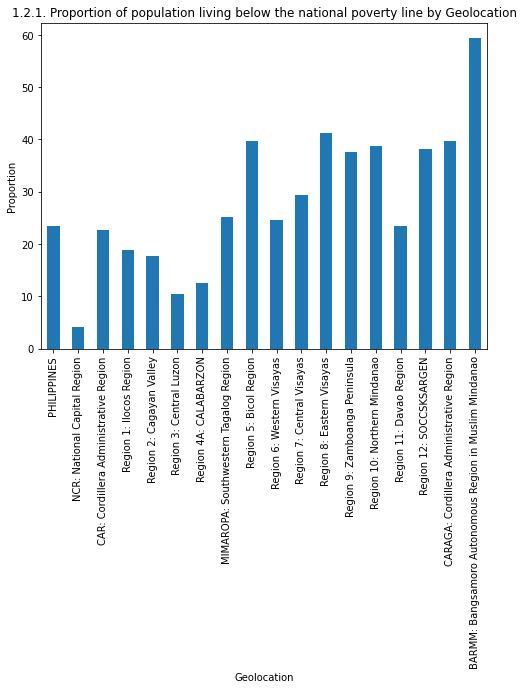

In [295]:
ax1 = data_2015['1.2.1. Proportion of population living below the national poverty line'].plot(figsize=(8, 6), kind='bar', width=0.5)

ax1.set_xticklabels(data_2015['Geolocation'], rotation=90)

ax1.set_title('1.2.1. Proportion of population living below the national poverty line by Geolocation')
ax1.set_ylabel('Proportion');
ax1.set_xlabel('Geolocation');

#### Figure 1. Proportion of population living below the national poverty line by Geolocation (2015)
From the above figure, we can see that the bar of the **National Capital Region** is lower than the other regions. It has a proportion of lower than 10%, compared to the other graphs that look near 10% or higher. 

Using the same [`plot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) function, let us also plot the data from 2018 into a bar graph.

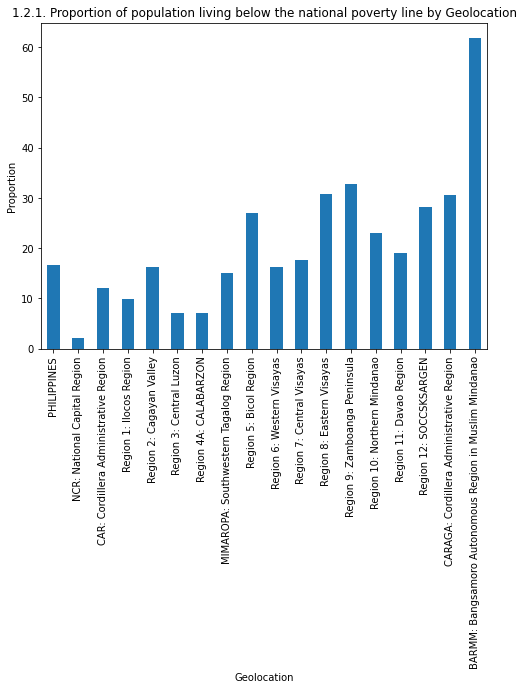

In [296]:
ax2 = data_2018['1.2.1. Proportion of population living below the national poverty line'].plot(figsize=(8, 6), kind='bar', width=0.5)

ax2.set_xticklabels(data_2018['Geolocation'], rotation=90)

ax2.set_title('1.2.1. Proportion of population living below the national poverty line by Geolocation')
ax2.set_ylabel('Proportion');
ax2.set_xlabel('Geolocation');

#### Figure 2. Proportion of population living below the national poverty line by Geolocation (2018)
For the `Year` 2018, we can see that the **National Capital Region** still has the shortest bar. Compared to the 2016 bar of  the region, this one is shorter.

From these two bar graphs, we can conclude that the **National Capital Region** has the lowest proportion value of the population living below the national poverty line for the years available in the dataset (i.e., 2016 and 2018).

### What education level (Junior or Senior High School) has a higher rate per region (2016 - 2018)?

In [297]:
df = combined_data[['Geolocation','Year','3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group']]
df

,Geolocation,Year,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group"
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
391,Region 10: Northern Mindanao,2021,NaN
392,Region 11: Davao Region,2021,NaN
393,Region 12: SOCCSKSARGEN,2021,NaN
394,CARAGA: Cordillera Administrative Region,2021,NaN


Then we would remove rows that are not `PHILIPPINES` since we only aim to look at what year has the most adolescent birth rate. Next, we would drop rows that has **NaN** as its value.

In [298]:
df = df.loc[(df['Geolocation'] == 'PHILIPPINES')]
df = df.dropna()
df

,Geolocation,Year,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group"
54,PHILIPPINES,2003,53.0
144,PHILIPPINES,2008,54.0
234,PHILIPPINES,2013,57.0
306,PHILIPPINES,2017,47.0


Let us plot the `df` data frame using the `plot` function.


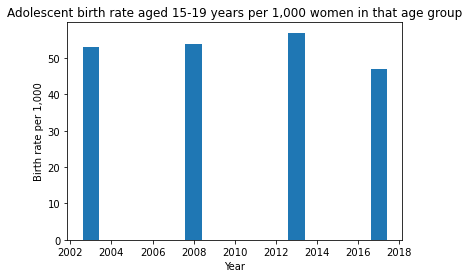

In [299]:
plt.bar(df['Year'],df['3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group'])
plt.xlabel("Year")
plt.ylabel("Birth rate per 1,000")
plt.title("Adolescent birth rate aged 15-19 years per 1,000 women in that age group")
plt.show()

#### Figure 3. Adolescent birth rate aged 15-19 years per 1,000 women in that age group.
From the figure above we can say that the year **2013** has the most adolescent birth rate with 57,000.

### What year has the most adolescent birth rate?
To answer this question, we would be looking at `Geolocation`, `Year`, and `3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group`.

In [300]:
df = combined_data[['Geolocation','Year','3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group']]
df

,Geolocation,Year,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group"
0,PHILIPPINES,2000,NaN
1,NCR: National Capital Region,2000,NaN
2,CAR: Cordillera Administrative Region,2000,NaN
3,Region 1: Ilocos Region,2000,NaN
4,Region 2: Cagayan Valley,2000,NaN
...,...,...,...
391,Region 10: Northern Mindanao,2021,NaN
392,Region 11: Davao Region,2021,NaN
393,Region 12: SOCCSKSARGEN,2021,NaN
394,CARAGA: Cordillera Administrative Region,2021,NaN


Then we would remove rows that are not `PHILIPPINES` since we only aim to look at what year has the most adolescent birth rate. Next, we would drop rows that has **NaN** as its value.

In [301]:
df = df.loc[(df['Geolocation'] == 'PHILIPPINES')]
df = df.dropna()
df

,Geolocation,Year,"3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group"
54,PHILIPPINES,2003,53.0
144,PHILIPPINES,2008,54.0
234,PHILIPPINES,2013,57.0
306,PHILIPPINES,2017,47.0


Let us plot the `df` data frame using the `plot` function.


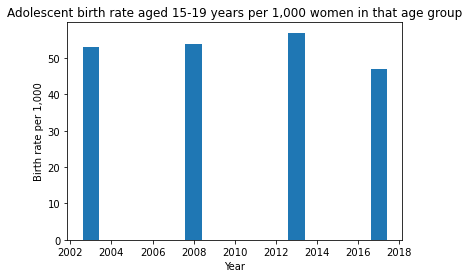

In [302]:
plt.bar(df['Year'],df['3.7.2 Adolescent birth rate aged 15-19 years per 1,000 women in that age group'])
plt.xlabel("Year")
plt.ylabel("Birth rate per 1,000")
plt.title("Adolescent birth rate aged 15-19 years per 1,000 women in that age group")
plt.show()

#### Figure 3. Adolescent birth rate aged 15-19 years per 1,000 women in that age group.
From the figure above we can say that the year **2013** has the most adolescent birth rate with 57,000.

## Conversion of DataFrame to File

## References
*Indicators of sustainable development: Guidelines and methodologies*. United Nations. (n.d.). Retrieved May 23, 2022, from https://www.un.org/esa/sustdev/natlinfo/indicators/methodology_sheets.pdf 

*Net Enrolment Ratio (NER)*. Philippine Statistics Authority. (n.d.). Retrieved May 23, 2022, from https://psa.gov.ph/content/net-enrolment-ratio-ner-1 